In [1]:
from imports import * 
from random import shuffle
import itertools as it

In [2]:
def state_vector(t,states):
    vector = np.empty(len(t),'object')
    for state,interval in states.items():
        vector[interval.in_interval(t) >= 0] = state
    return vector
    
def ratio(activity,state_v):
    fr = {}
    for state in np.unique(state_v):
        fr[state] = np.sum(activity.values[state_v==state,:],axis = 0) / np.sum(state_v == state)

    ratio = fr['REM']/(fr['NREM']+fr['REM'])

    return ratio

def shuffled_ratio(activity,state_v,args):
    # shuffle(state_v)
    np.random.seed()
    state_v = np.roll(state_v,np.random.randint(len(state_v)*2))
    shuffled_ratio = ratio(activity,state_v)
    return shuffled_ratio

def poisson_test(neuron,on_state,off_state):
    
    pInc = np.empty(len(neuron))
    pDec = np.empty(len(neuron))
    surprise = np.empty(len(neuron))
    for i,n in enumerate(neuron):
        baseRate = len(n.restrict(off_state))/off_state.tot_length(time_units = 's')
        count = len(n.restrict(on_state))
        time = on_state.tot_length(time_units = 's')
        pInc[i],pDec[i],surprise[i] = bk.stats.poisson(baseRate,count,time)

    stats = pd.DataFrame(np.array([pInc,pDec,surprise]).T,columns=['pInc','pDec','surprise'])
    return stats



def multi_shuffles_ratio(activity, state_v, n_shuffles, n_workers):
    shuffles = bk.multi.multiprocessing(shuffled_ratio, zip(it.repeat(activity),
                                                            it.repeat(state_v),
                                                            range(n_shuffles)), n_workers)
    return np.array(shuffles)


In [3]:
def rem_on_off(base_folder, local_path, *args, **kwargs):
    
    bk.load.current_session_linux(base_folder,local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)
    sleep = bk.load.intervals('sleep_wake')

    activity = bk.compute.binSpikes(
        neurons, as_Tsd=True, binSize=1).restrict(sleep['SLEEP'])
    state_v = state_vector(activity, states)

    ratios = ratio(activity, state_v)
    shuffles = multi_shuffles_ratio(activity, state_v, 10, 12)

    pValues = []
    labels = np.empty(len(neurons), 'object')
    for i, n in enumerate(neurons):
        pValues.append(bk.stats.shuffles_pvalue(shuffles[:, i], ratios[i]))
        if (ratios[i] > 0.5) & (pValues[i] < 0.001):
            labels[i] = 'REM_ON'
        elif (ratios[i] < 0.5) & (pValues[i] < 0.001):
            labels[i] = 'REM_OFF'
        else:
            labels[i] = None
    df = {'pValue': pValues,
          'REM_label': labels}
    df = pd.DataFrame(df)

    poisson = poisson_test(neurons,states['REM'],states['NREM'])
    print(poisson)
    
    return pd.concat((metadata,df,poisson),axis = 1)

NameError: name 'df' is not defined

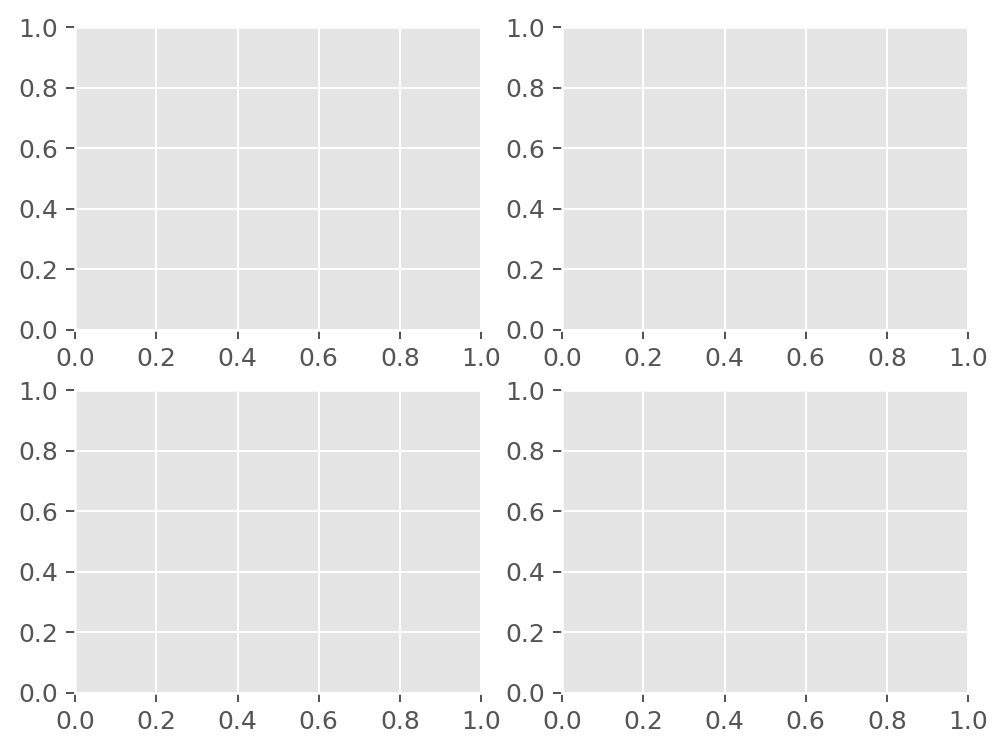

In [4]:
fig,ax = plt.subplots(2,2,dpi = 180)
df_stru_type = {}
for i,stru in enumerate(['BLA','Hpc']):
    df_stru_type[stru] = {}
    for j,types in enumerate(['Pyr','Int']):
        df_stru_type[stru][types] = df[(df.Region == stru) & (df.Type == types)]
        print(len(df_stru_type[stru][types]),stru+types)
        data = [np.sum(df_stru_type[stru][types].pInc < 0.001),np.sum(df_stru_type[stru][types].pDec < 0.001),np.sum((df_stru_type[stru][types].pInc > 0.001)& (df_stru_type[stru][types].pDec > 0.001))]
        ax[i,j].pie(data,labels = ['REM_ON','REM_OFF','None'],autopct='%.0f%%',colors = colors)
        ax[i,j].set_title(stru+types)

In [13]:
df[(df.Region == 'BLA') & (df.Type == 'Int')].shape

(261, 11)

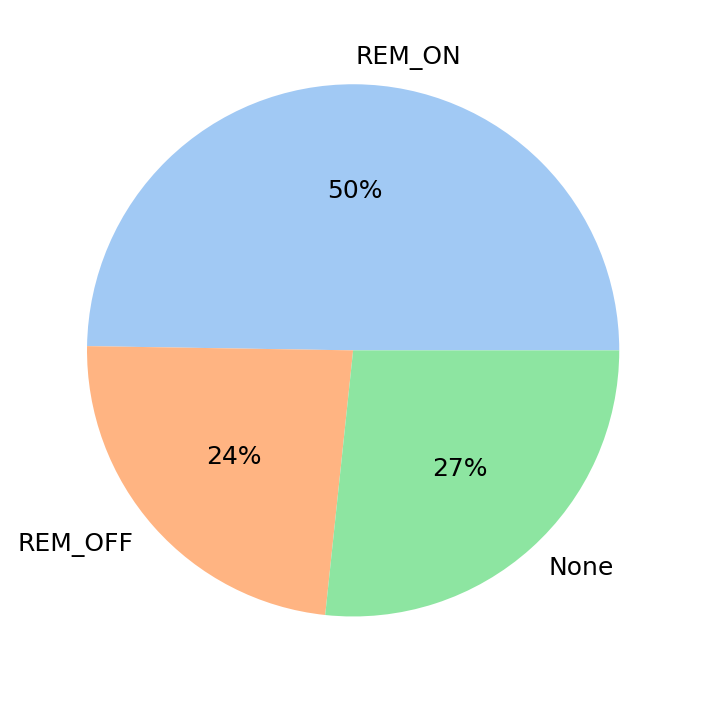

In [10]:
# batch,metadata = bk.load.batch(rem_on_off)
# df = pd.concat(batch).reset_index(drop = True)

colors = sns.color_palette('pastel')[0:3]
df_bla_pyr = df[(df.Region == 'BLA') & (df.Type == 'Pyr')]
data = [np.sum(df_bla_pyr.REM_label == 'REM_ON'),np.sum(df_bla_pyr.REM_label == 'REM_OFF'),np.sum(df_bla_pyr.REM_label.values == None)]

plt.subplots(1,1,dpi = 180)
plt.pie(data,labels = ['REM_ON','REM_OFF','None'],autopct='%.0f%%',colors = colors)
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/poisson_surprise_pyr.svg')

([<matplotlib.patches.Wedge at 0x7fdfb99c0760>,
 [Text(0.9697980808564911, 0.5191258829677701, 'REM_ON'),
  Text(0.3781504430243479, 1.032958006136014, 'REM_OFF'),
  Text(-0.8208771522572662, -0.7322299508364849, 'None')],
 [Text(0.5289807713762678, 0.28315957252787455, '16%'),
  Text(0.20626387801328067, 0.563431639710553, '8%'),
  Text(-0.4477511739585088, -0.399398155001719, '77%')])

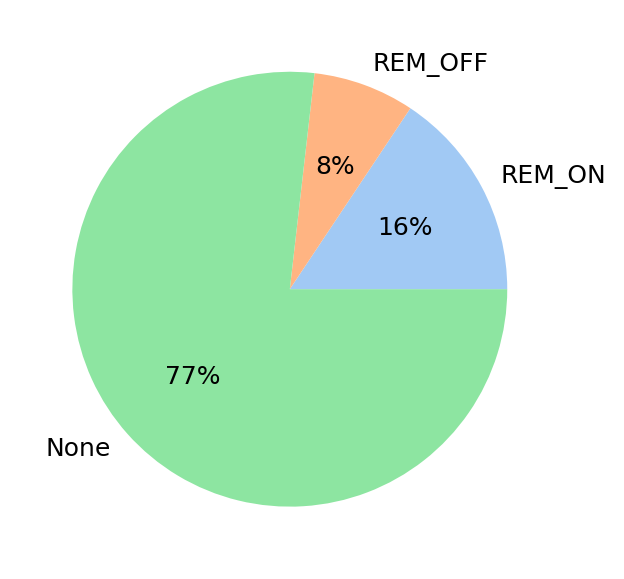

In [106]:
plt.hist(shuffles[:,84],100)
plt.axvline(ratios[84],color = 'green')

In [71]:
activity.shape

(12122, 252)

In [82]:
%matplotlib
fig,ax = plt.subplots(1,1)
plt.plot(activity.times('s'),activity.values[:,1])
bk.plot.intervals(states['REM'],ax = ax)
bk.plot.intervals(states['NREM'],col = 'grey',ax = ax)


Using matplotlib backend: Qt5Agg


/tmp/ipykernel_460195/3264500157.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi = 120)


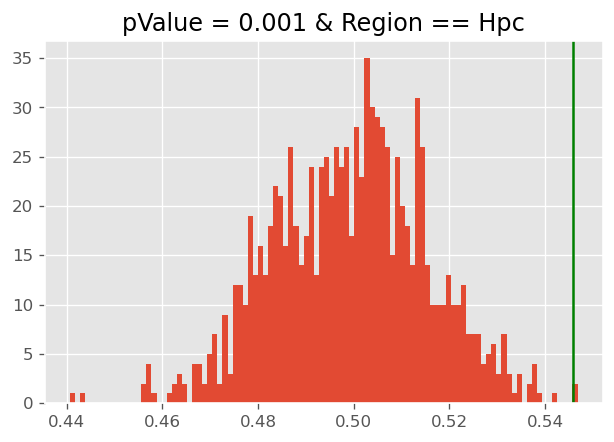

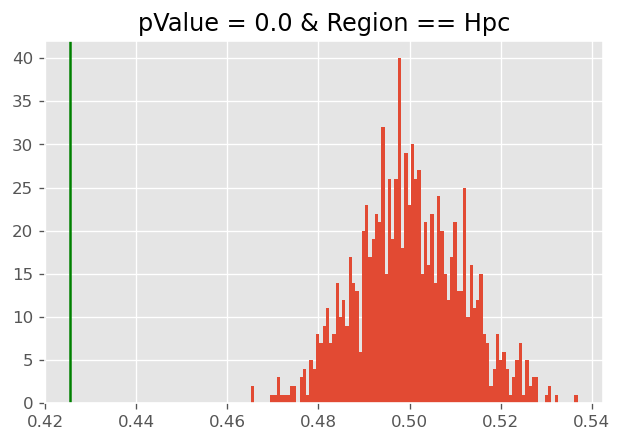

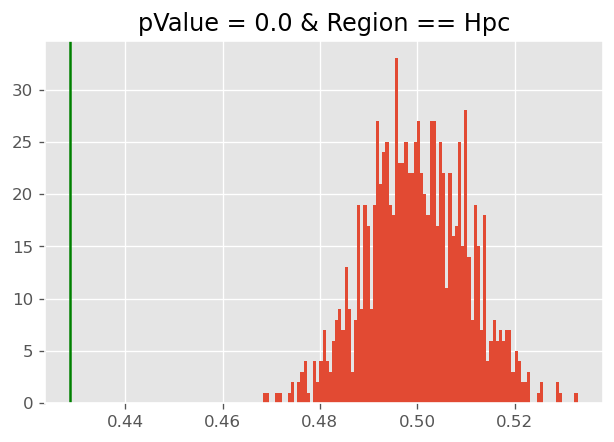

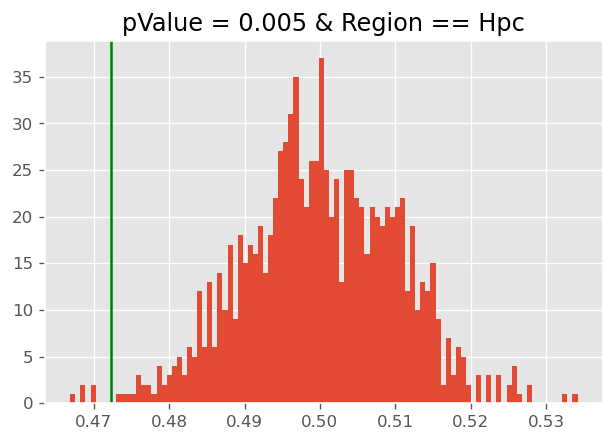

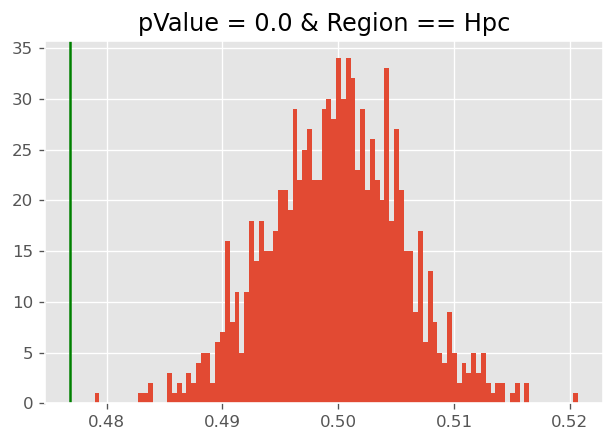

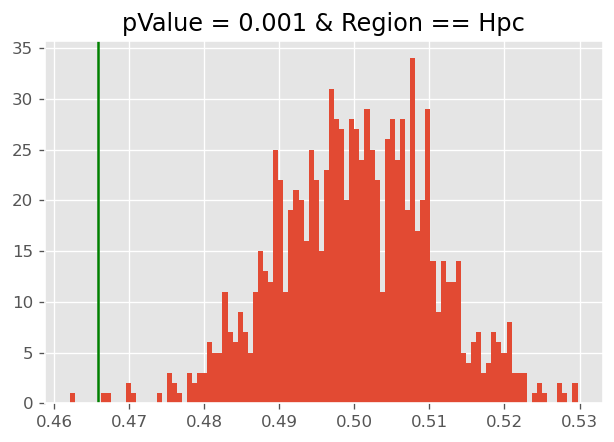

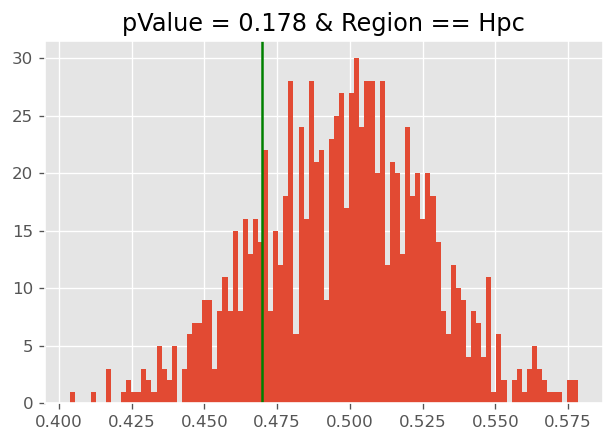

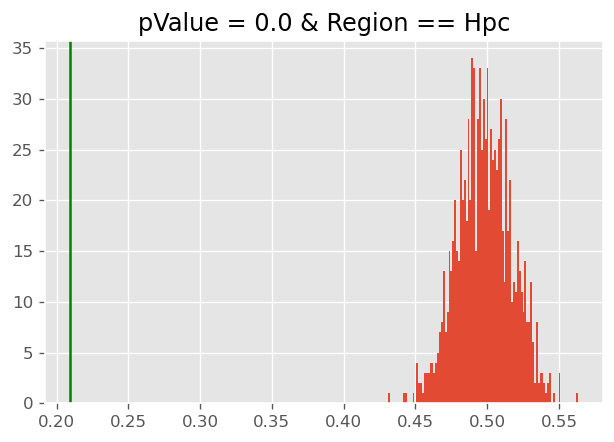

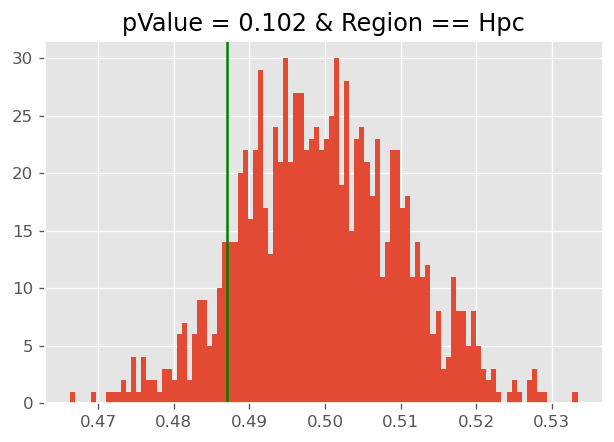

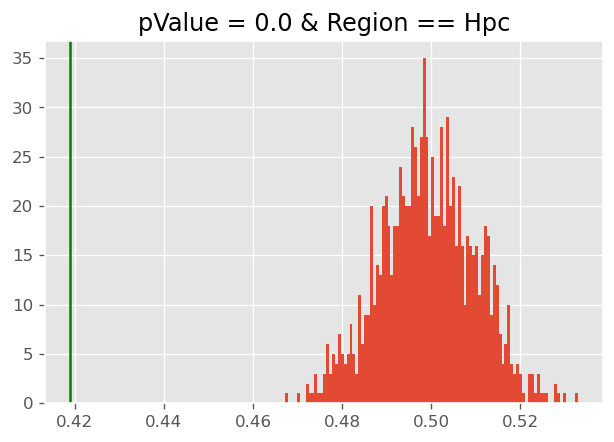

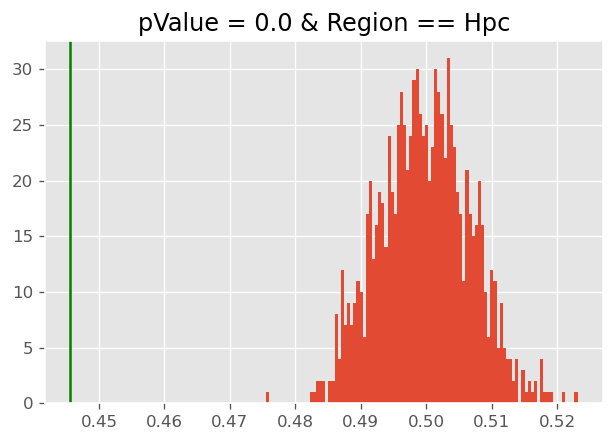

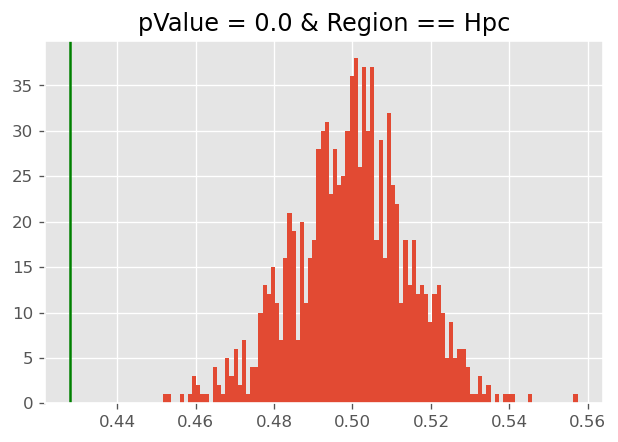

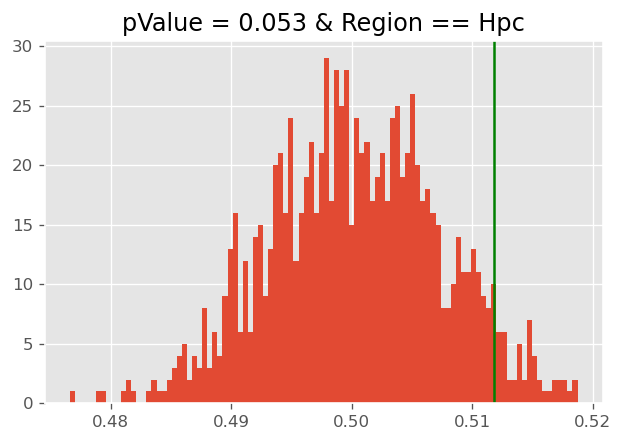

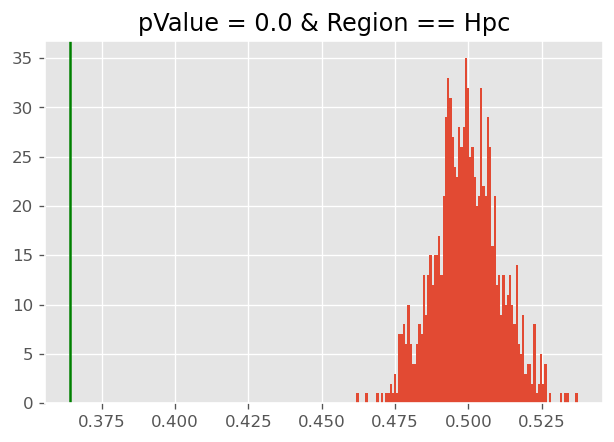

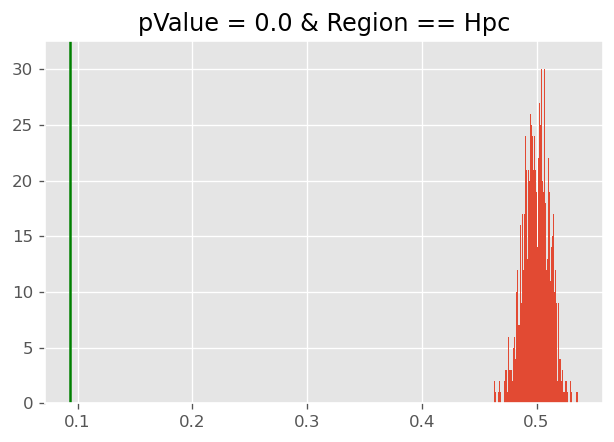

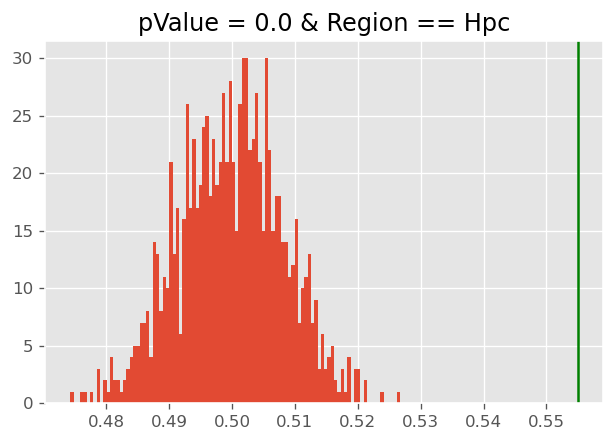

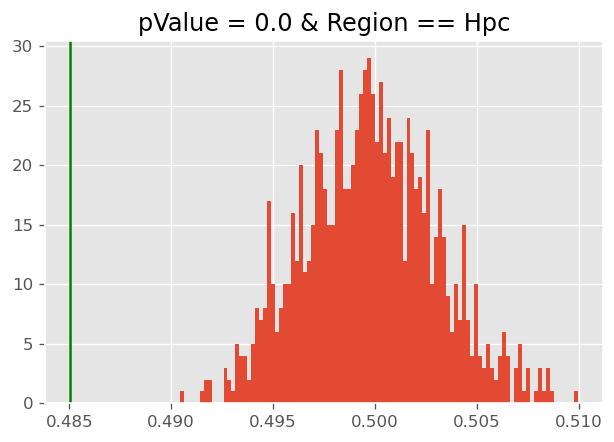

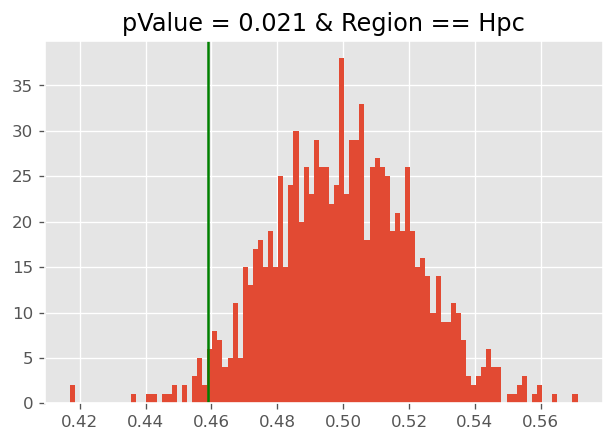

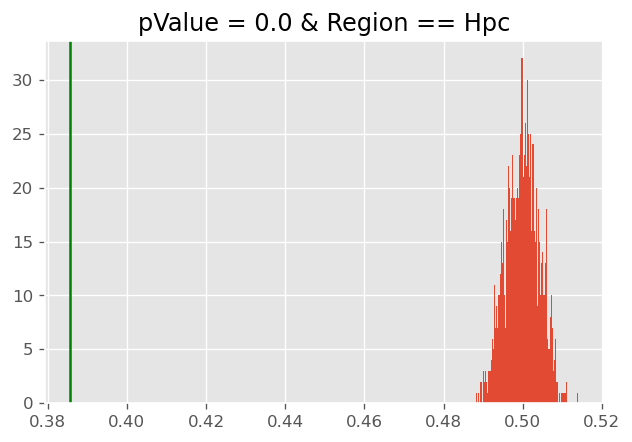

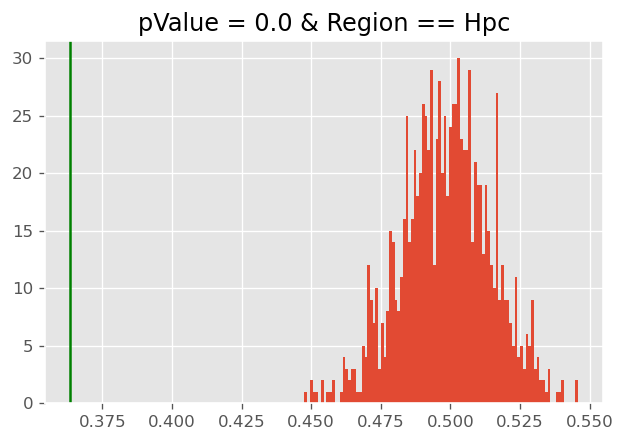

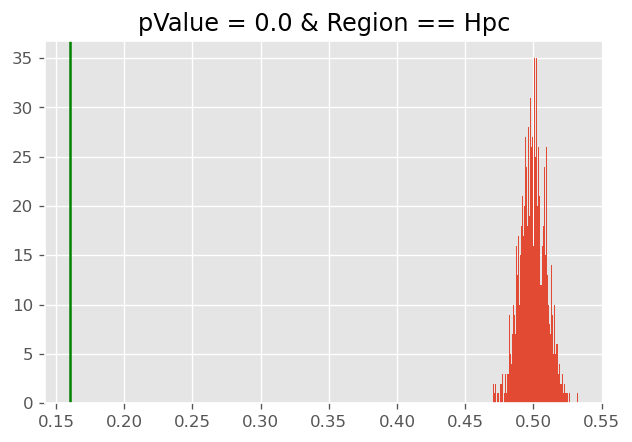

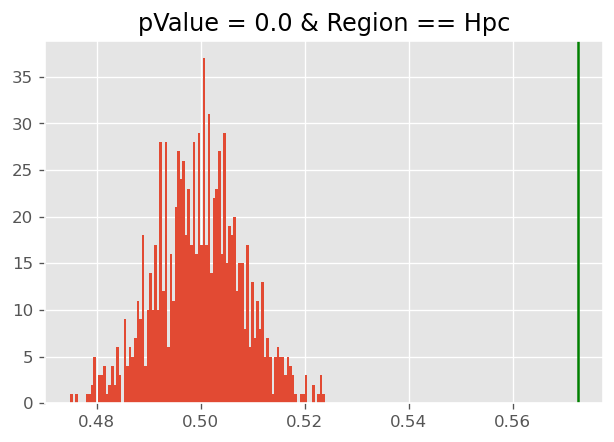

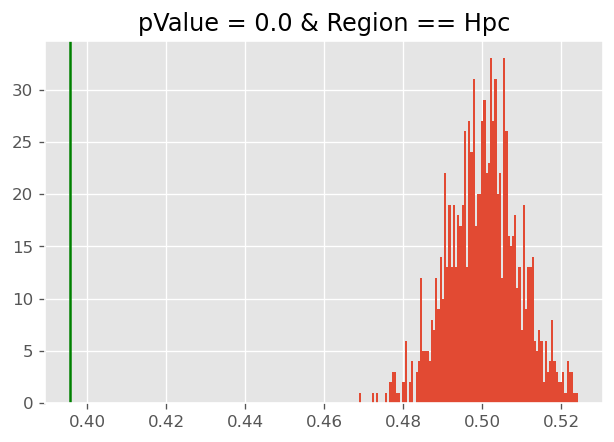

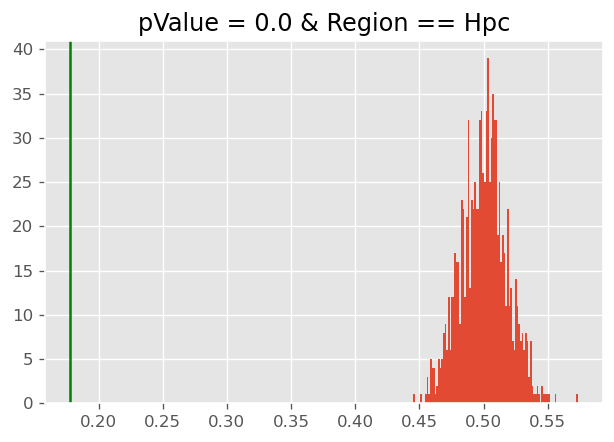

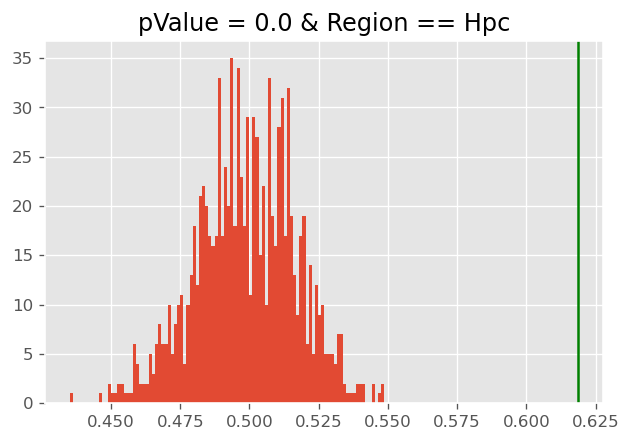

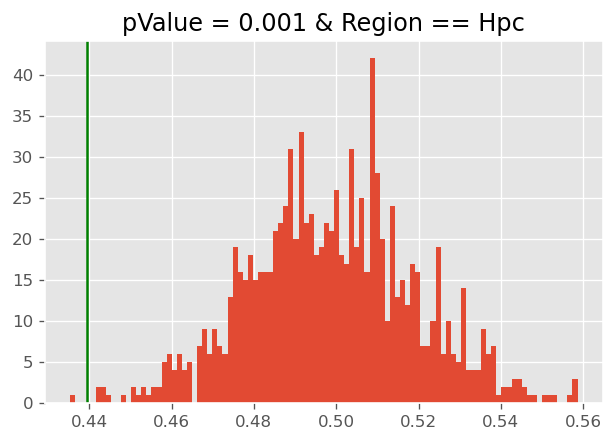

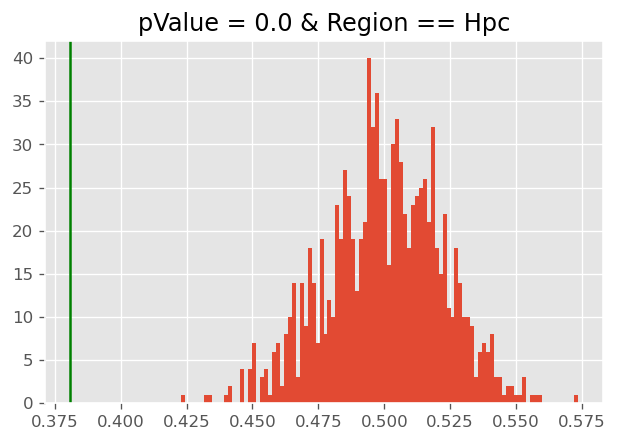

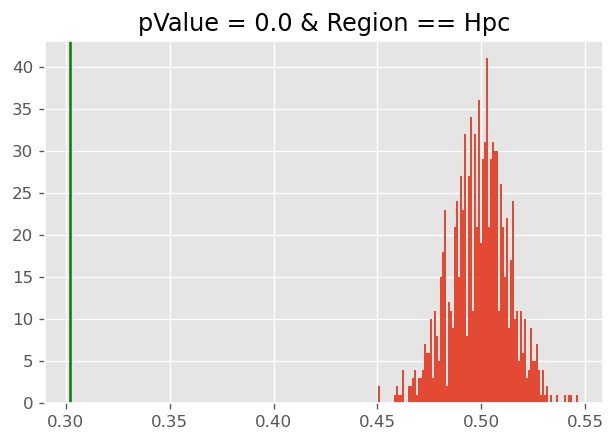

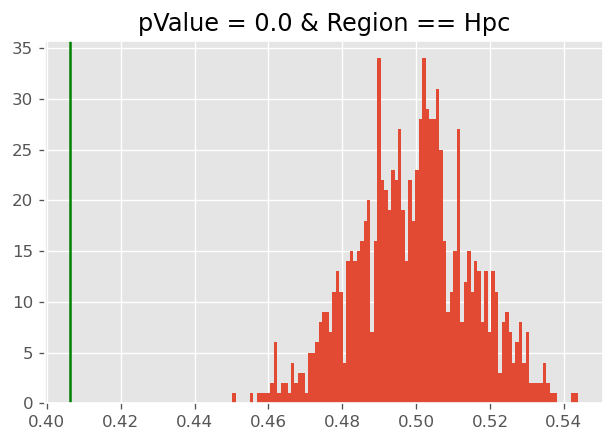

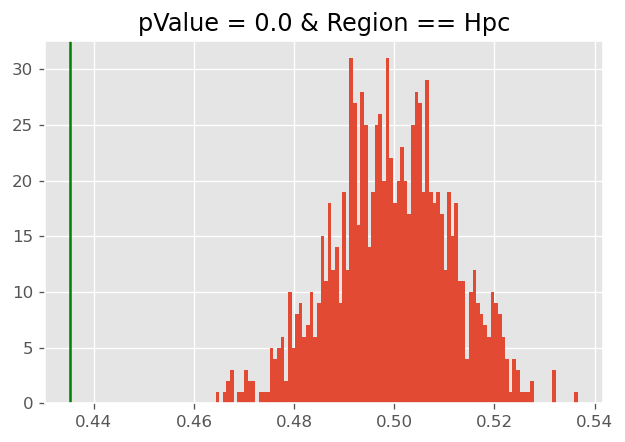

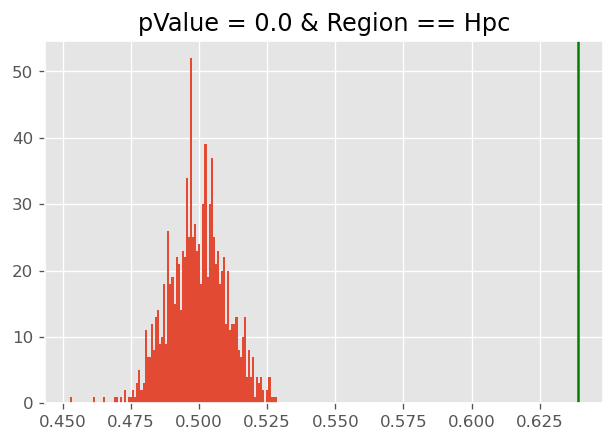

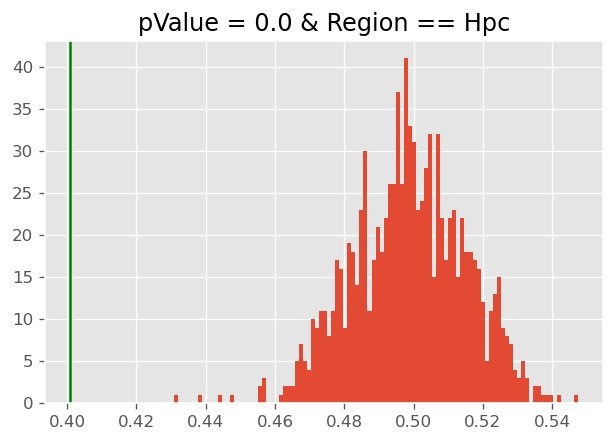

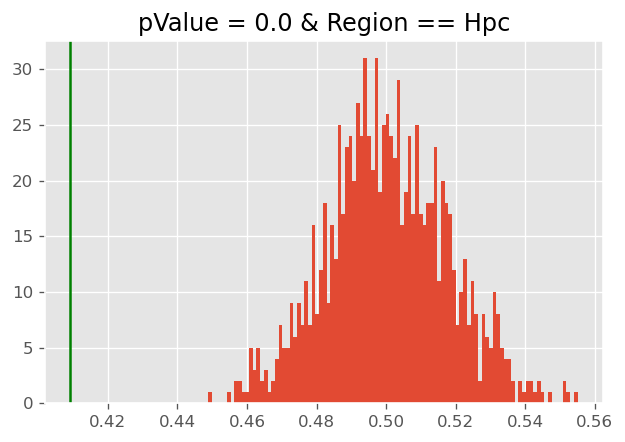

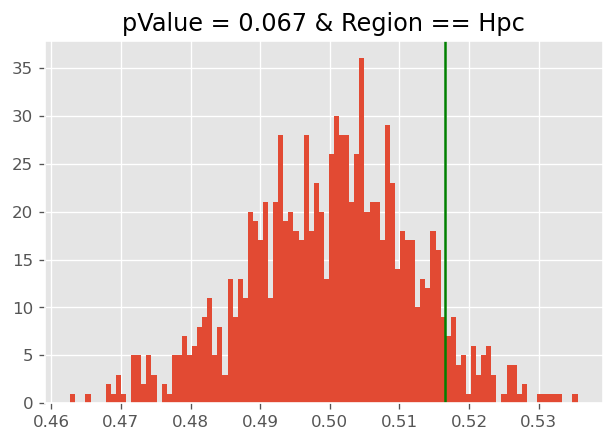

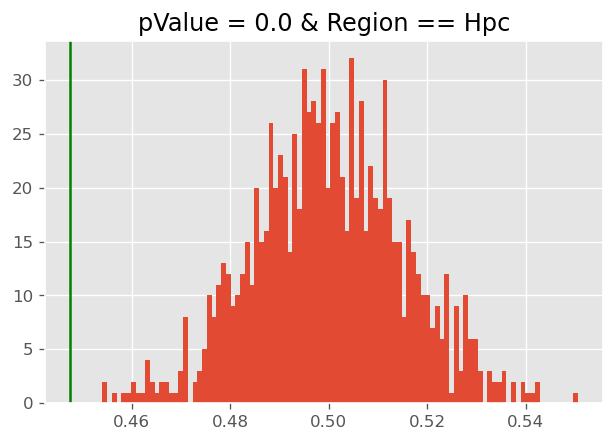

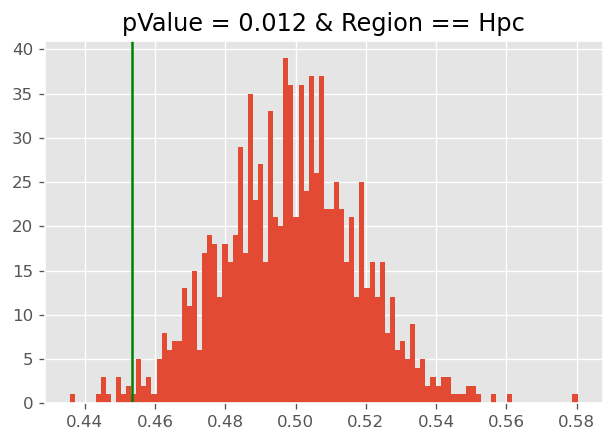

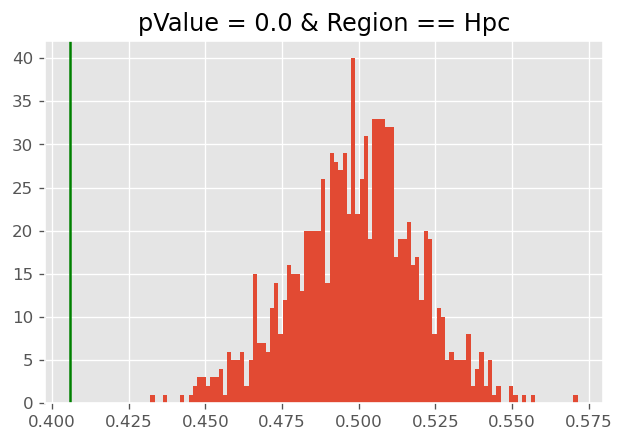

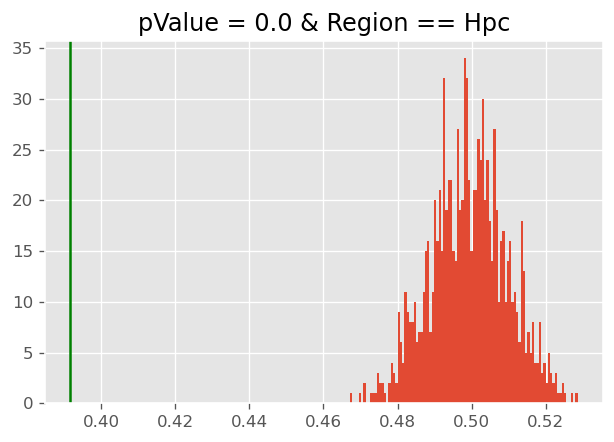

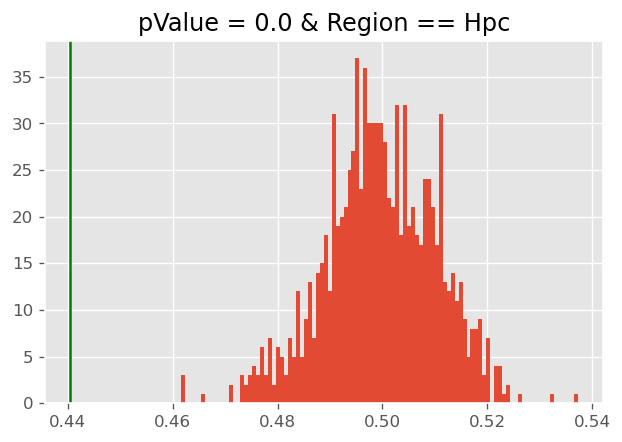

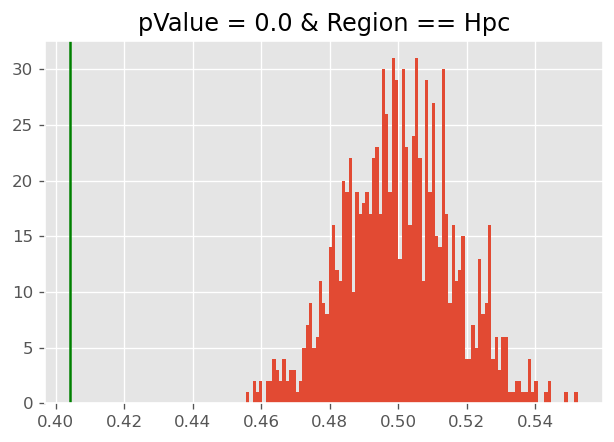

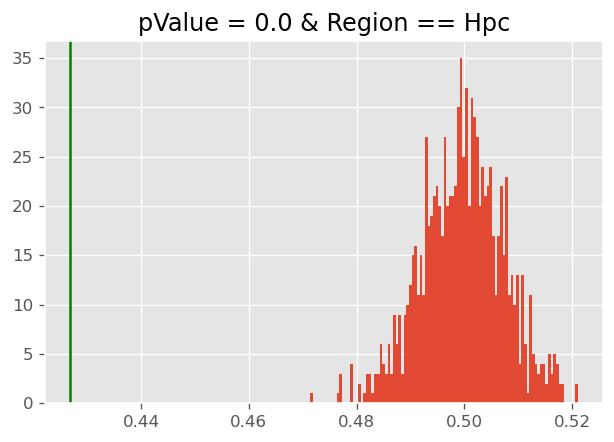

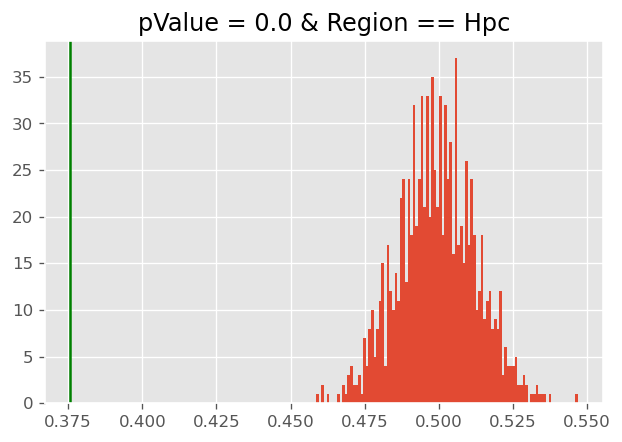

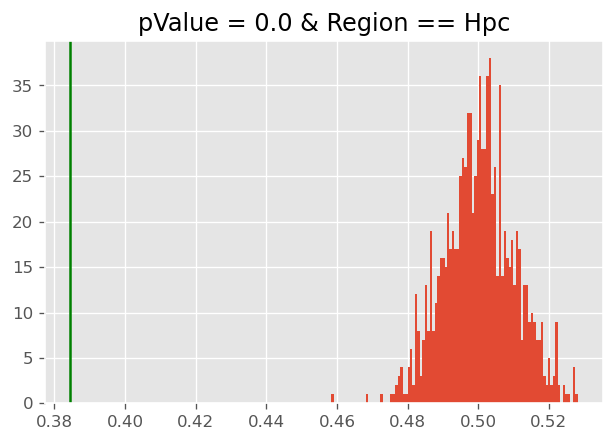

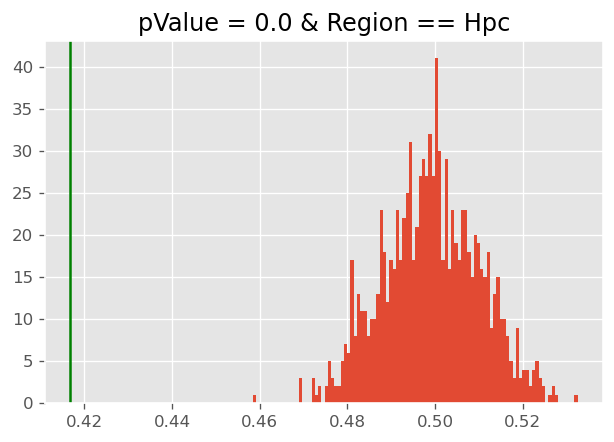

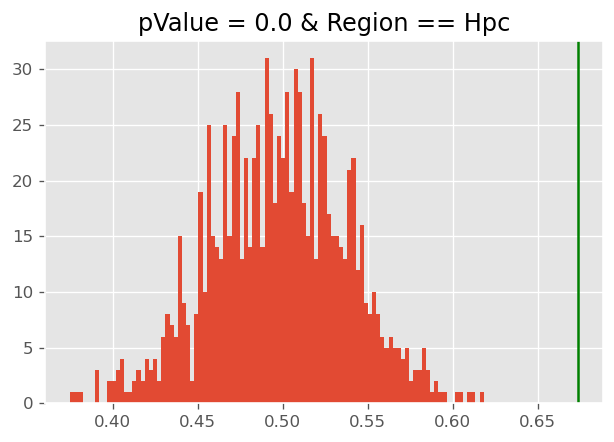

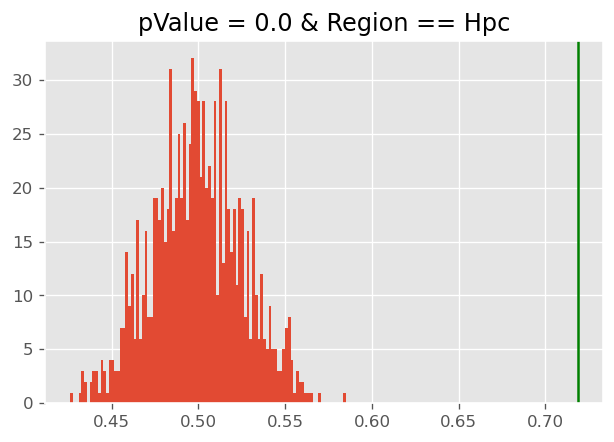

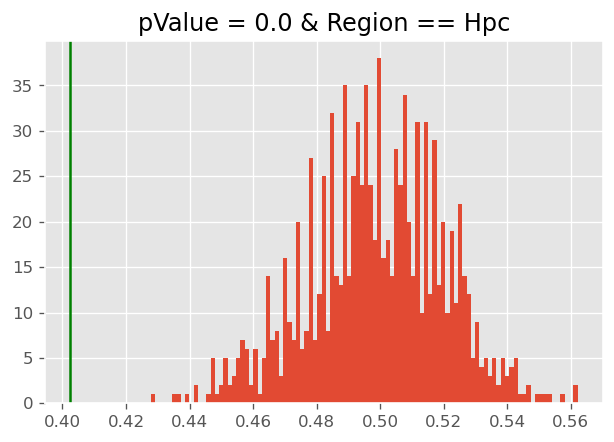

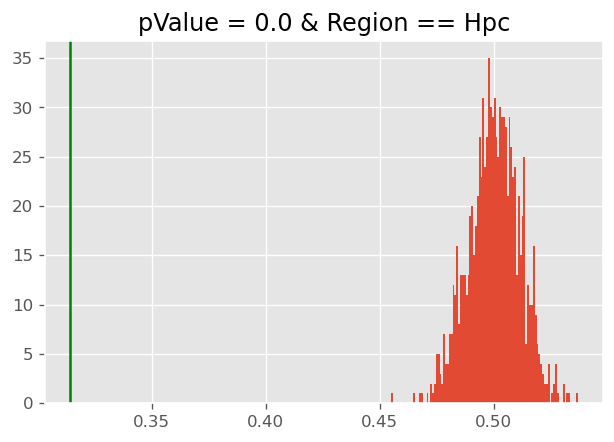

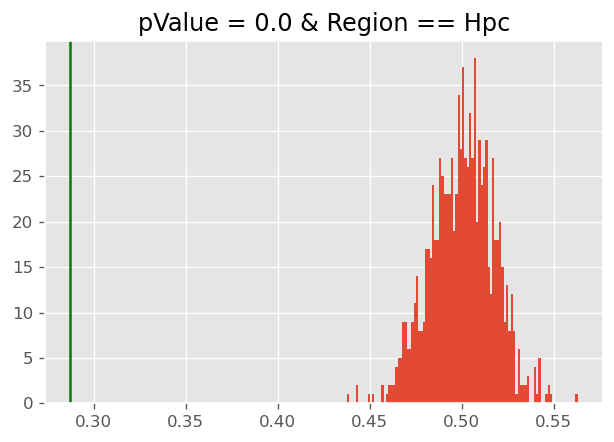

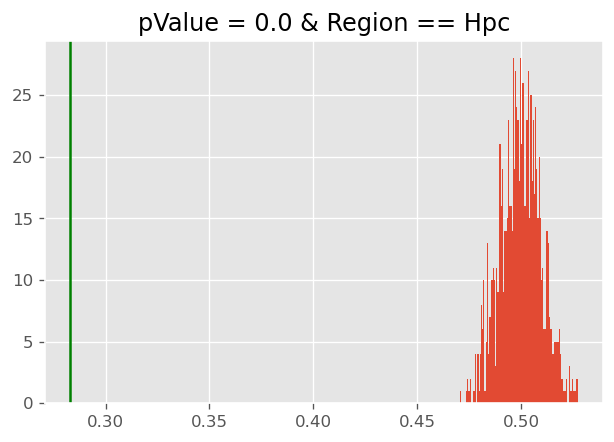

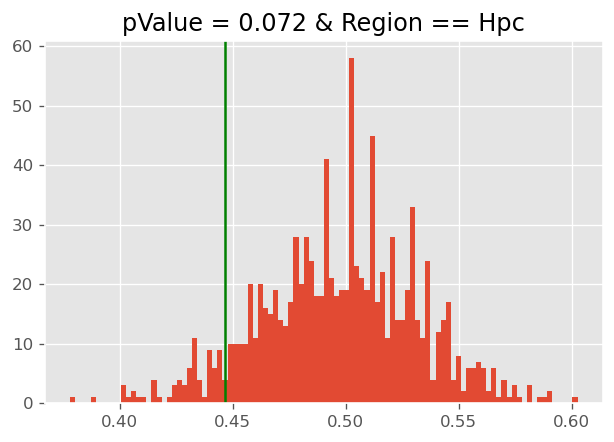

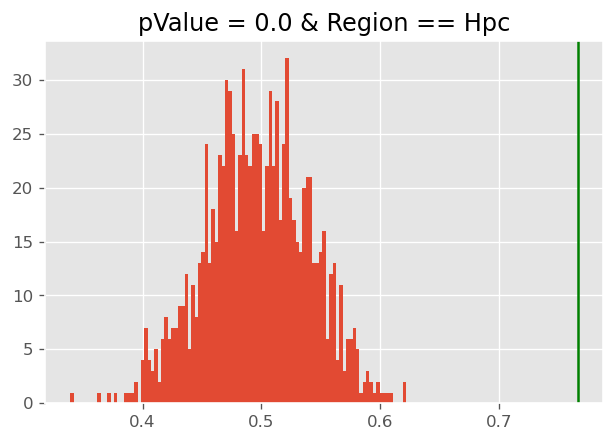

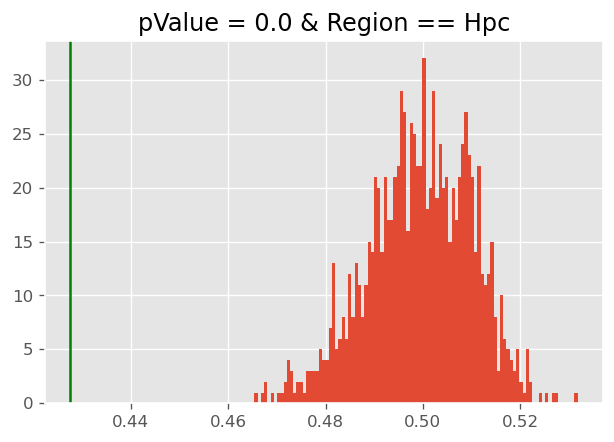

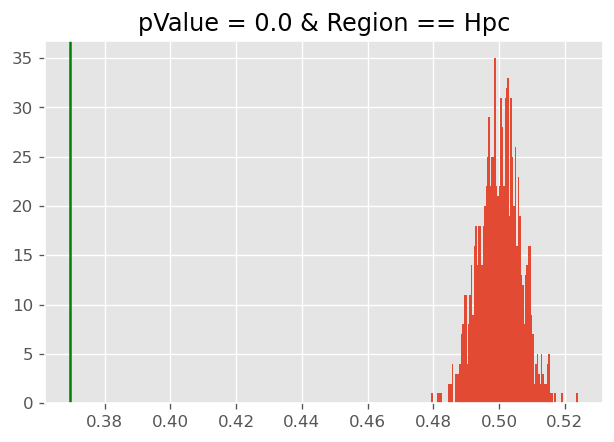

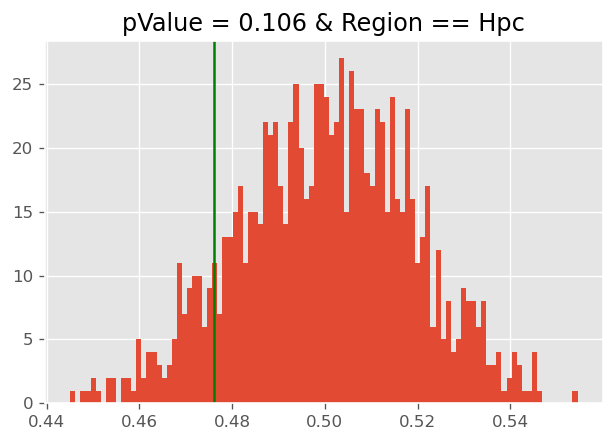

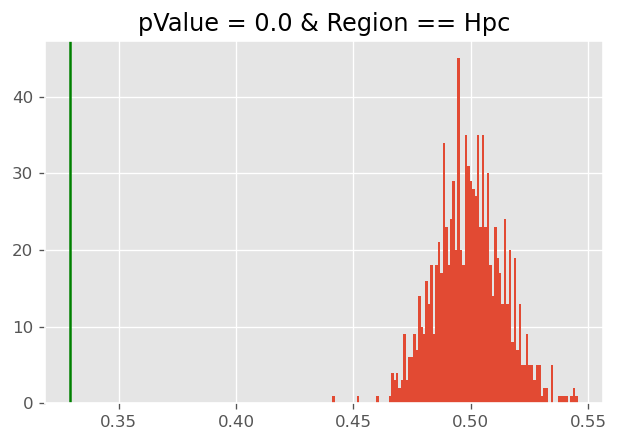

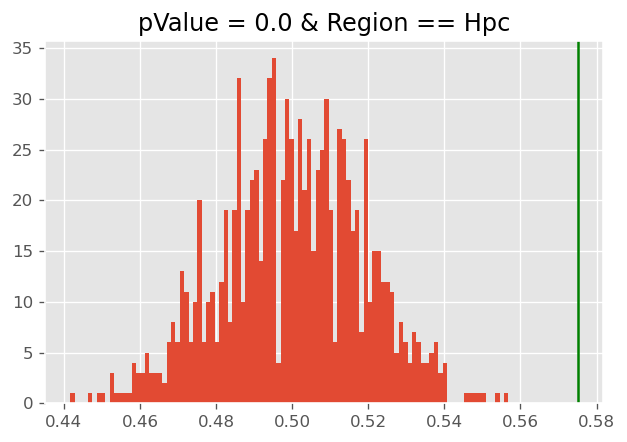

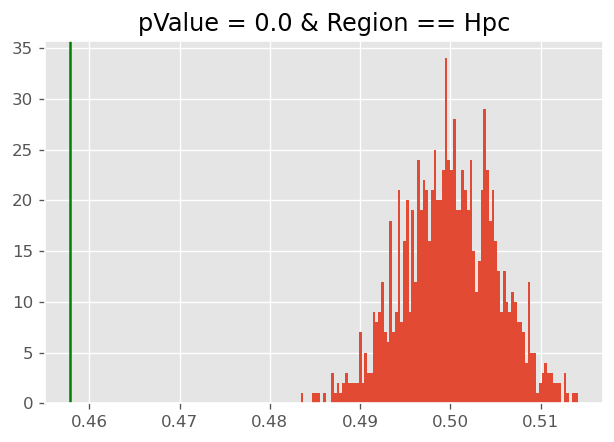

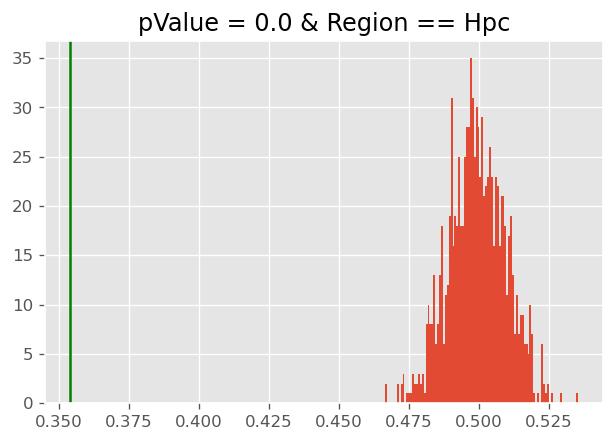

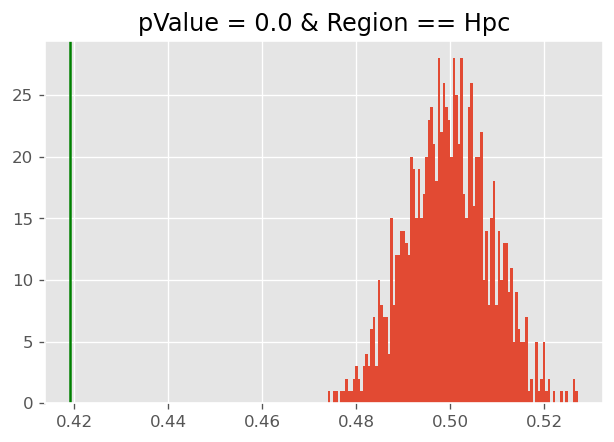

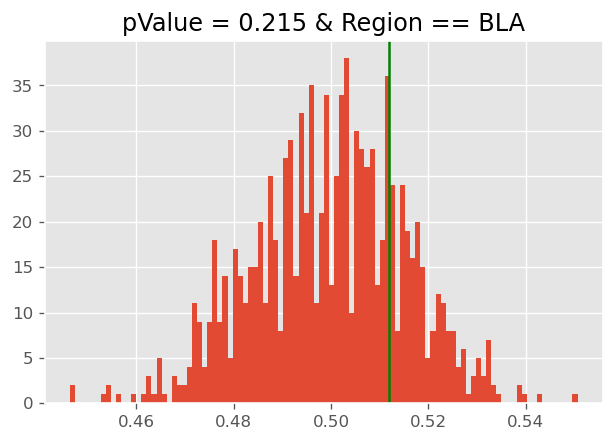

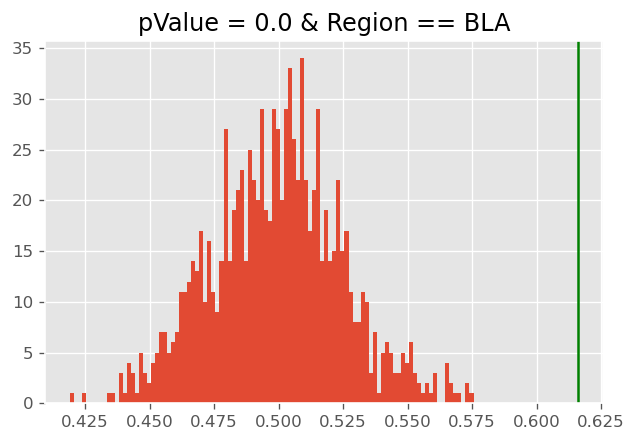

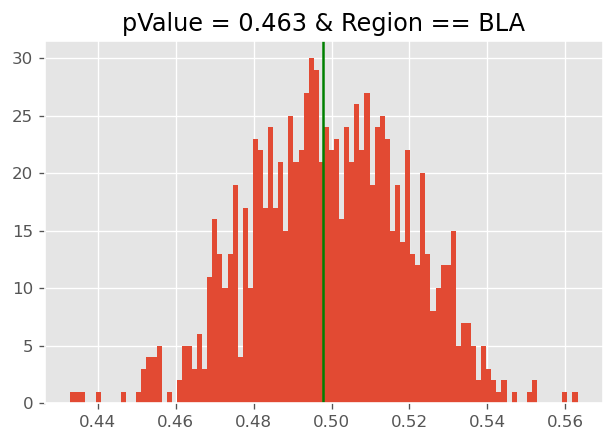

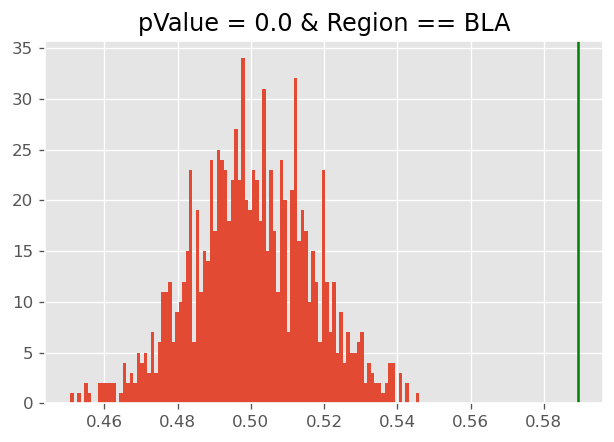

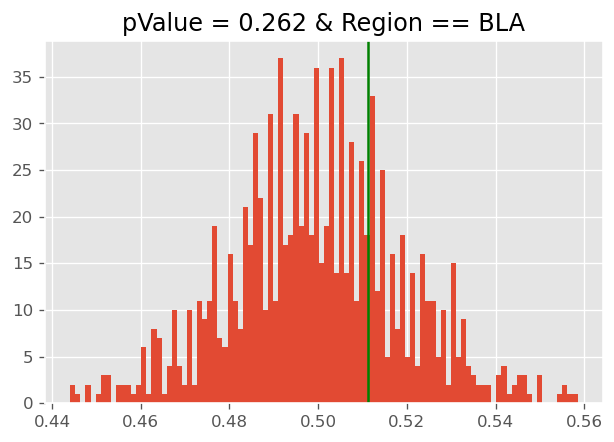

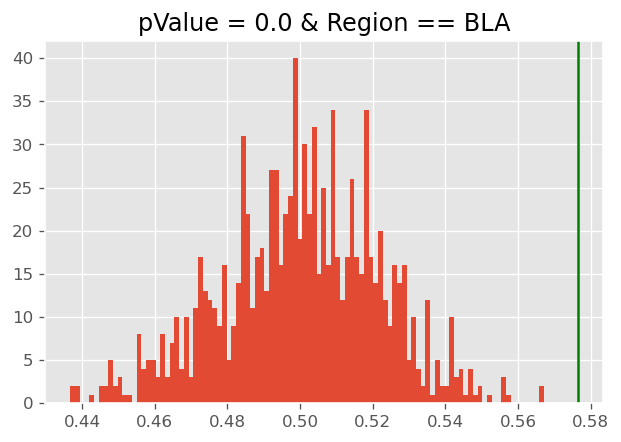

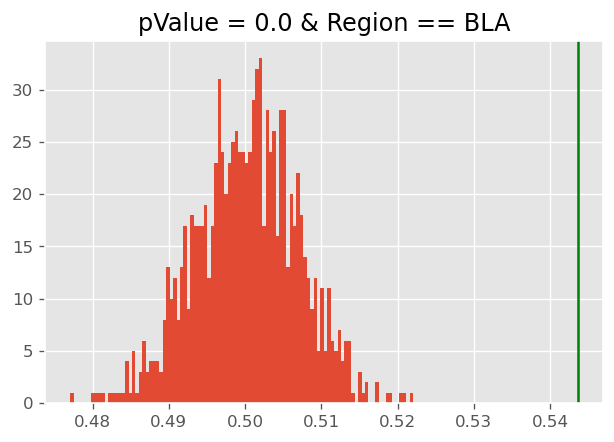

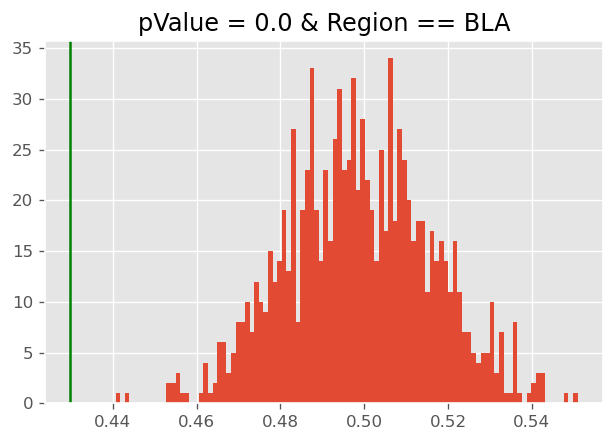

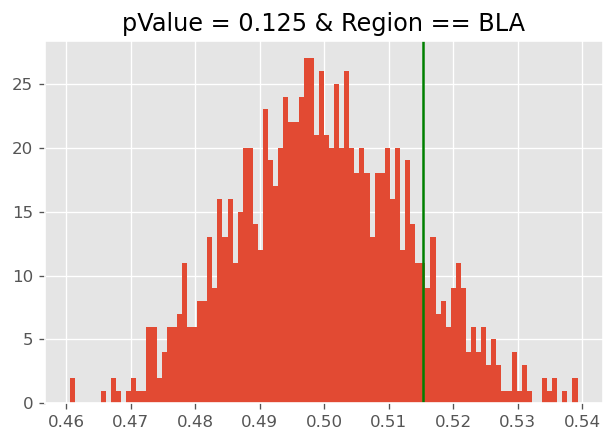

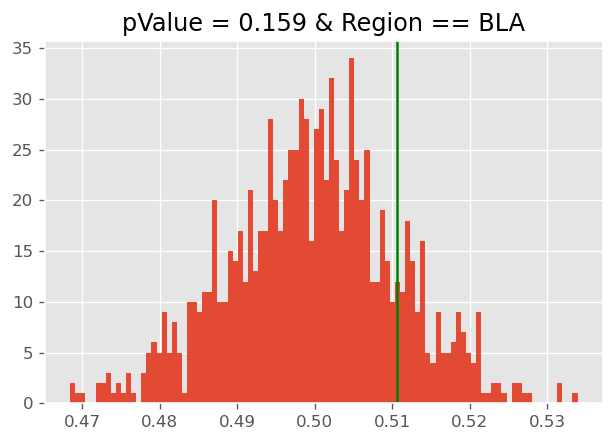

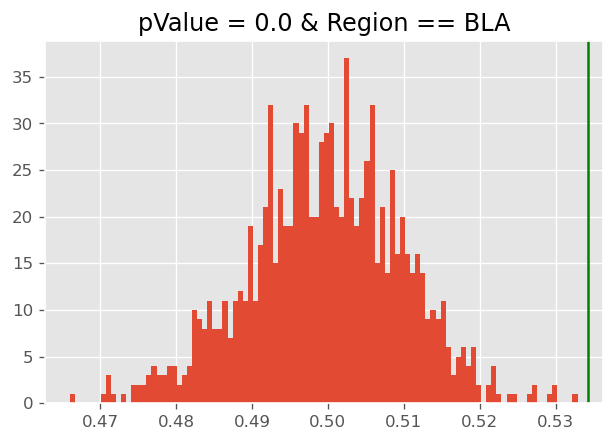

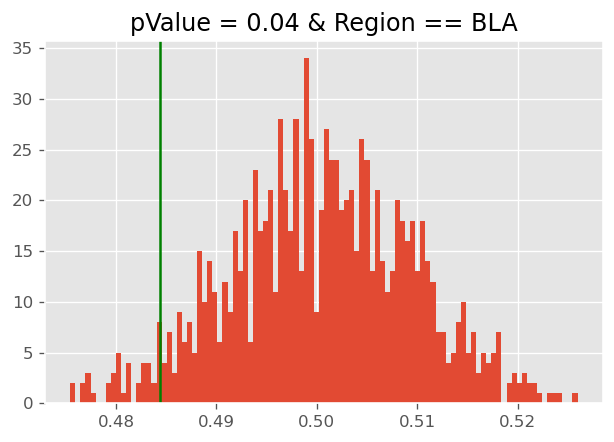

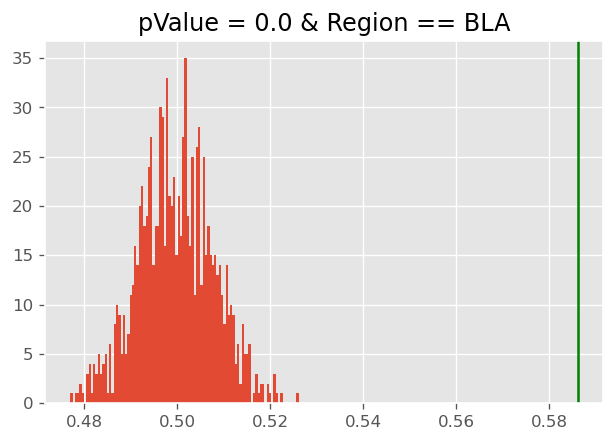

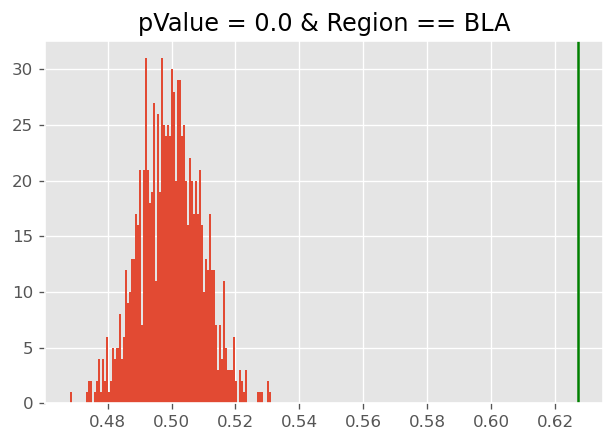

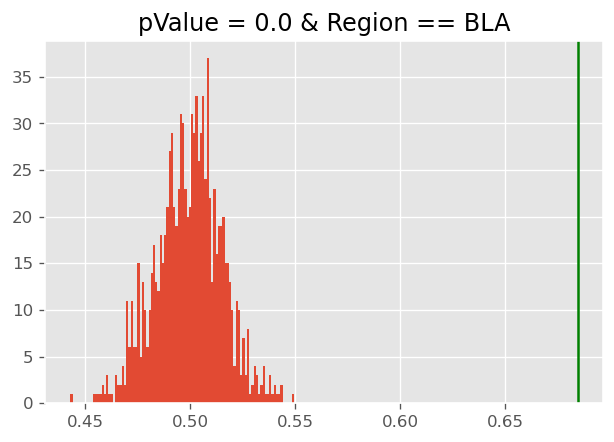

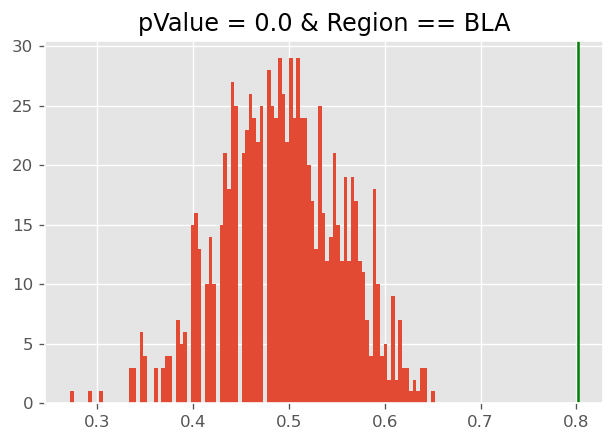

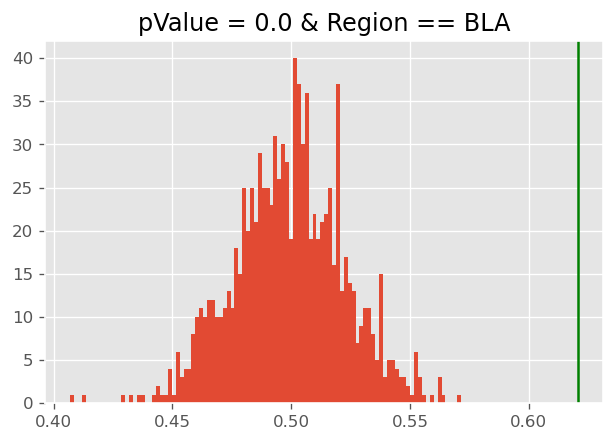

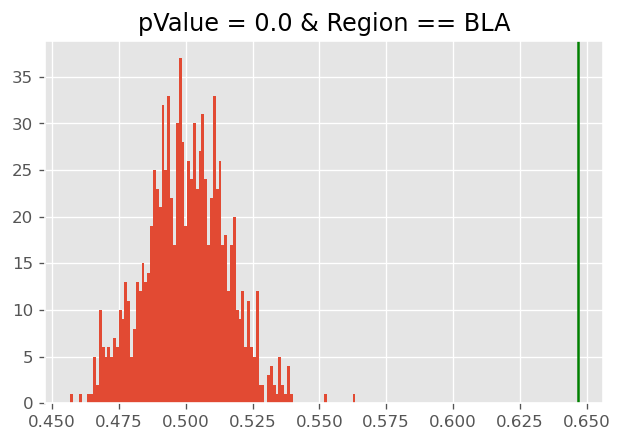

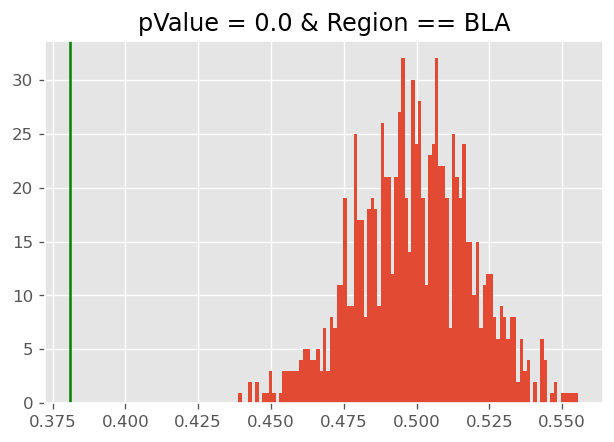

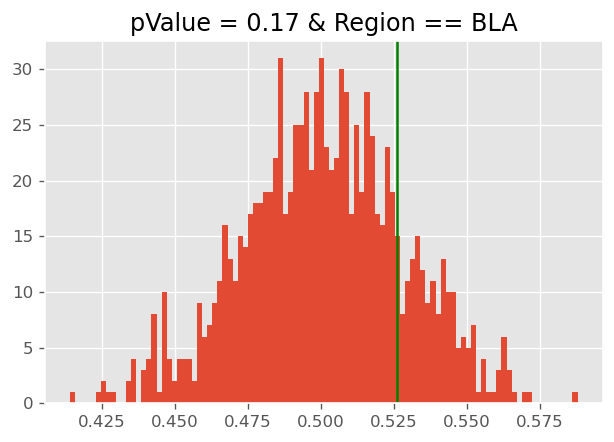

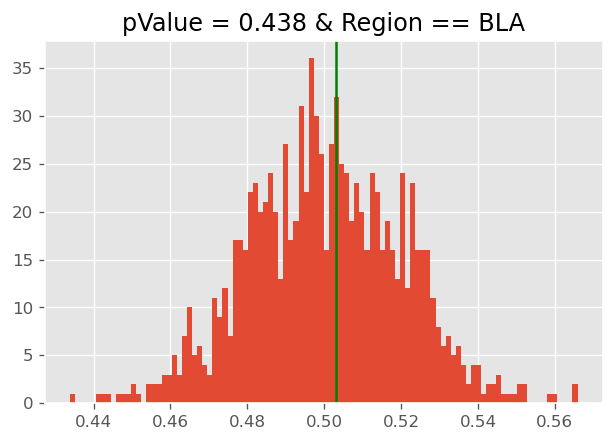

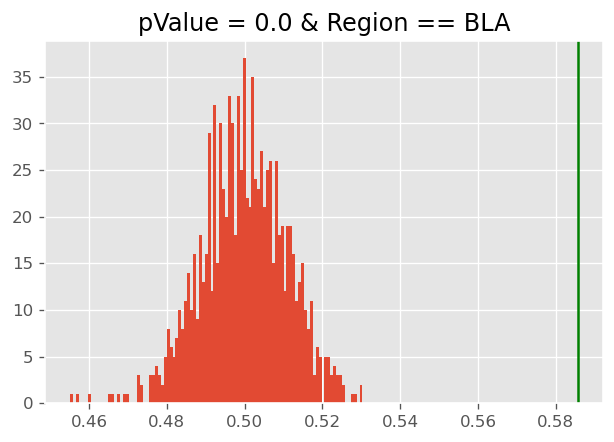

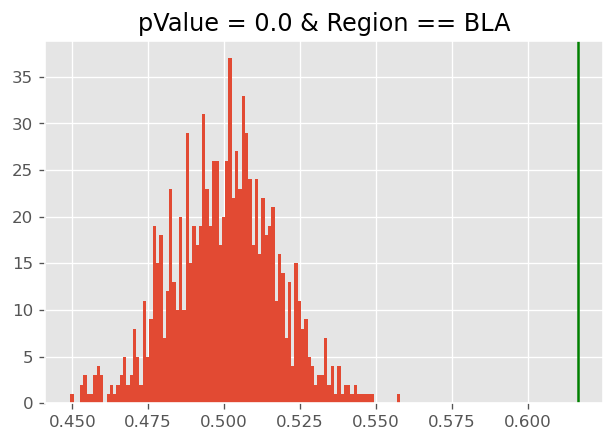

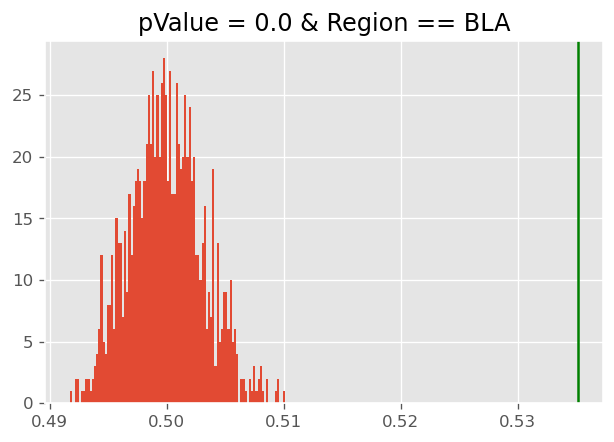

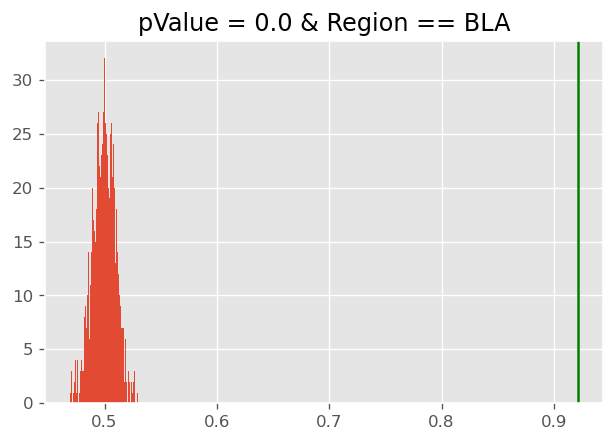

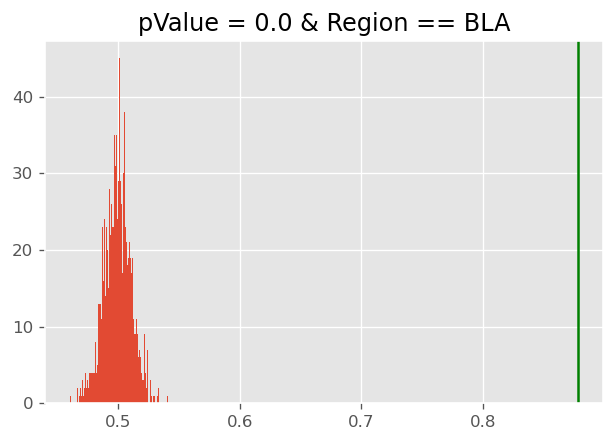

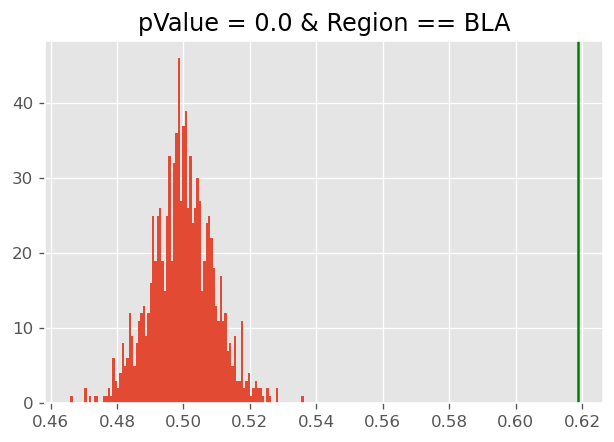

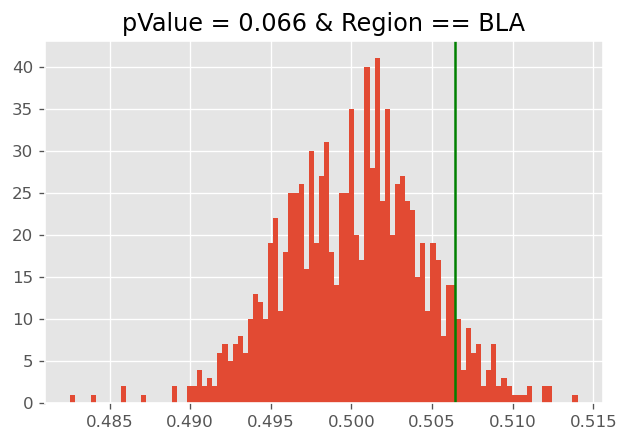

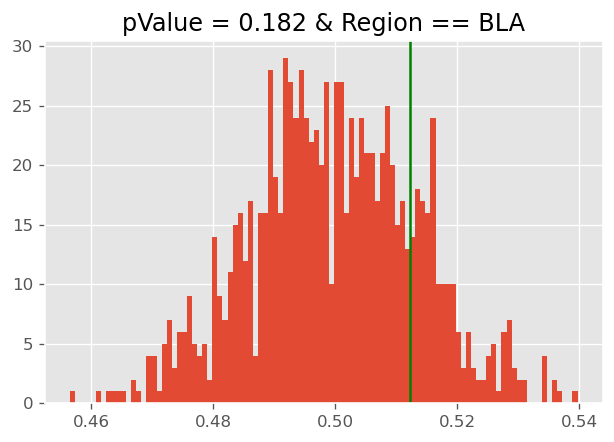

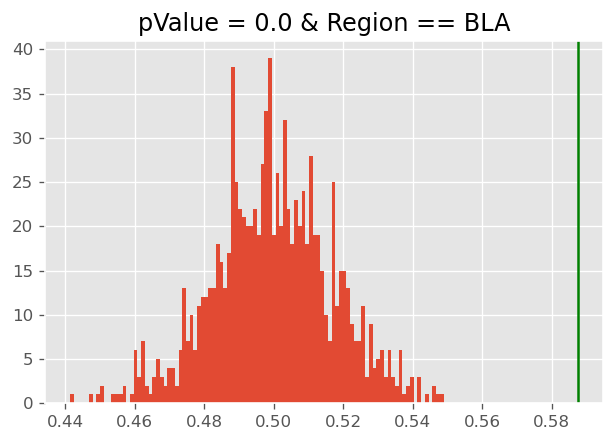

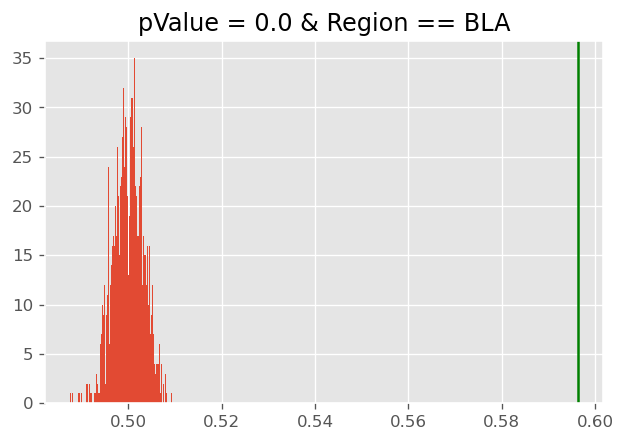

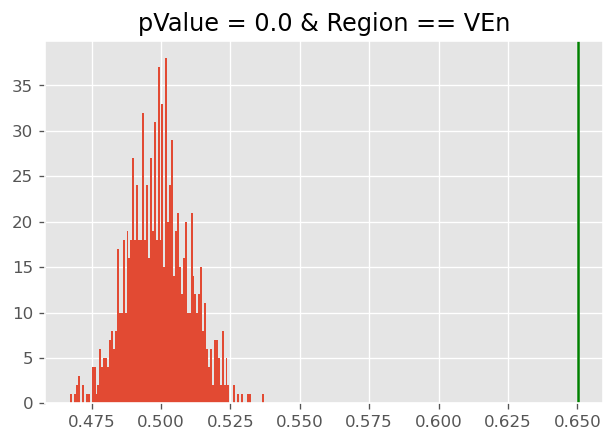

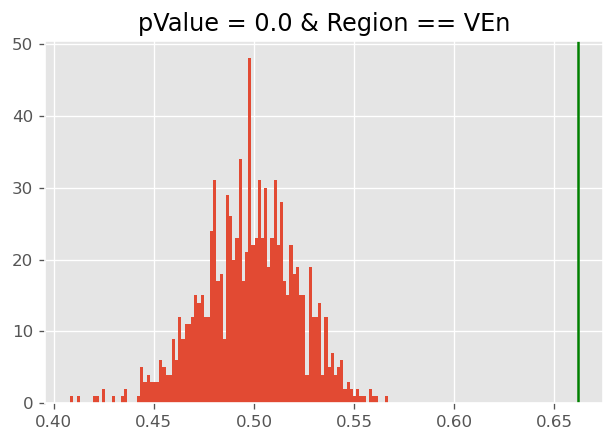

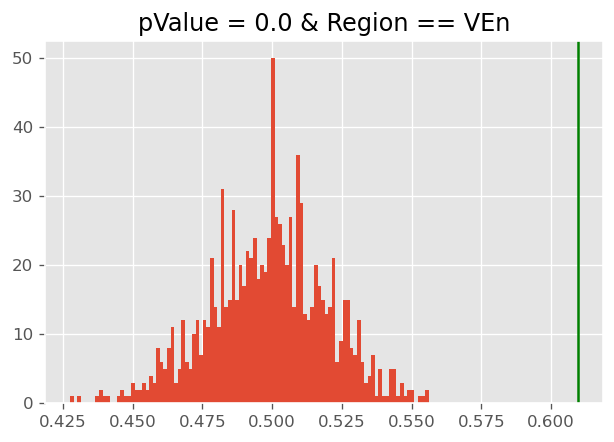

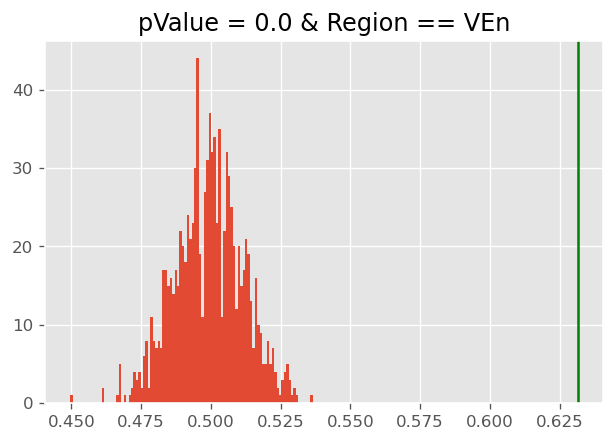

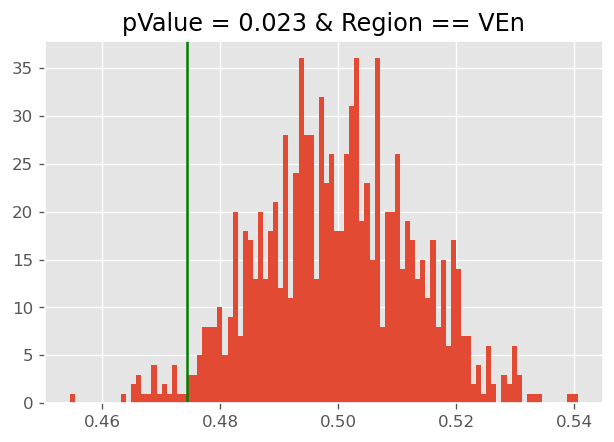

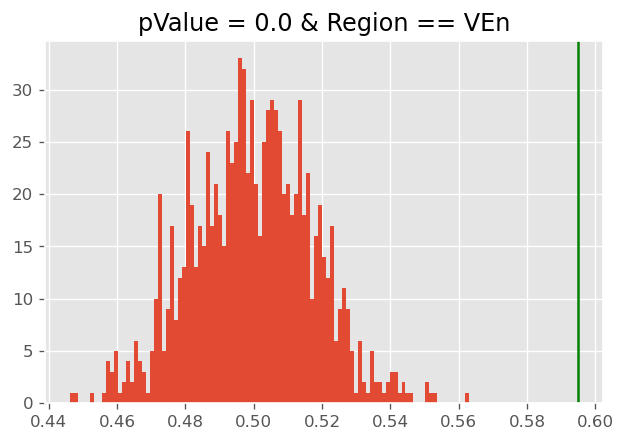

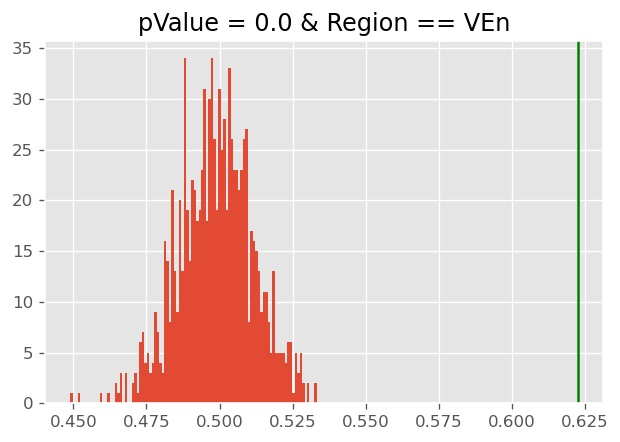

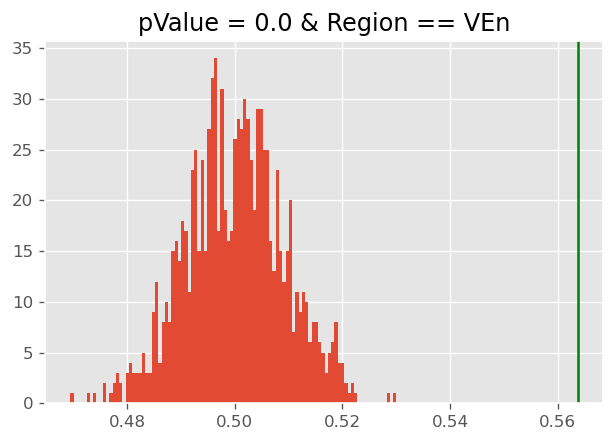

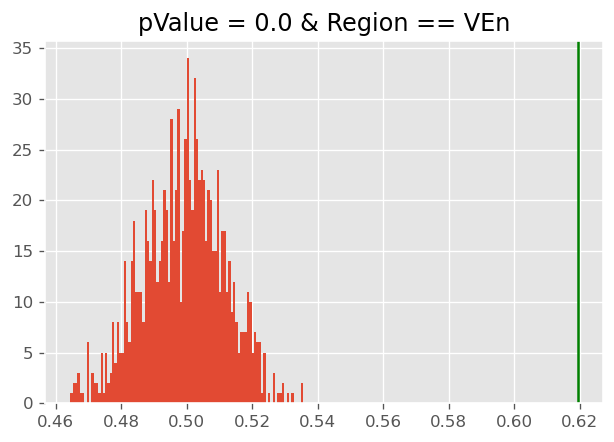

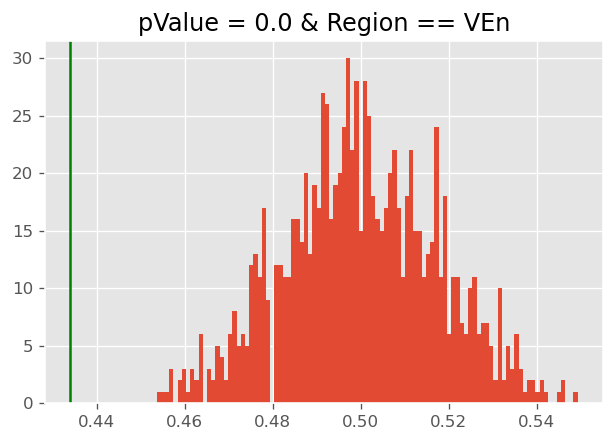

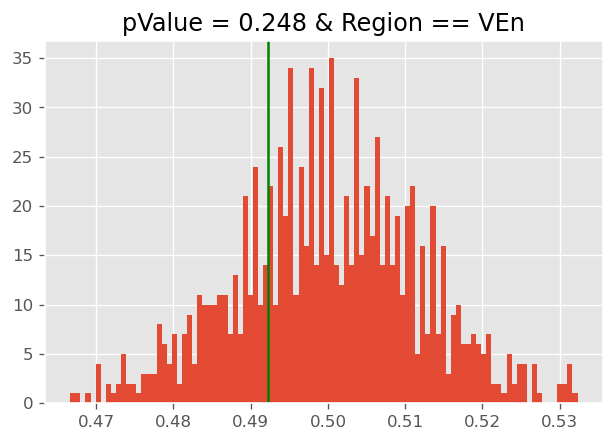

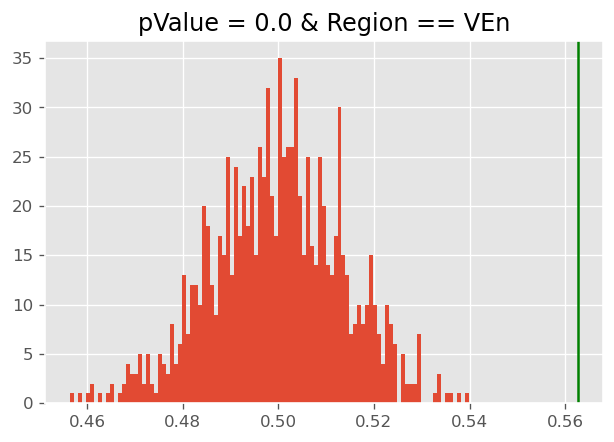

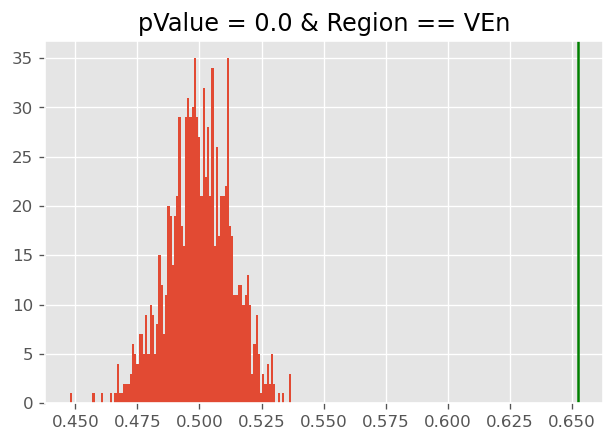

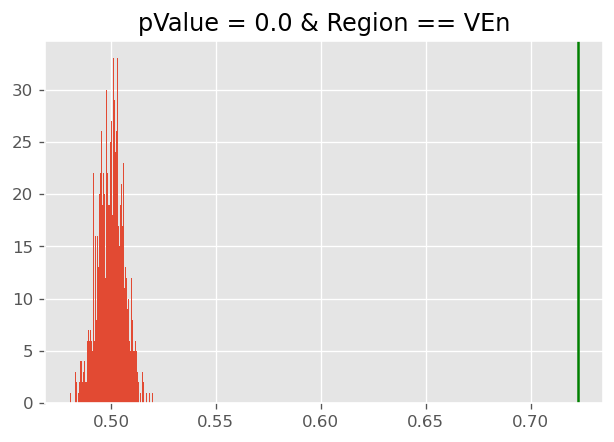

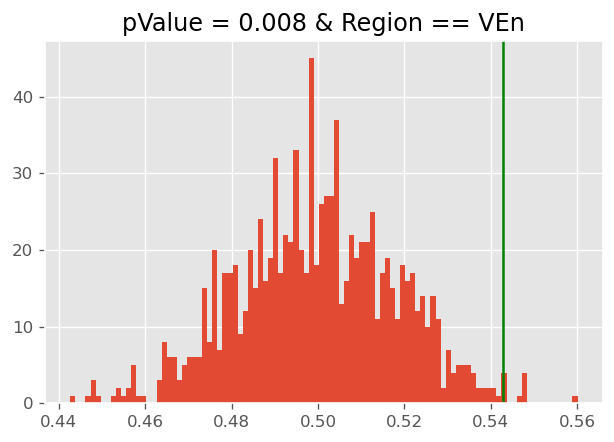

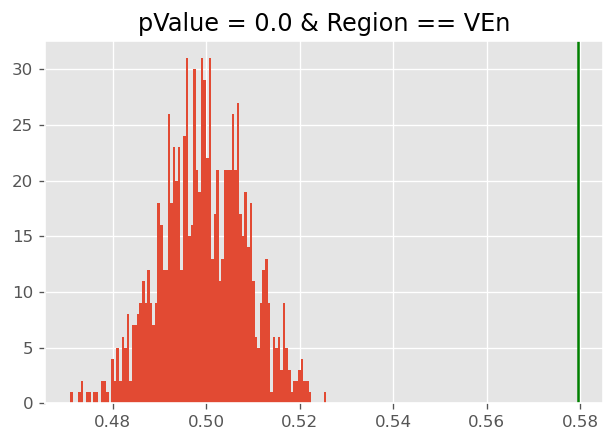

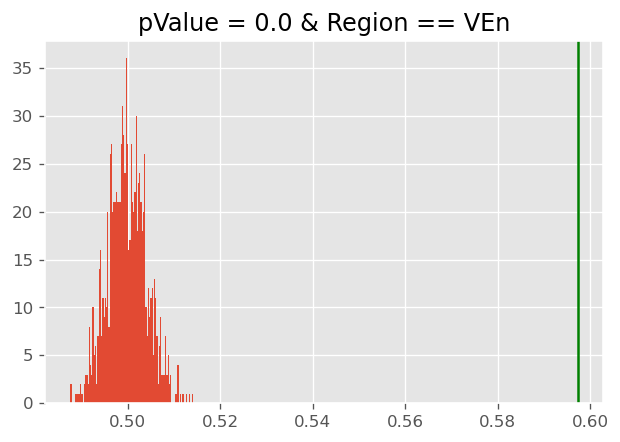

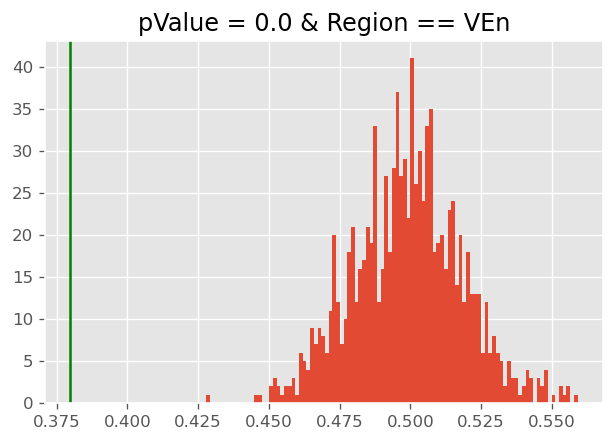

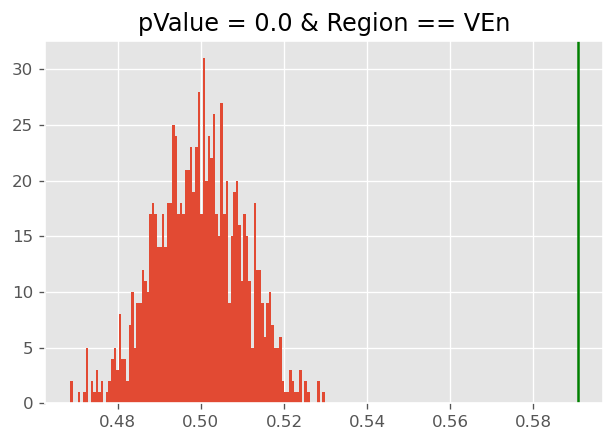

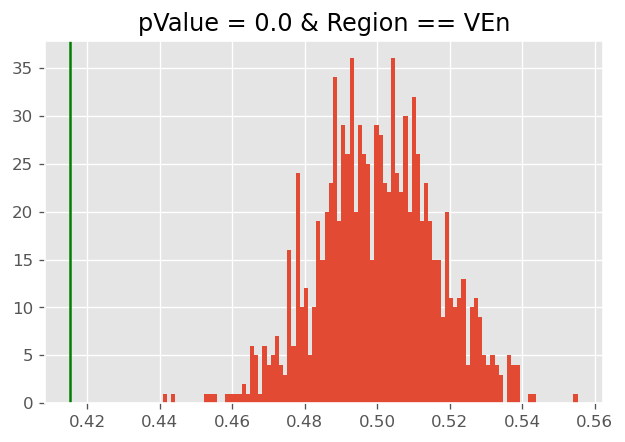

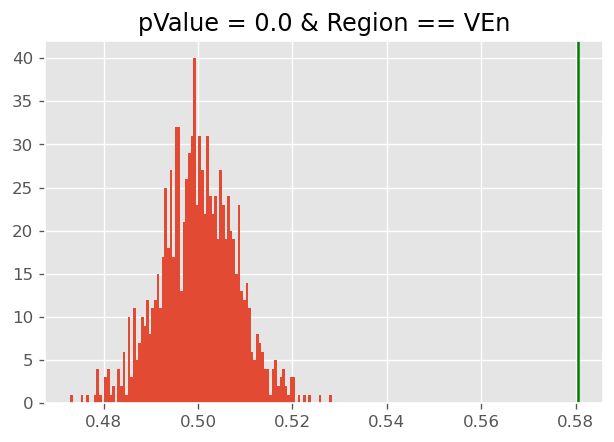

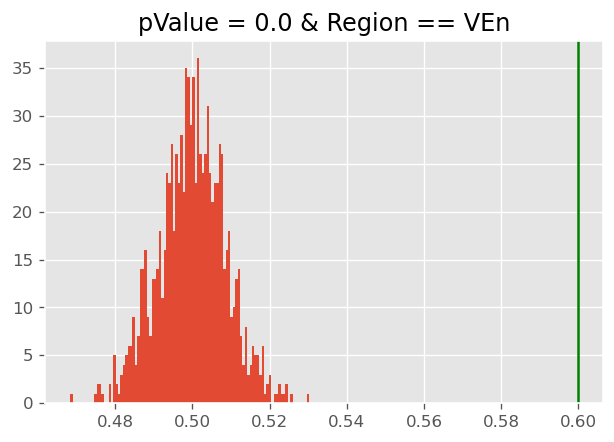

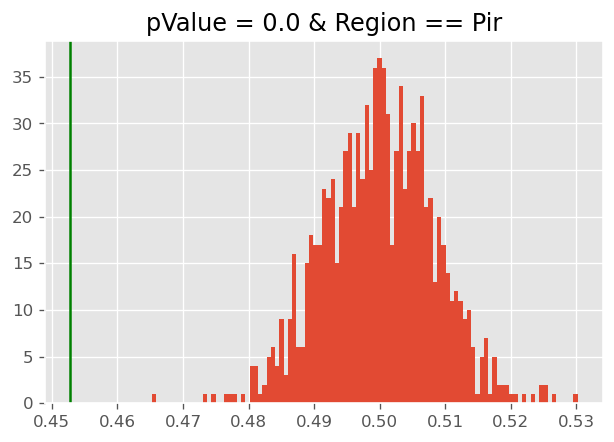

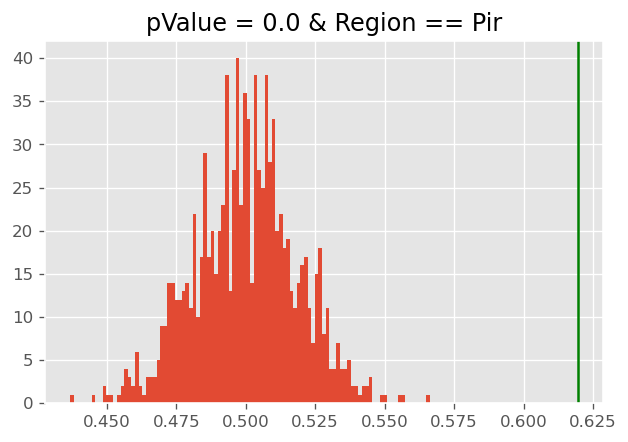

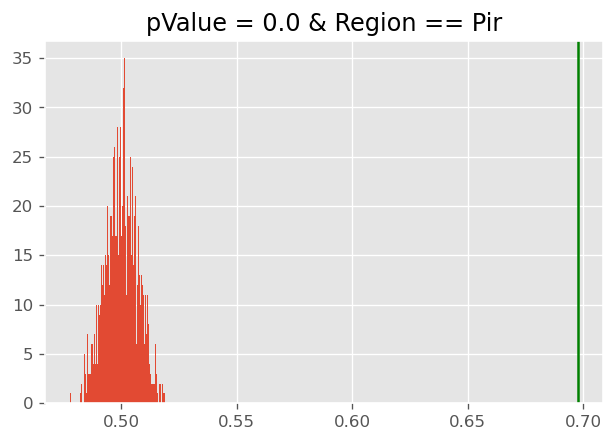

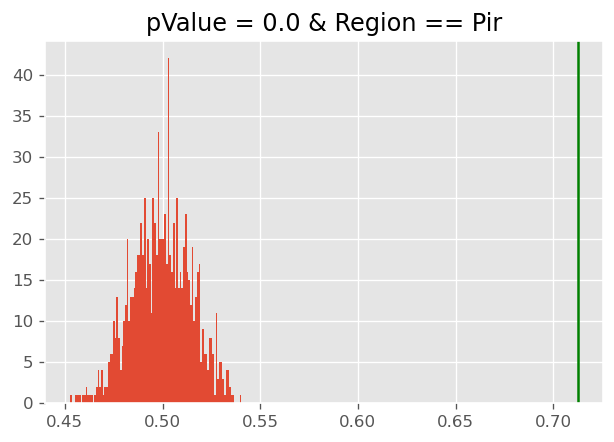

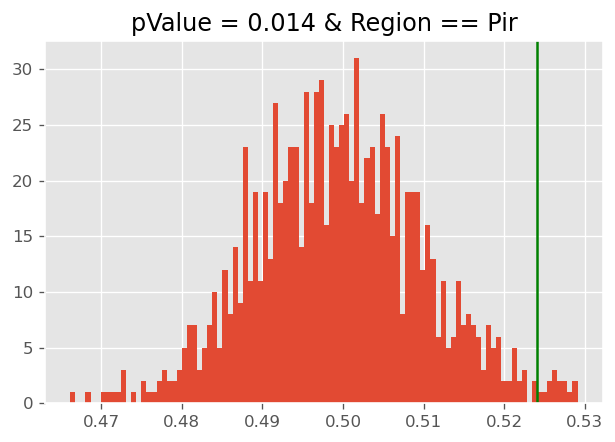

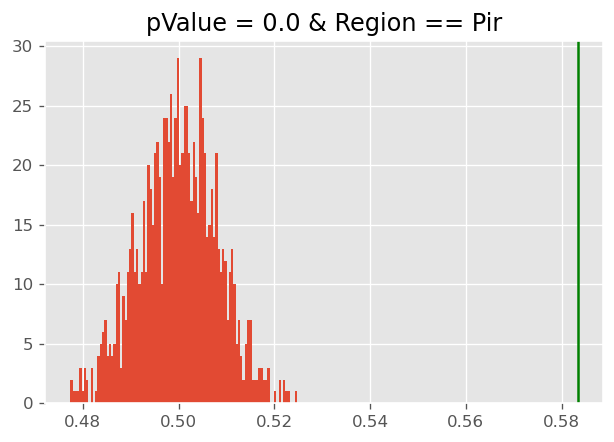

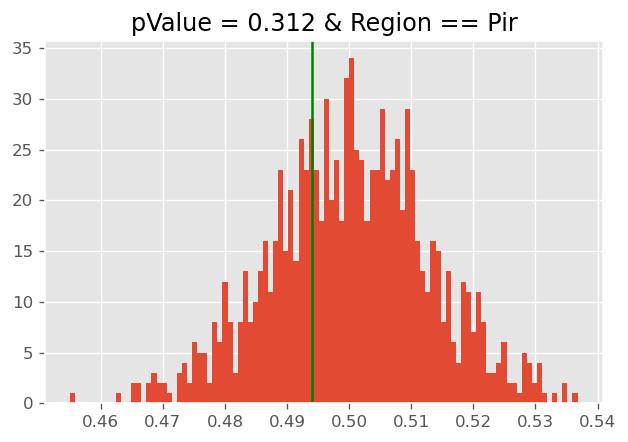

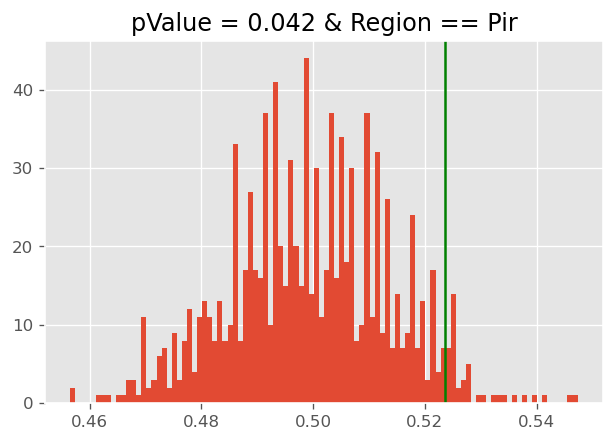

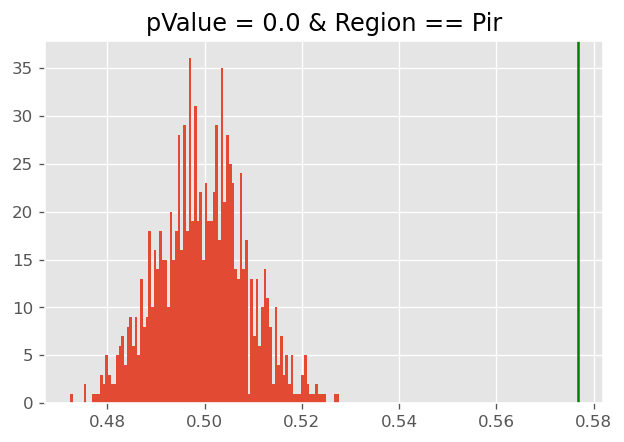

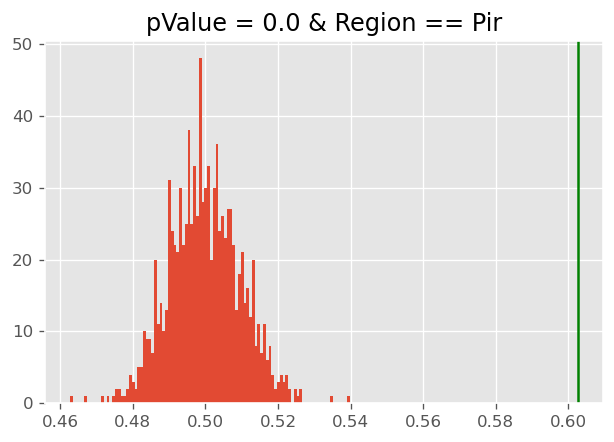

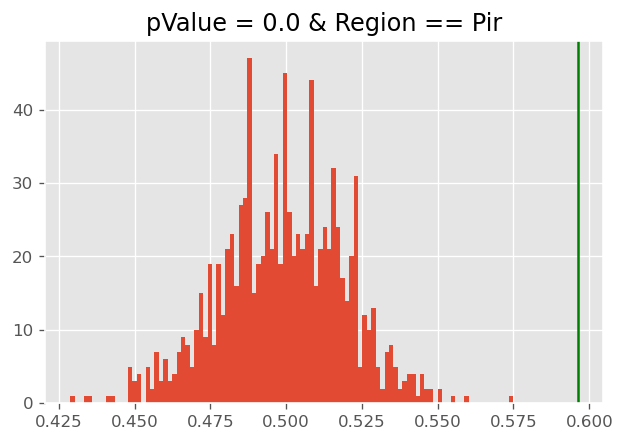

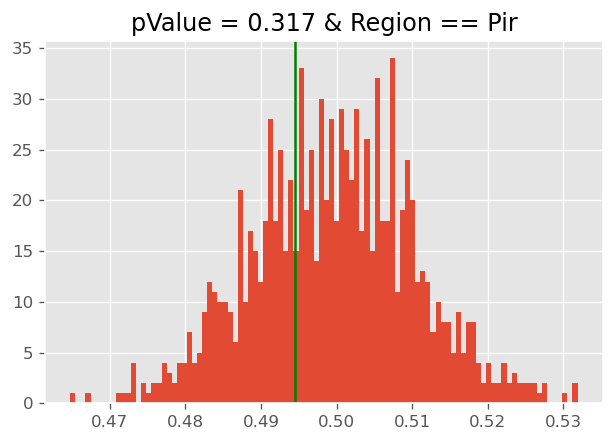

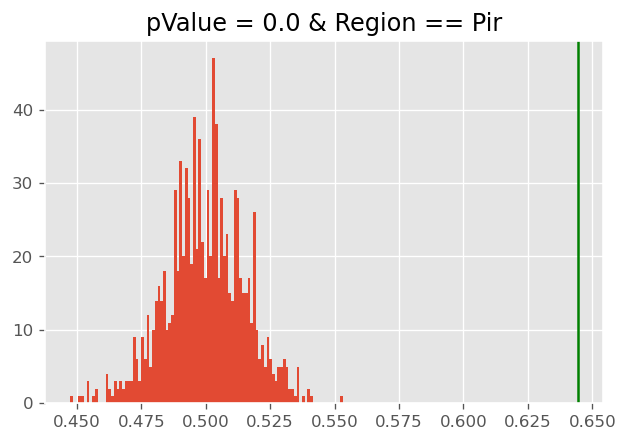

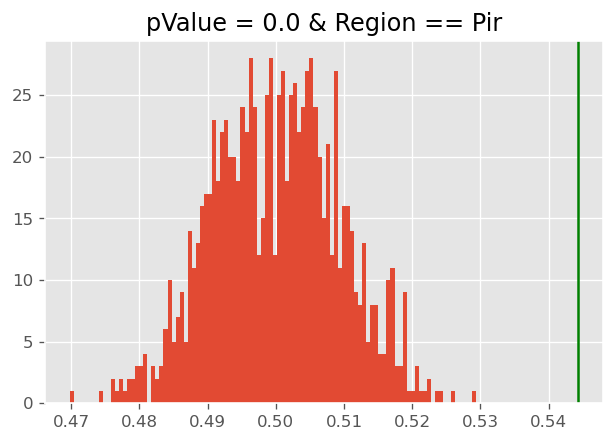

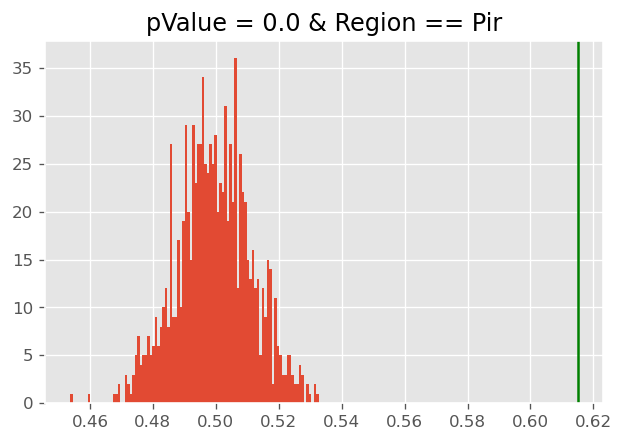

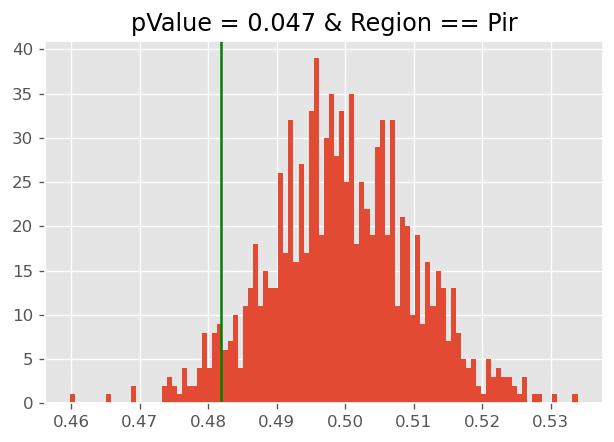

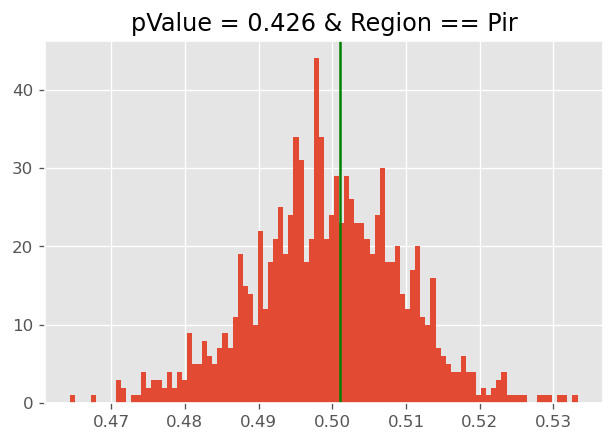

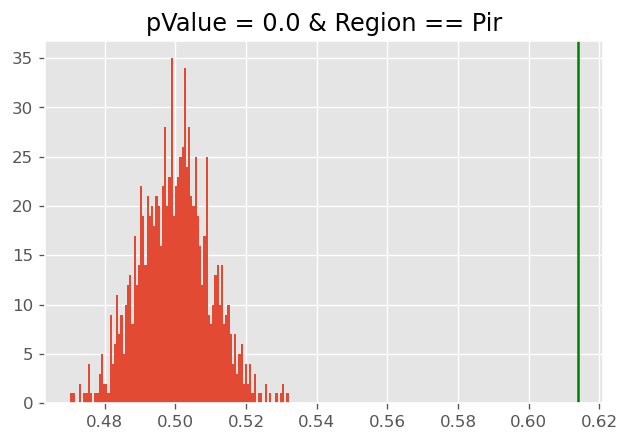

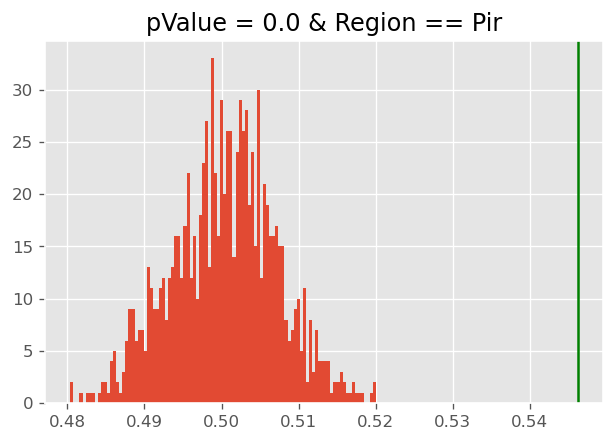

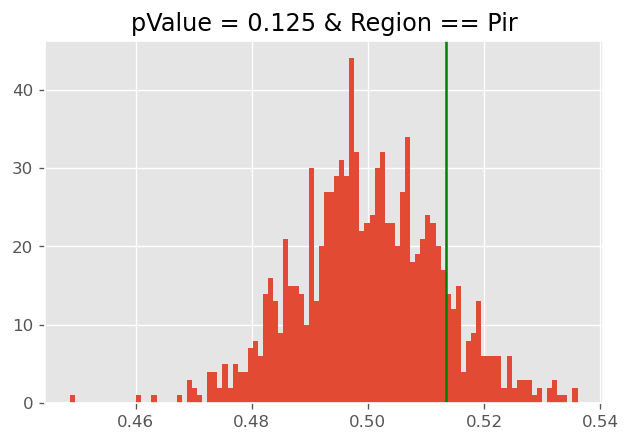

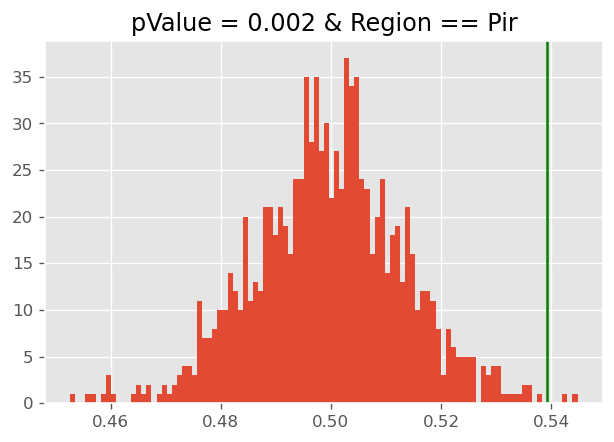

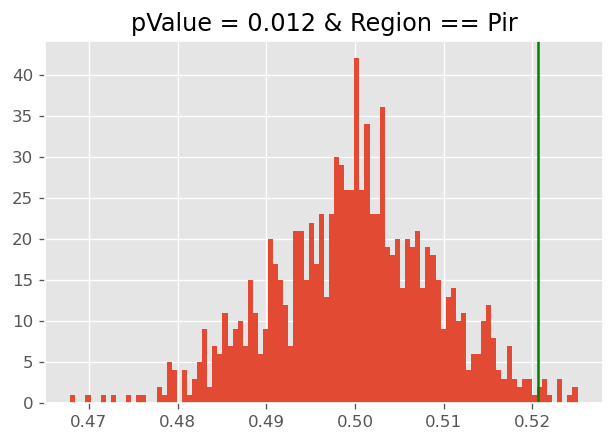

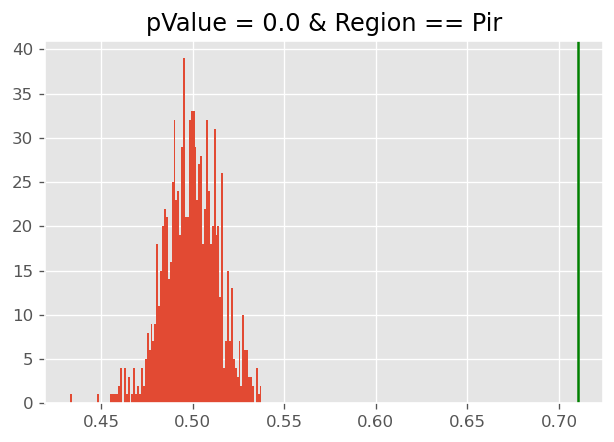

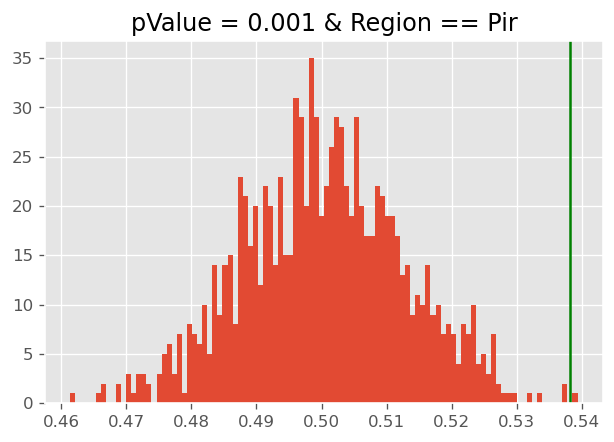

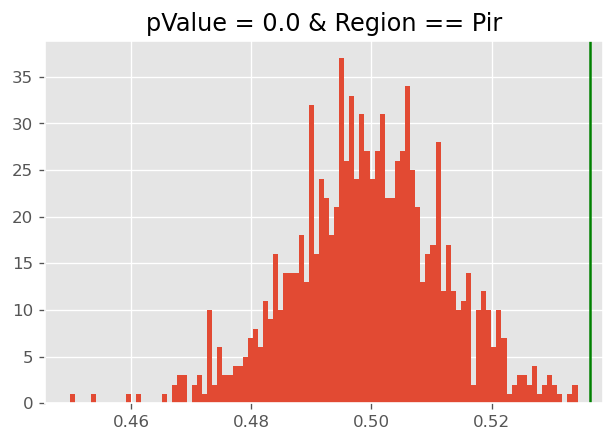

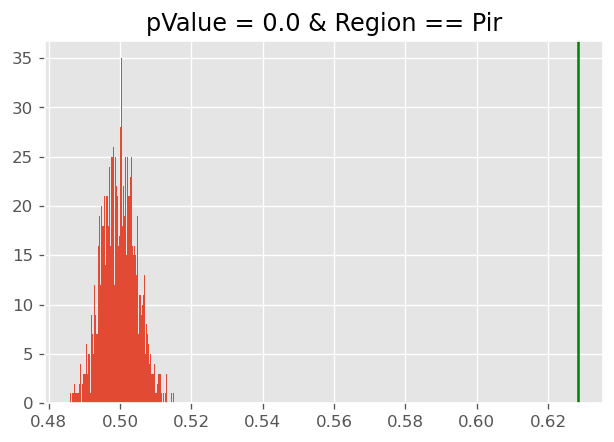

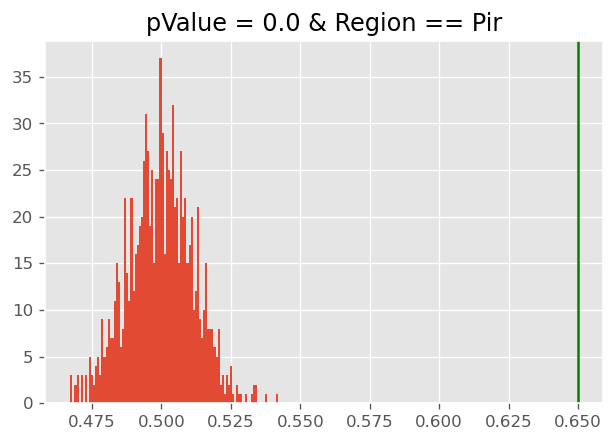

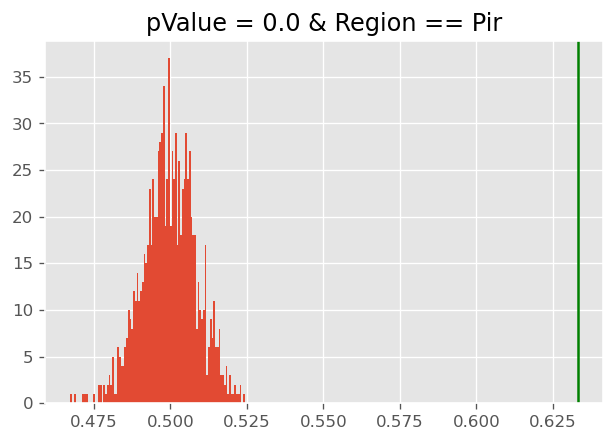

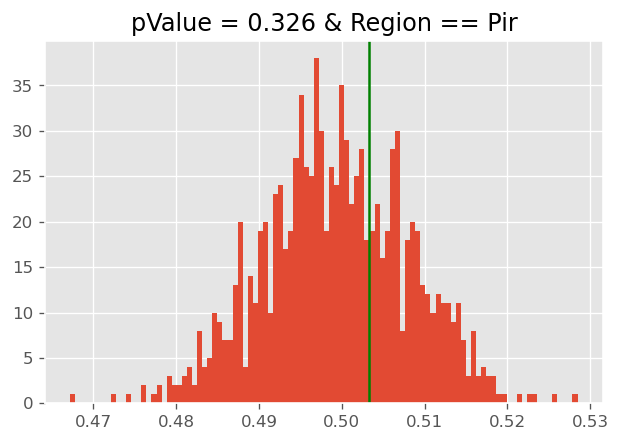

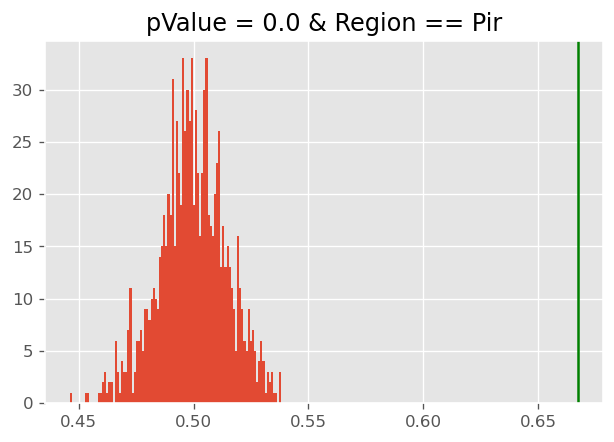

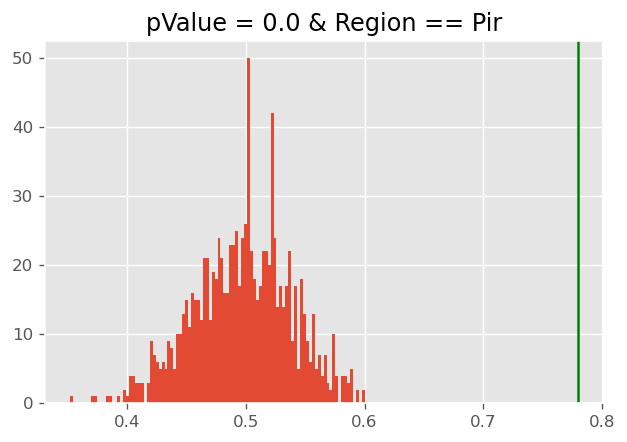

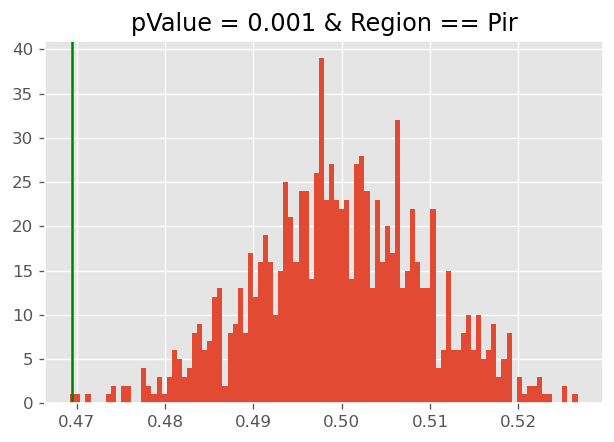

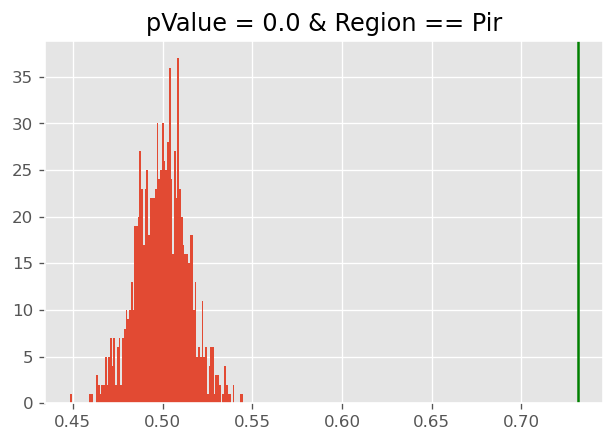

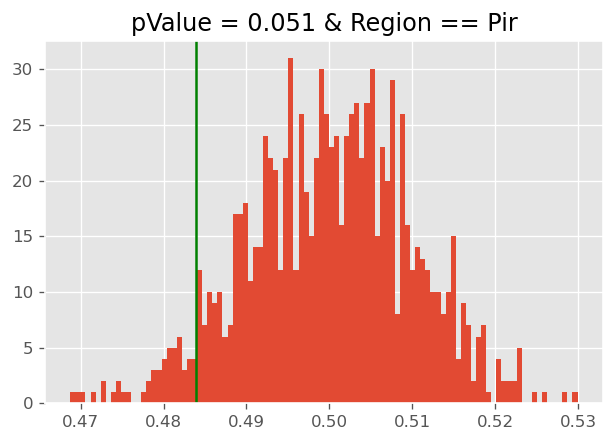

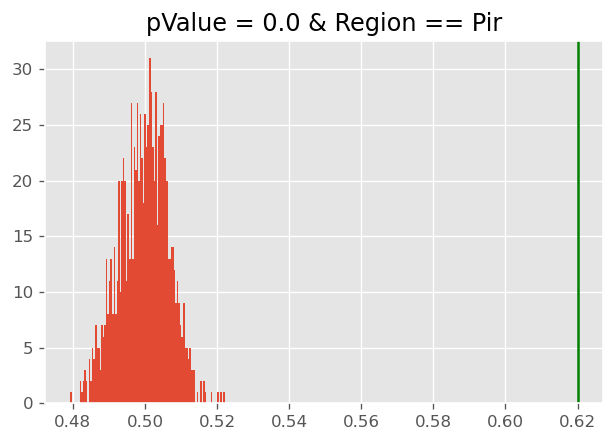

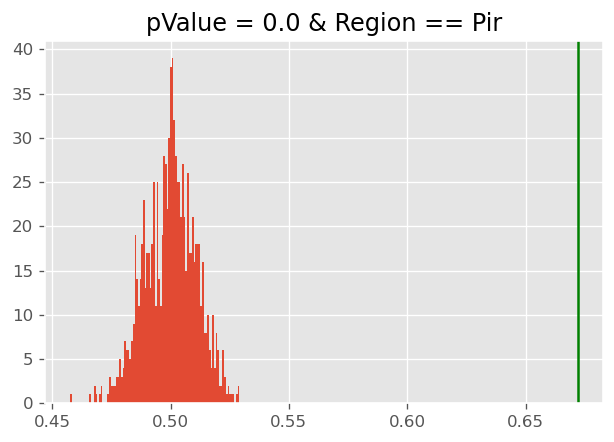

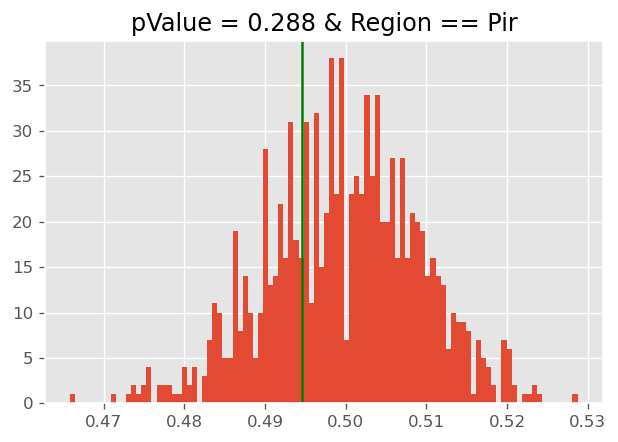

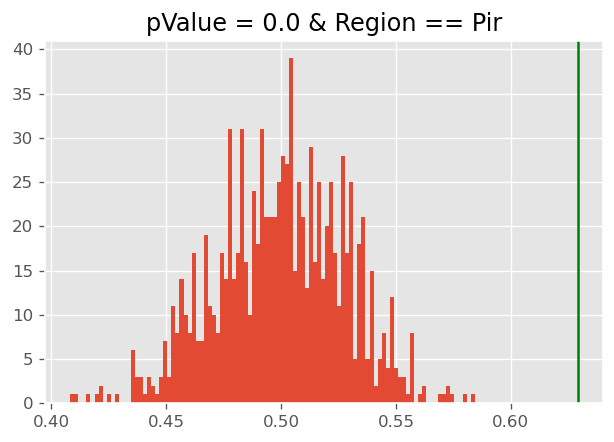

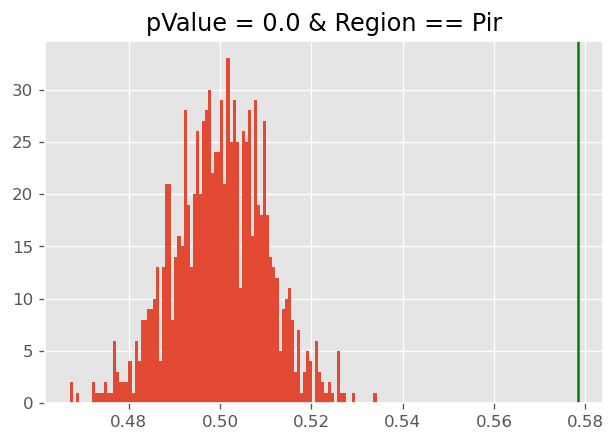

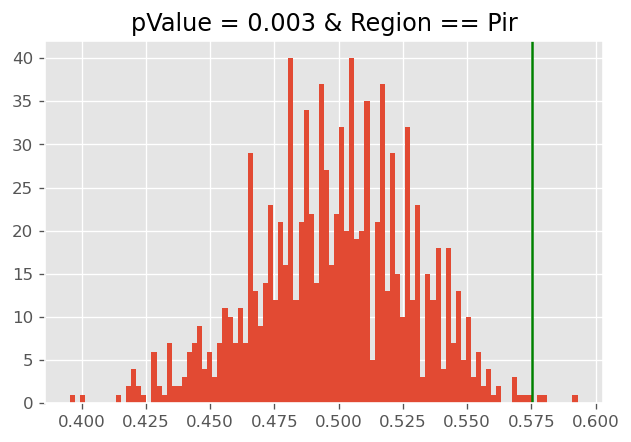

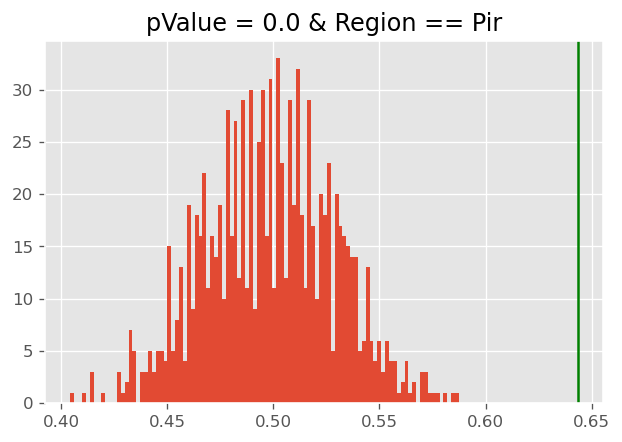

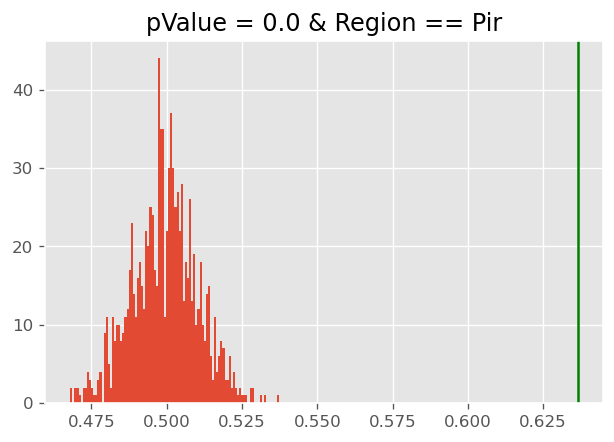

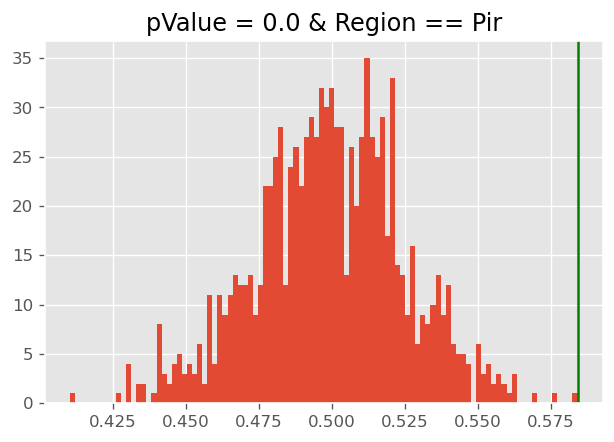

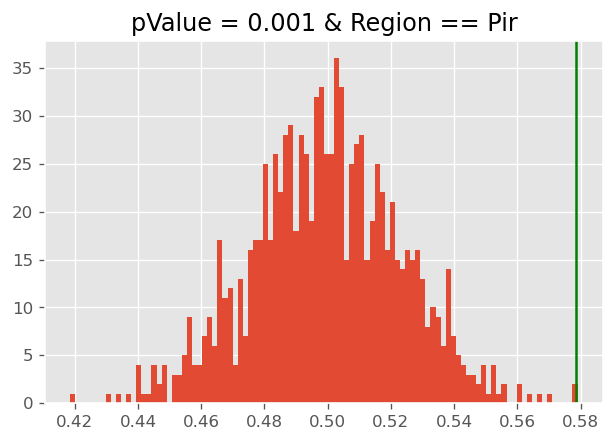

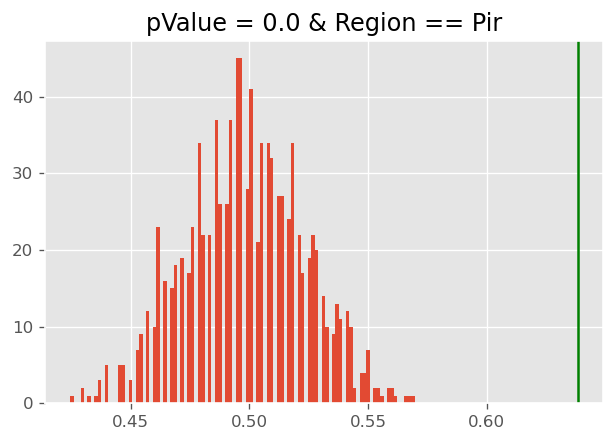

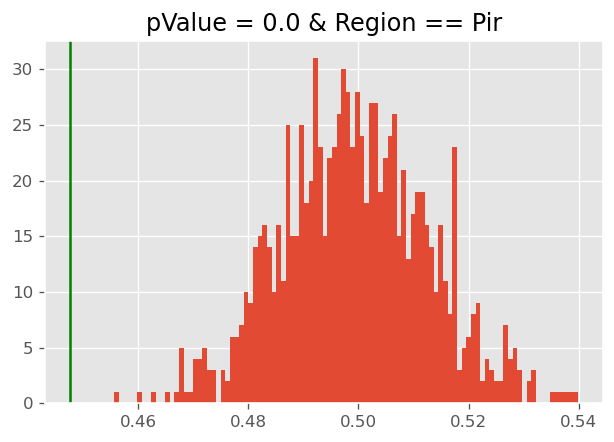

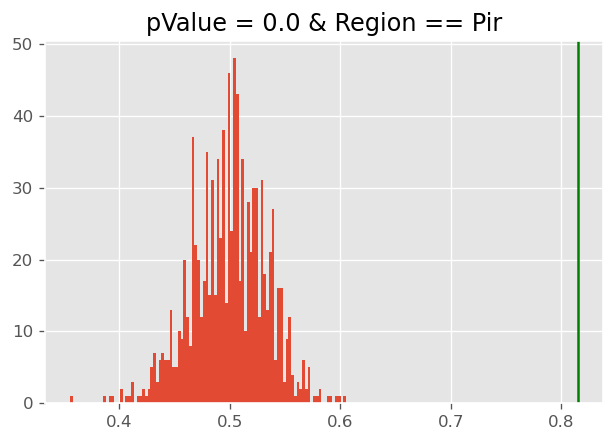

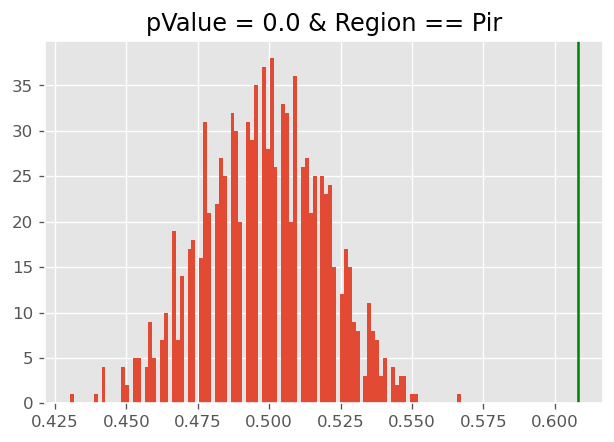

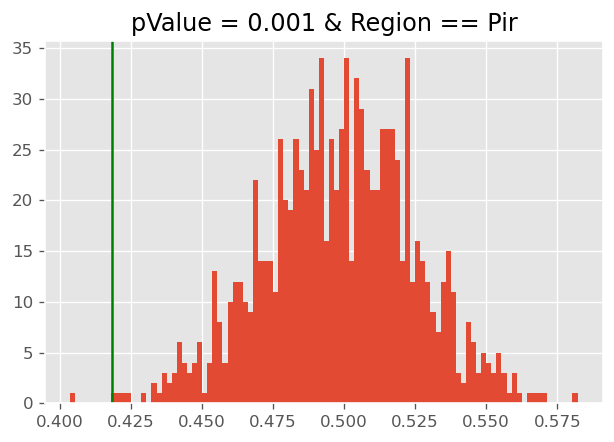

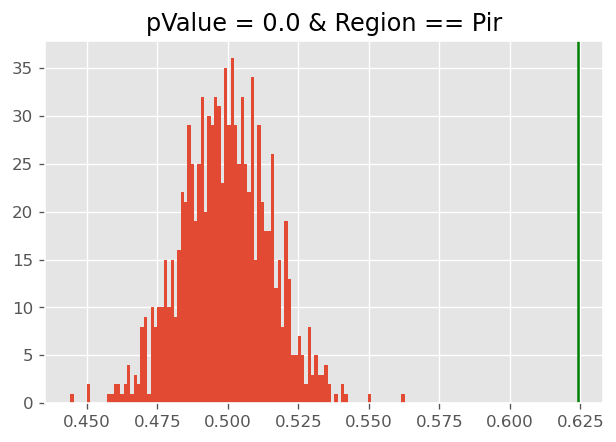

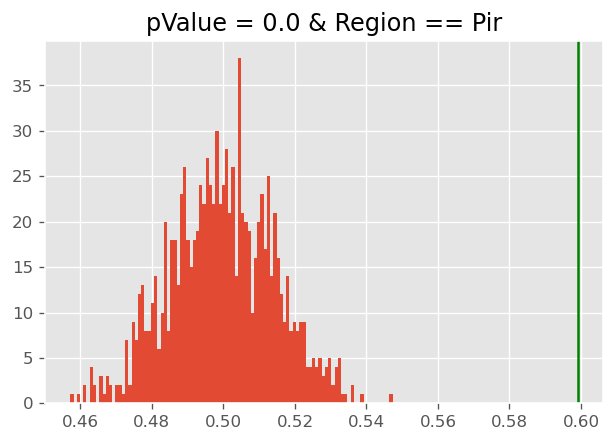

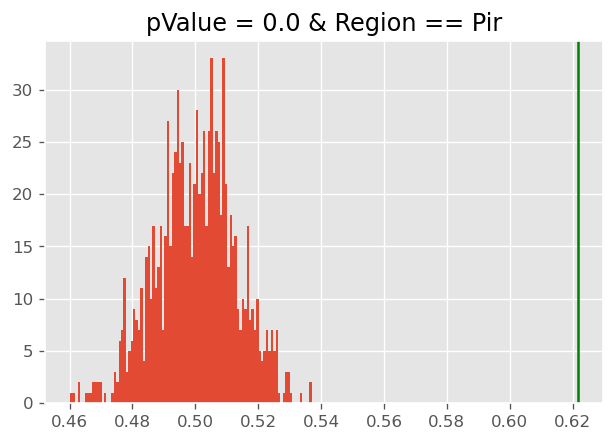

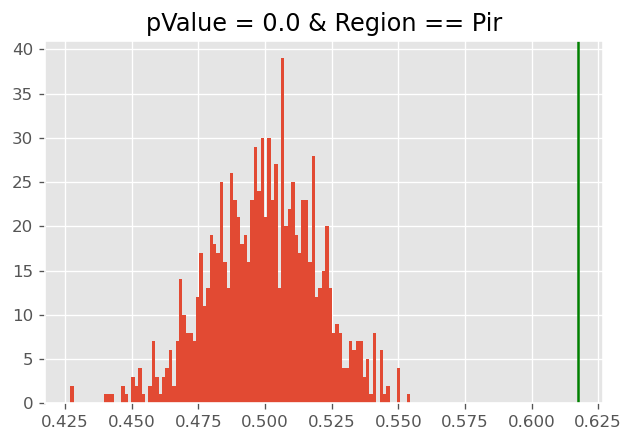

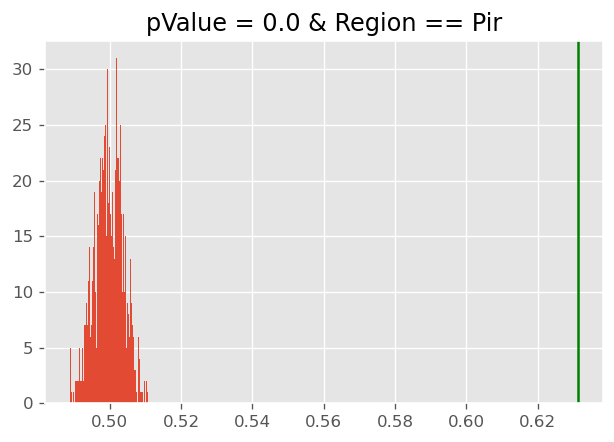

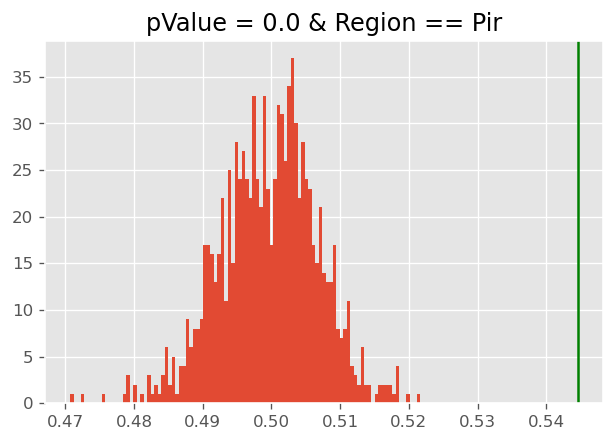

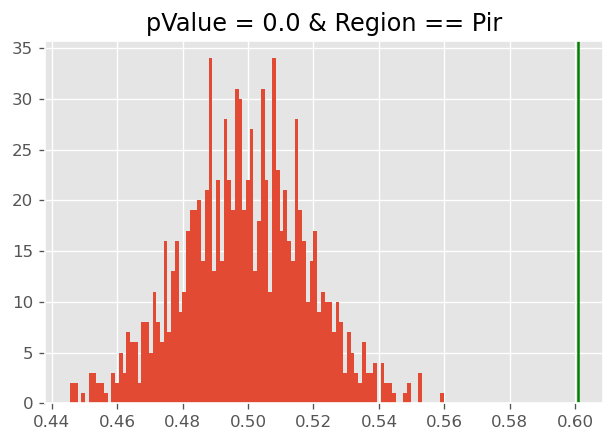

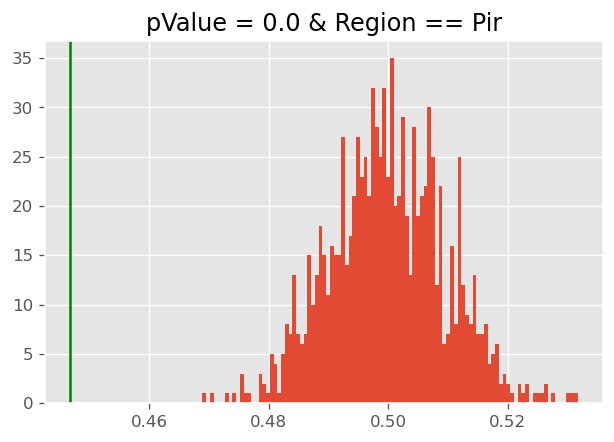

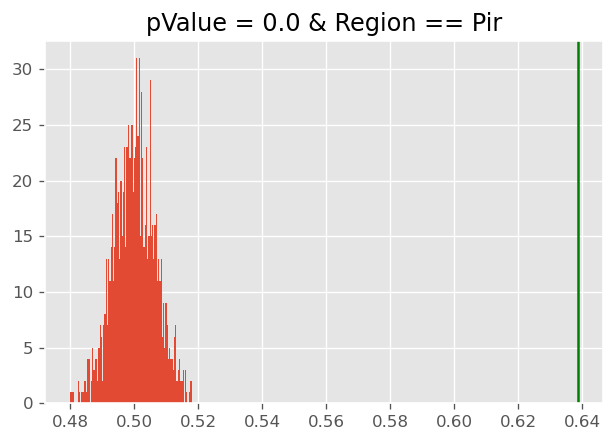

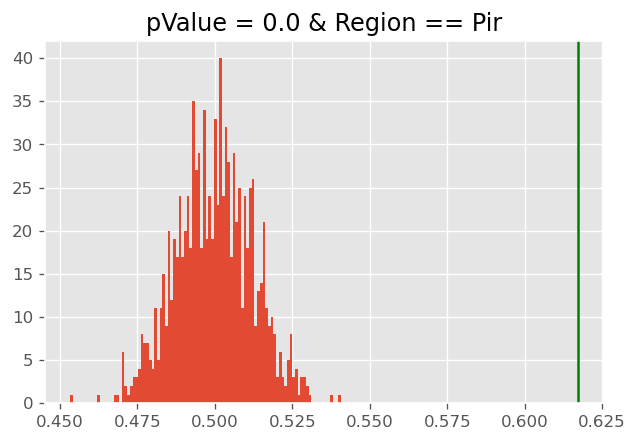

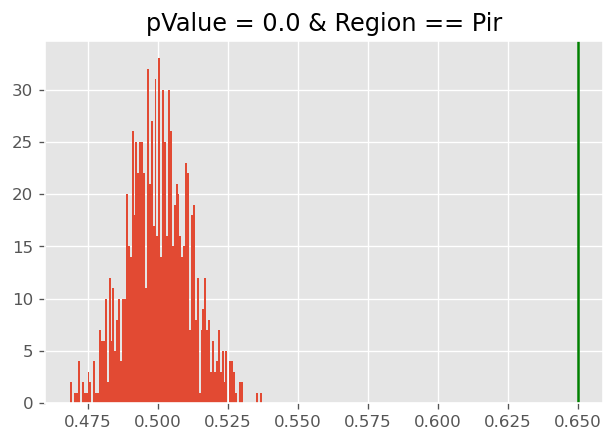

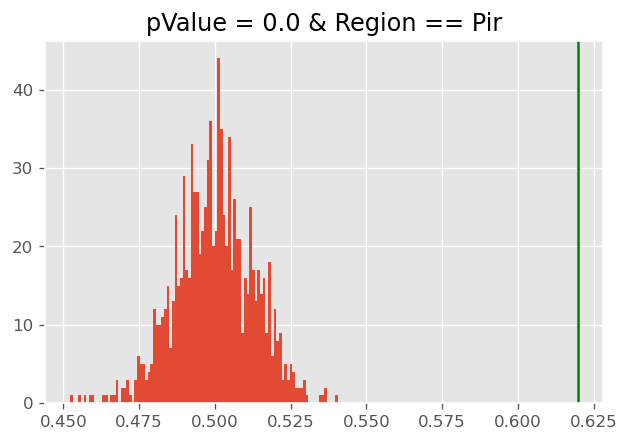

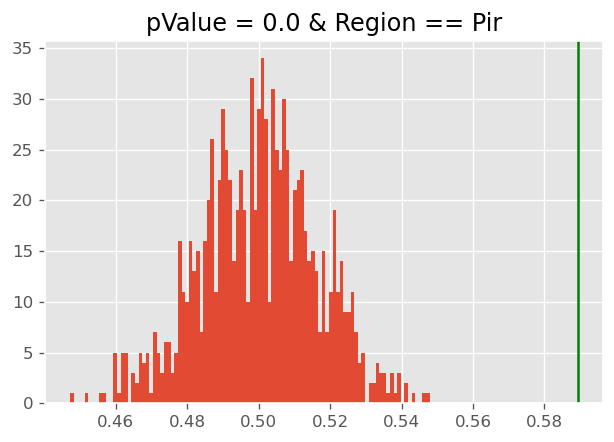

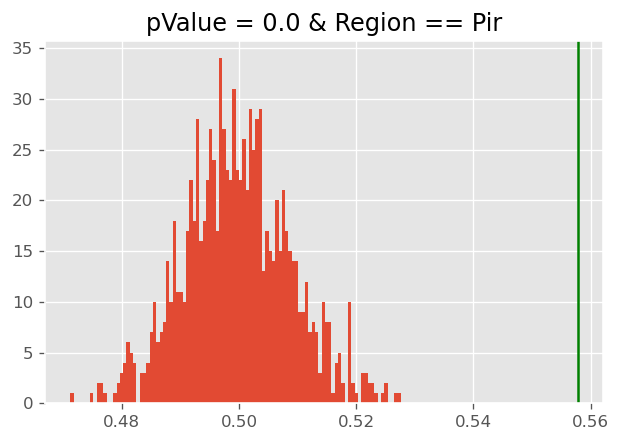

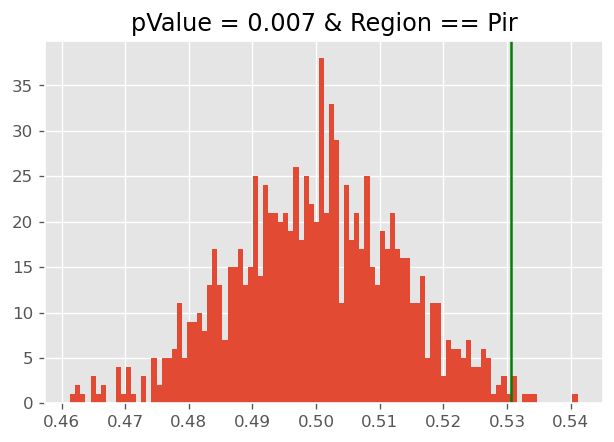

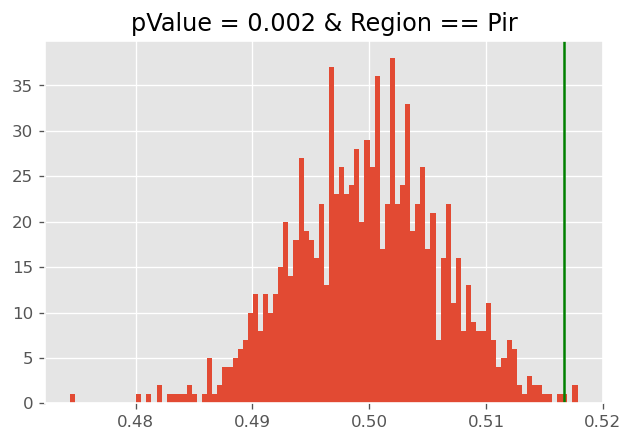

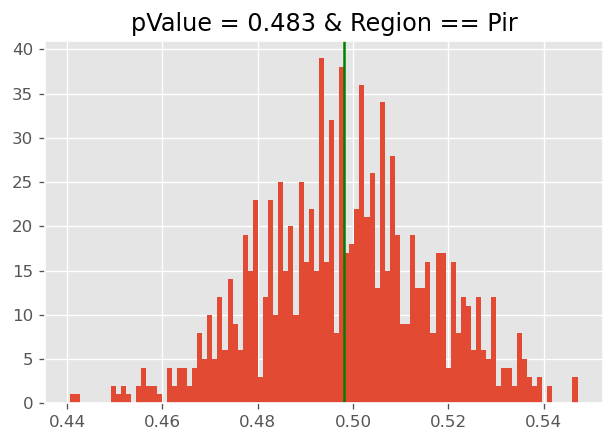

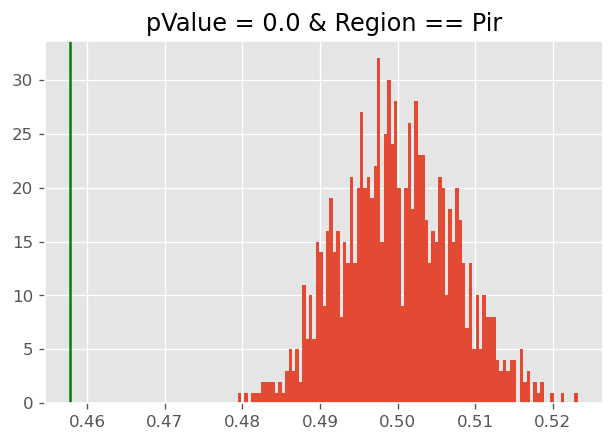

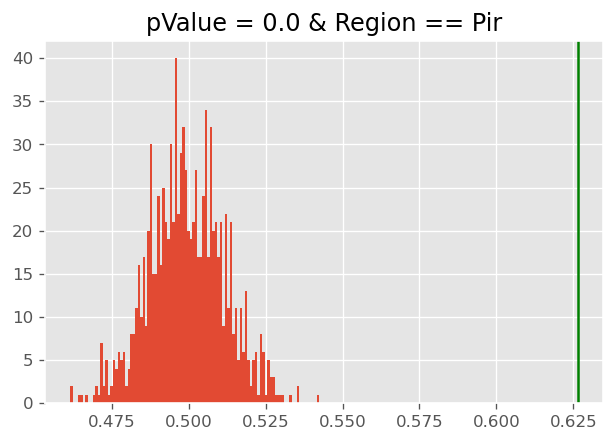

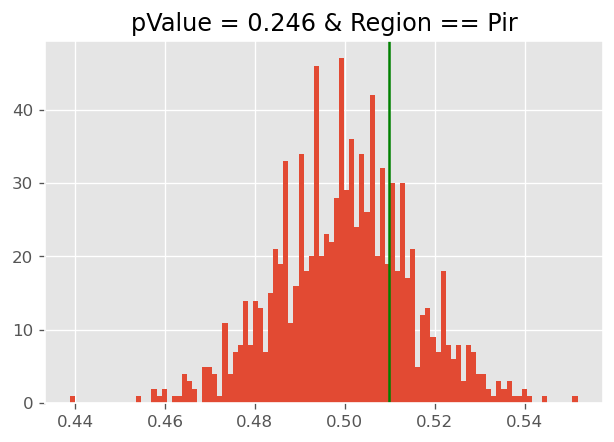

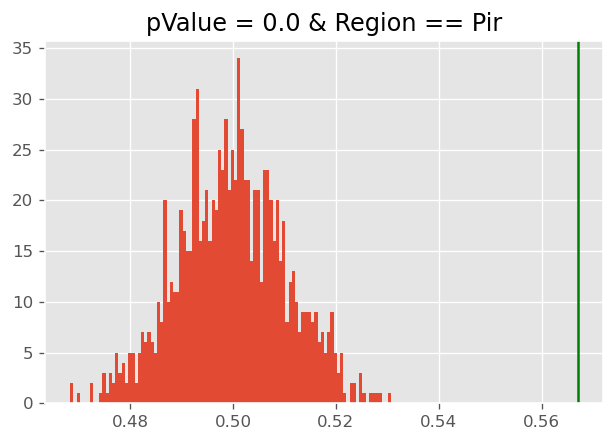

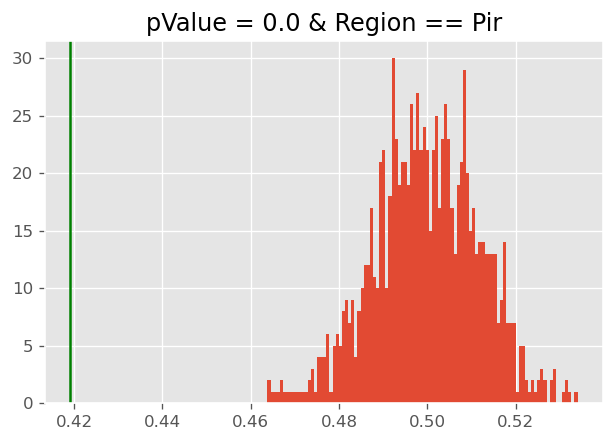

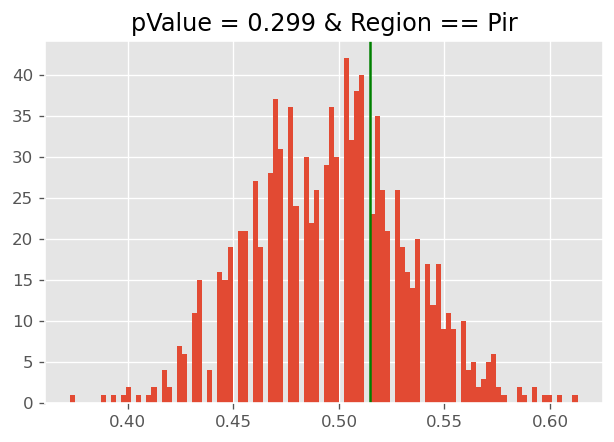

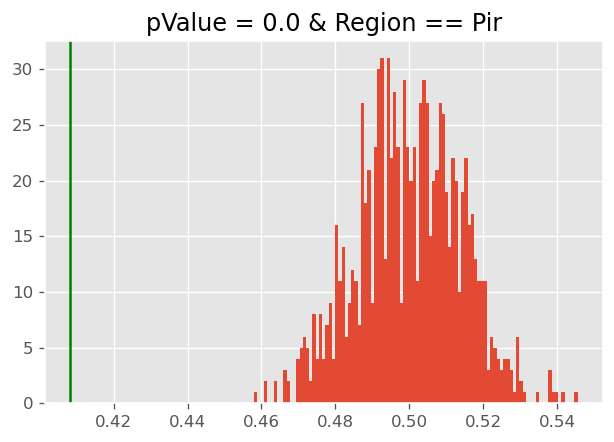

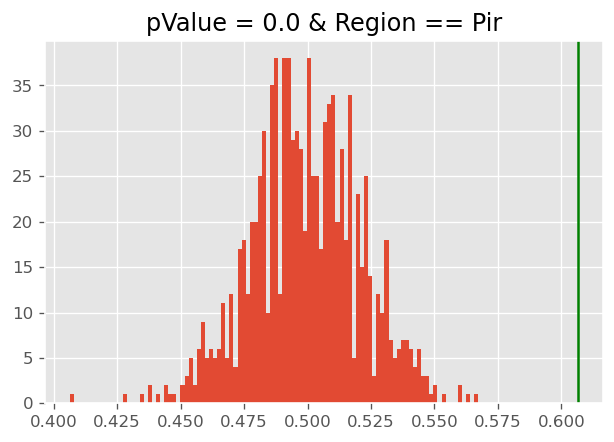

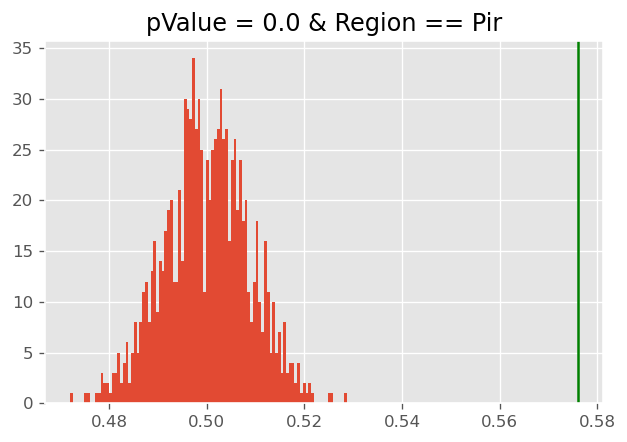

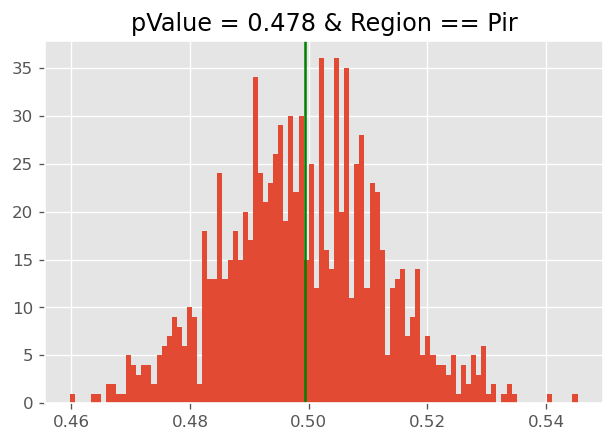

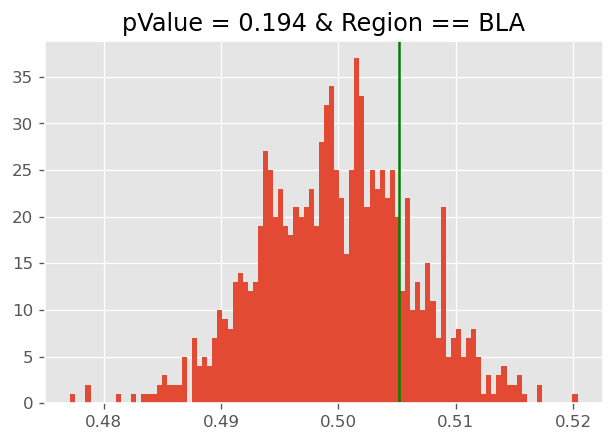

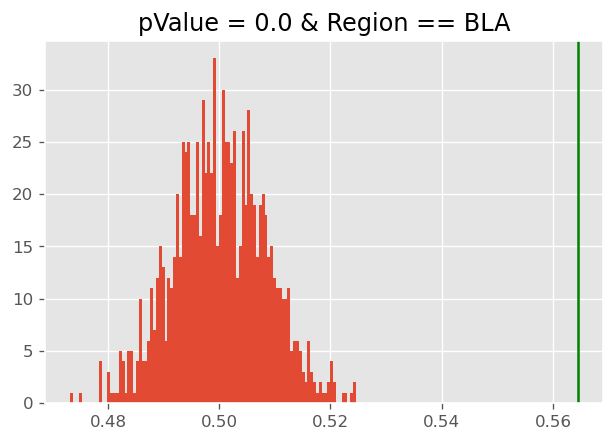

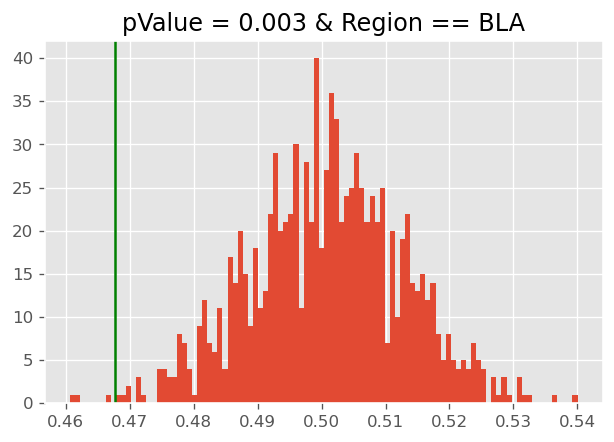

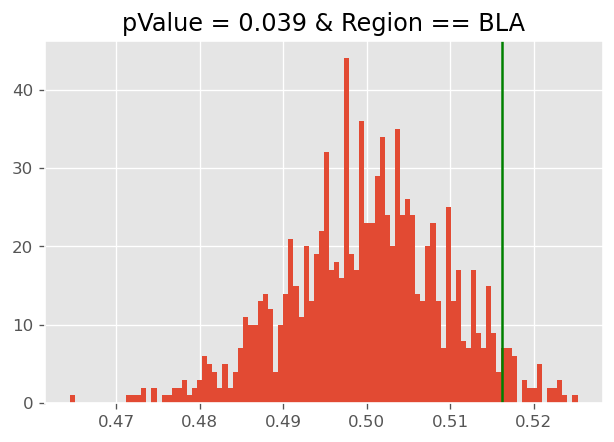

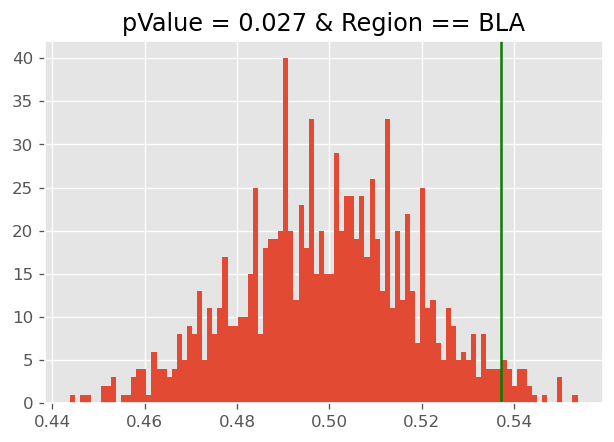

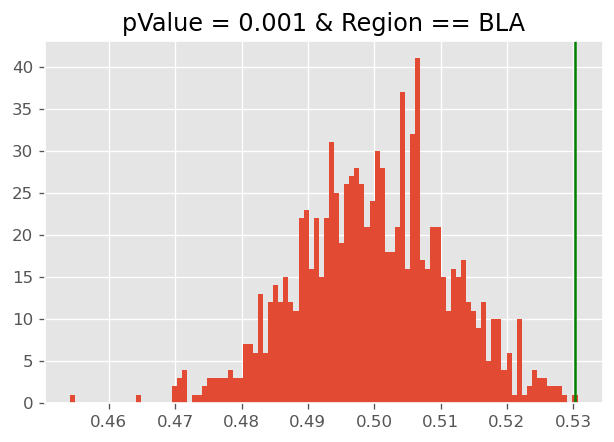

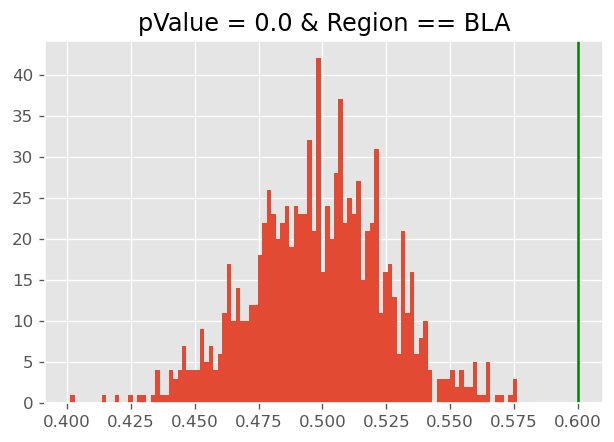

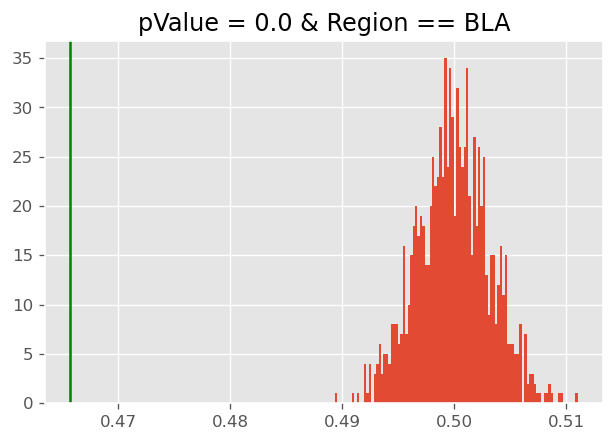

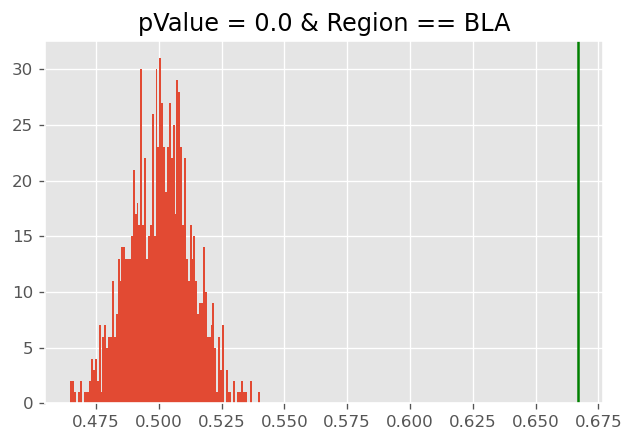

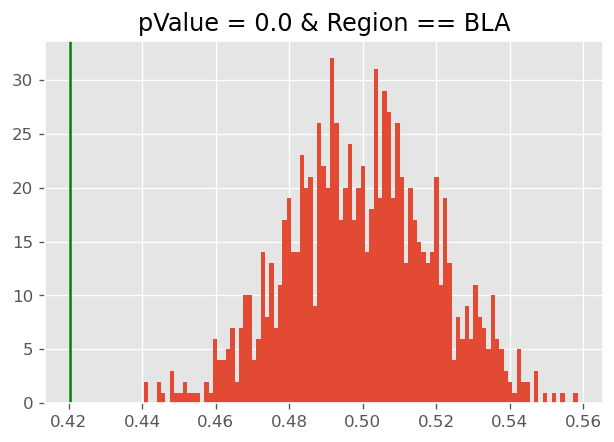

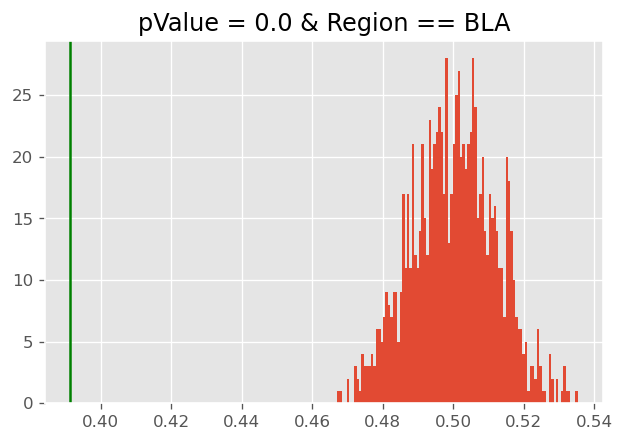

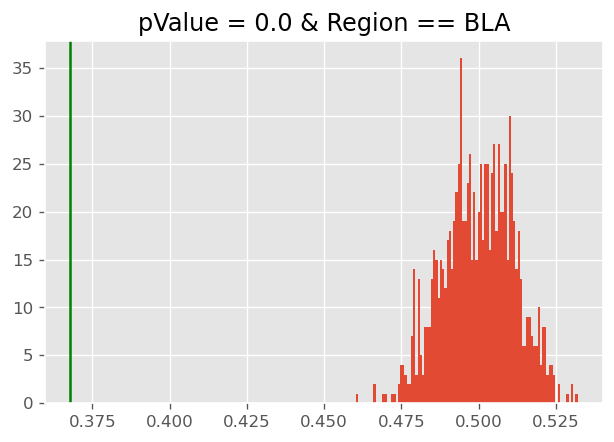

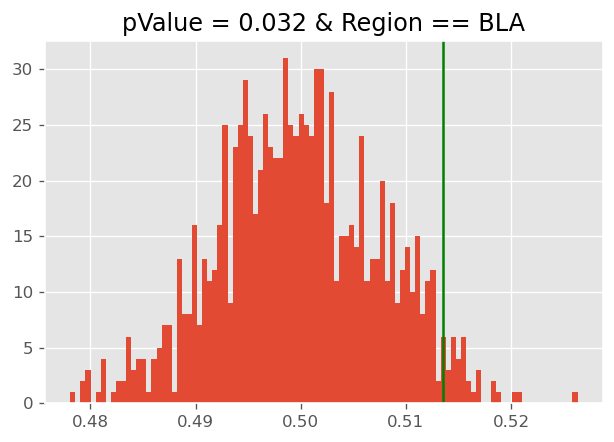

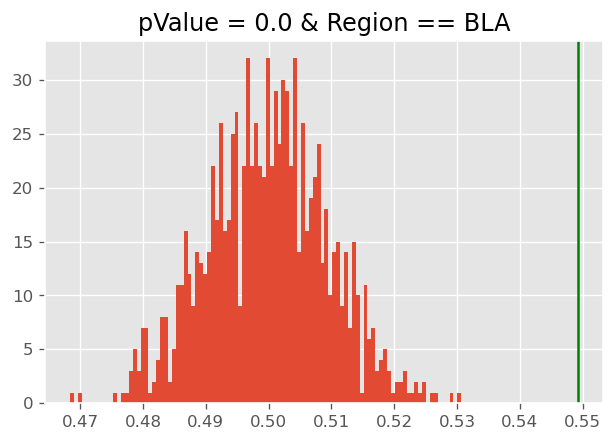

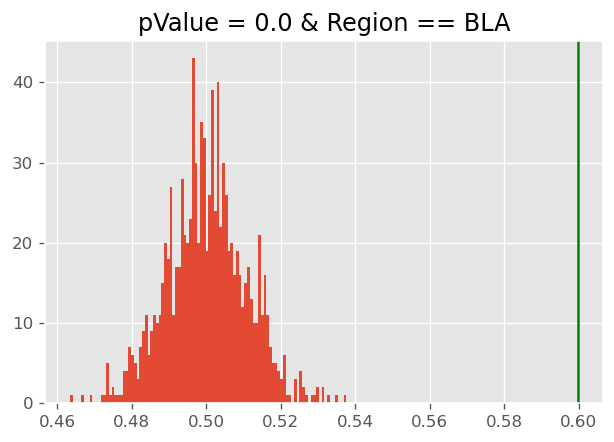

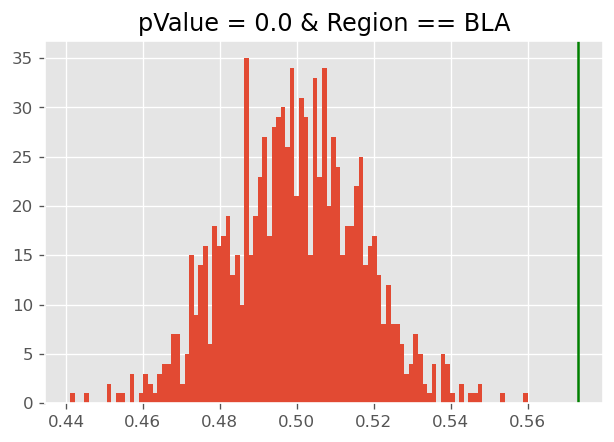

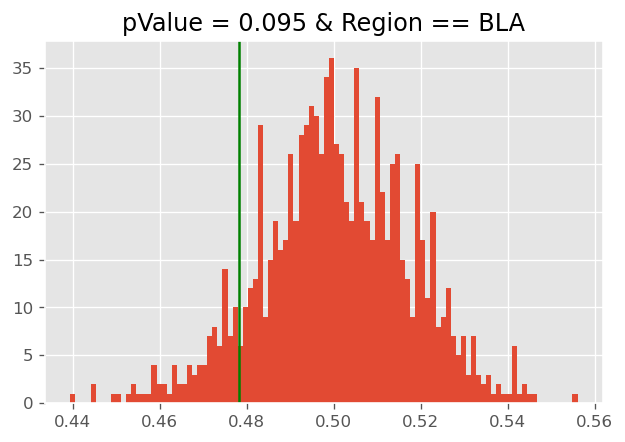

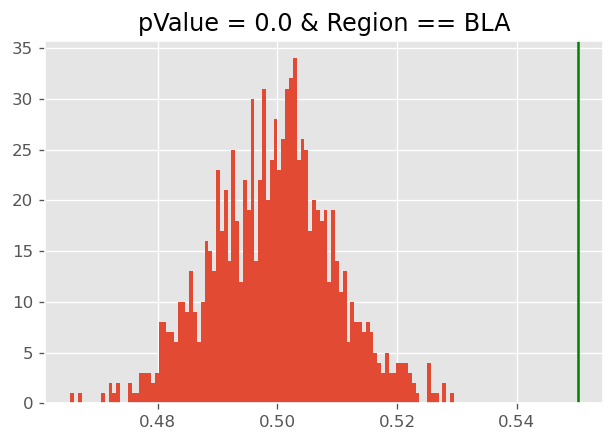

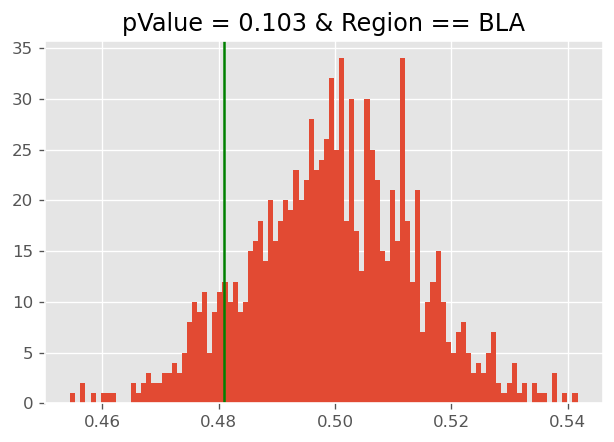

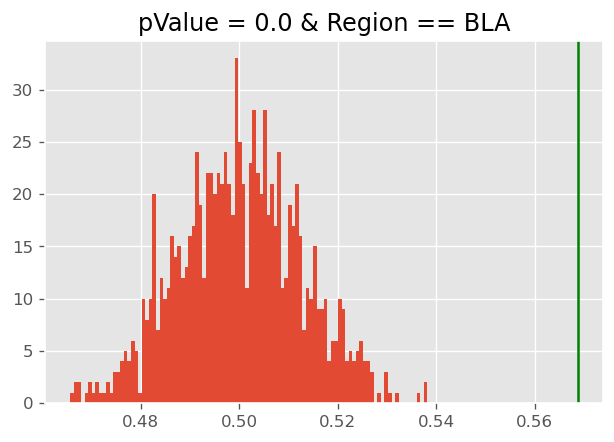

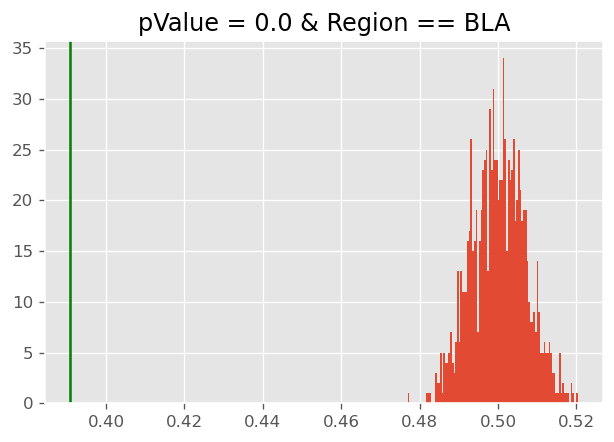

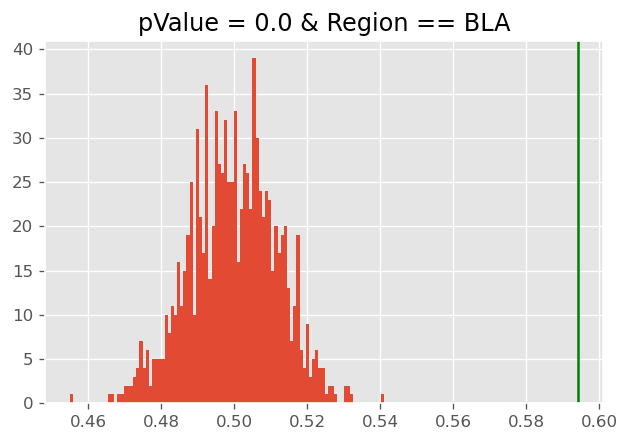

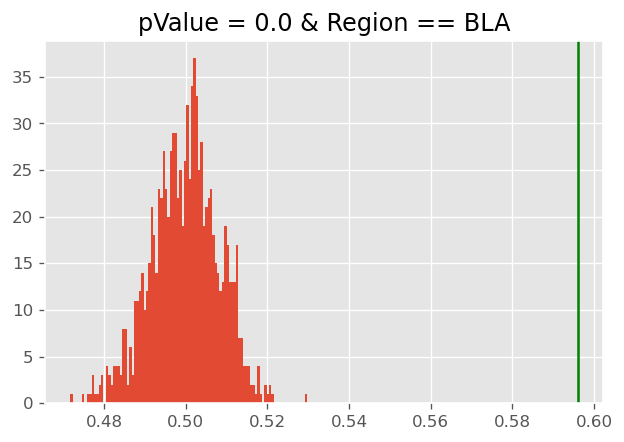

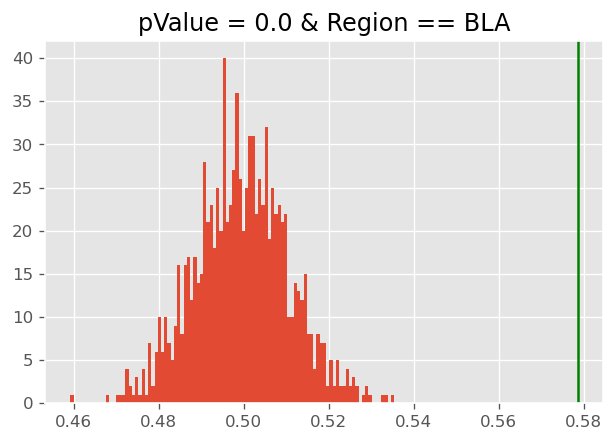

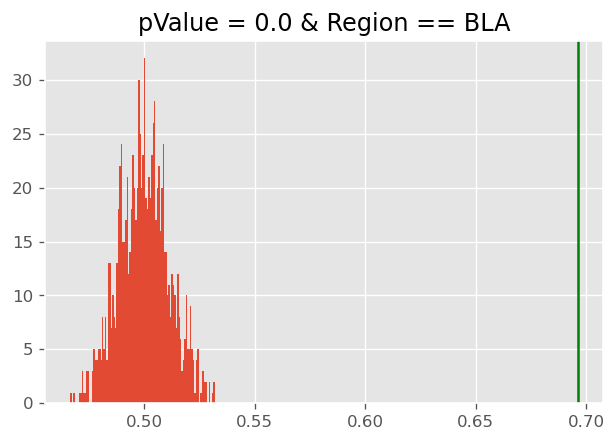

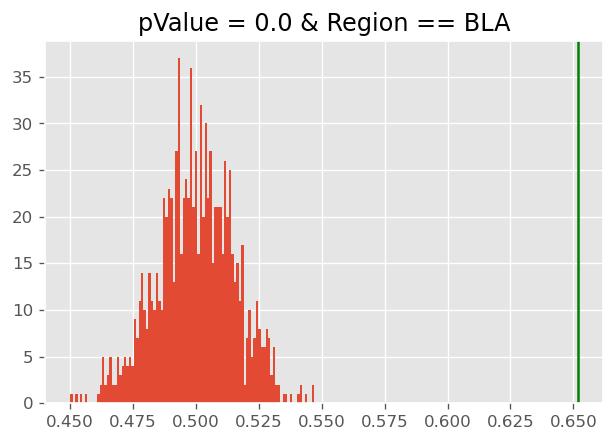

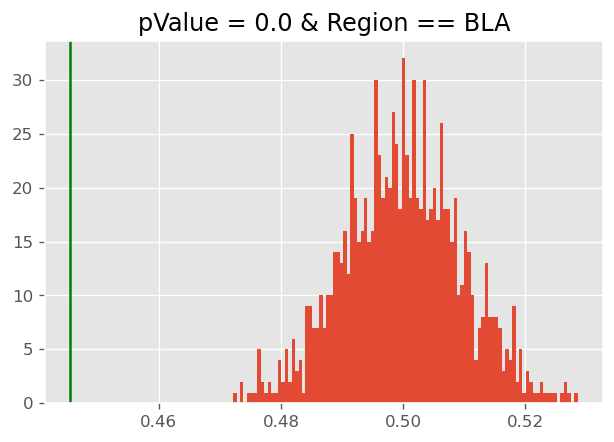

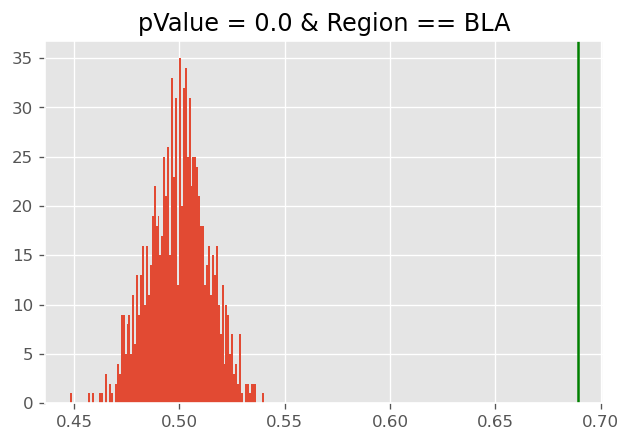

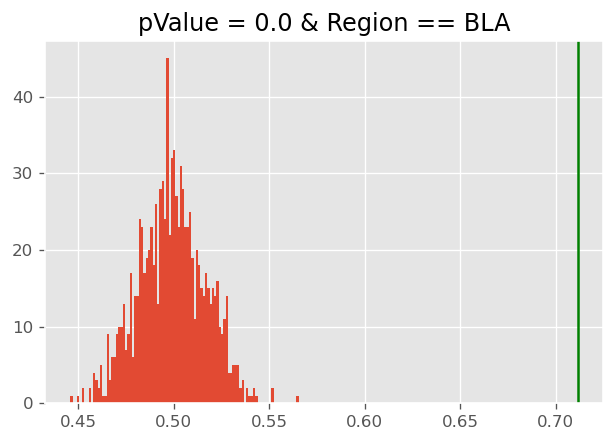

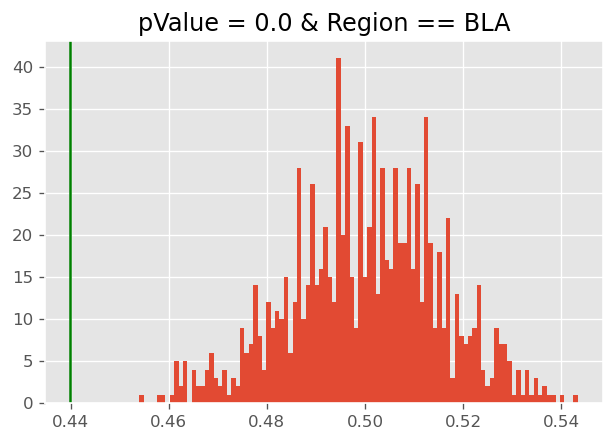

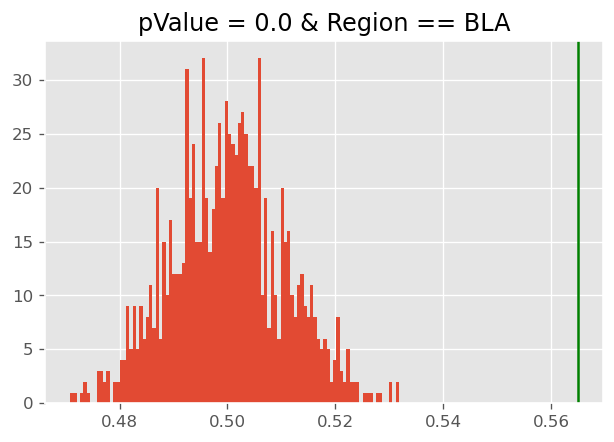

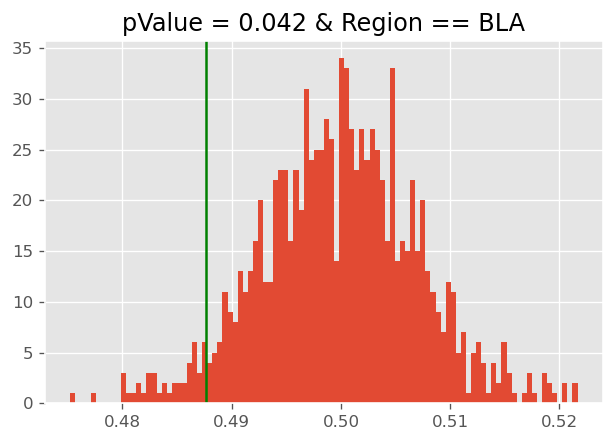

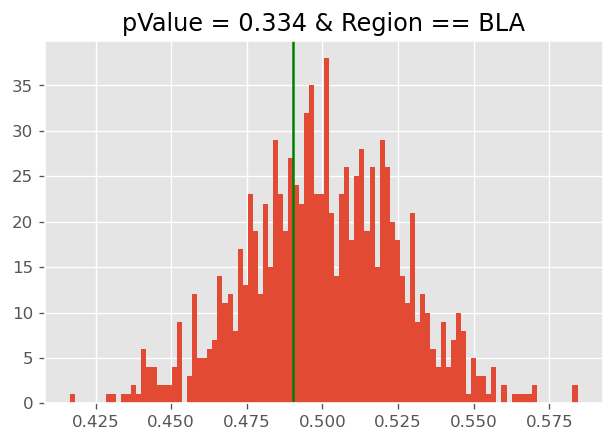

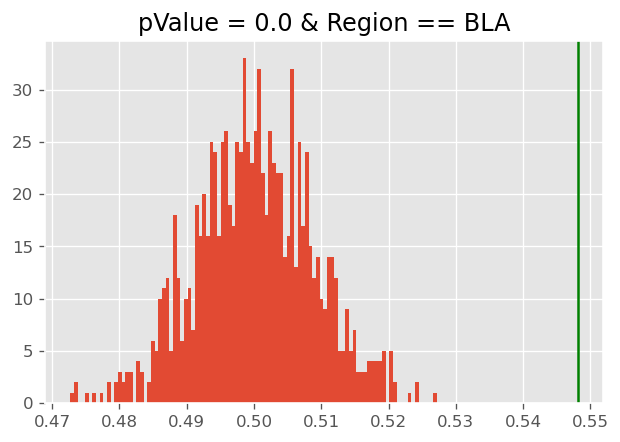

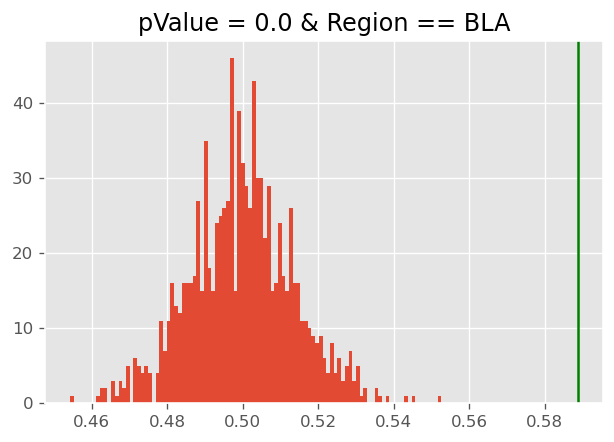

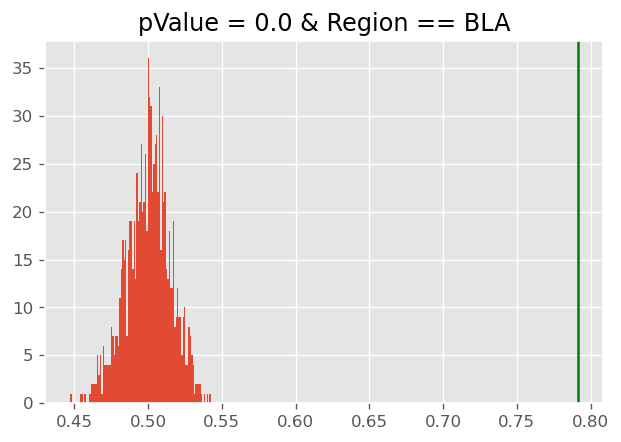

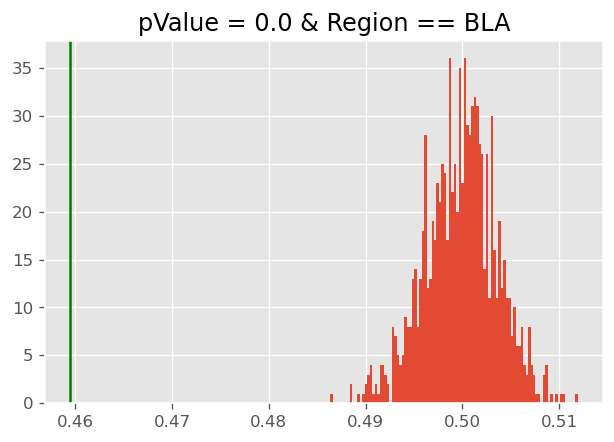

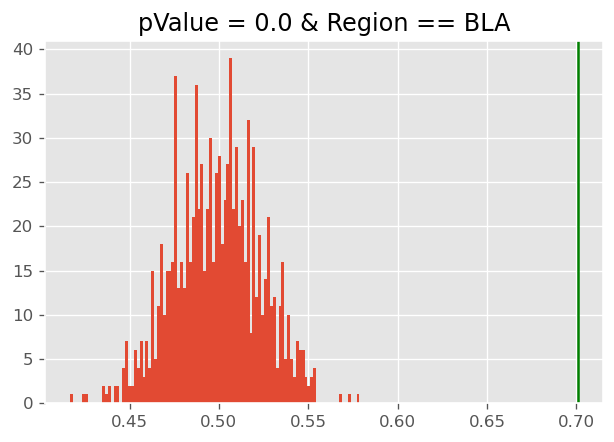

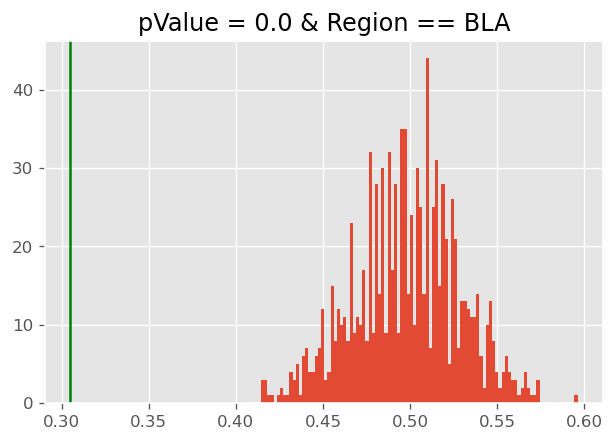

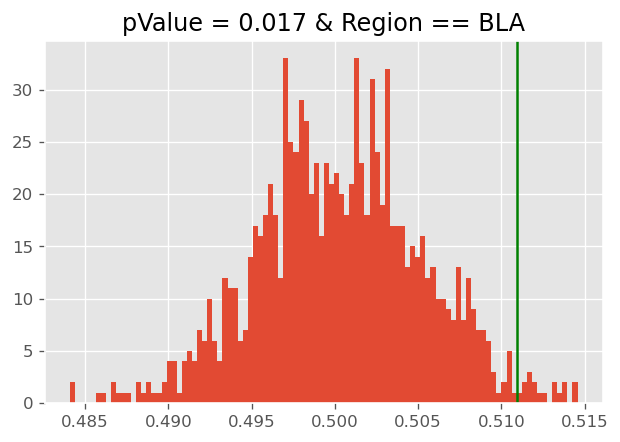

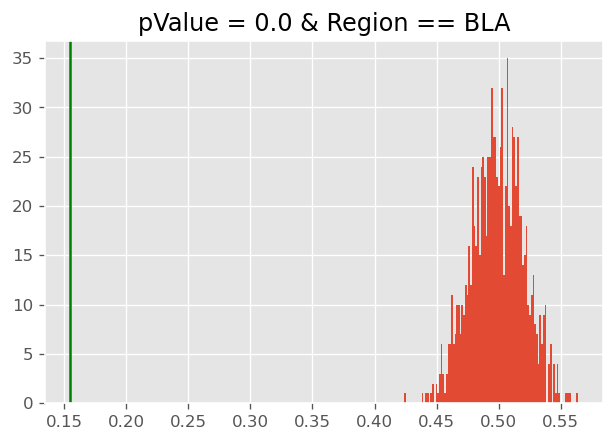

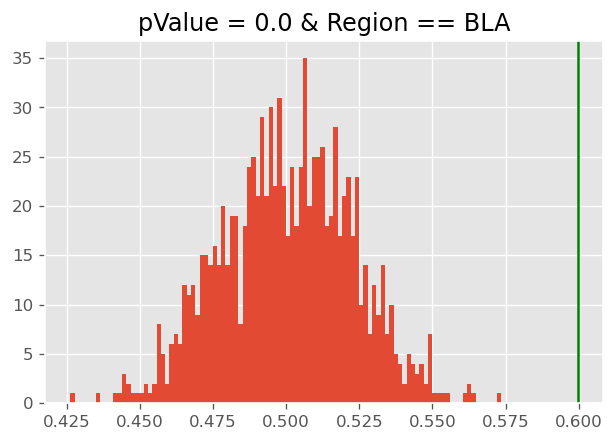

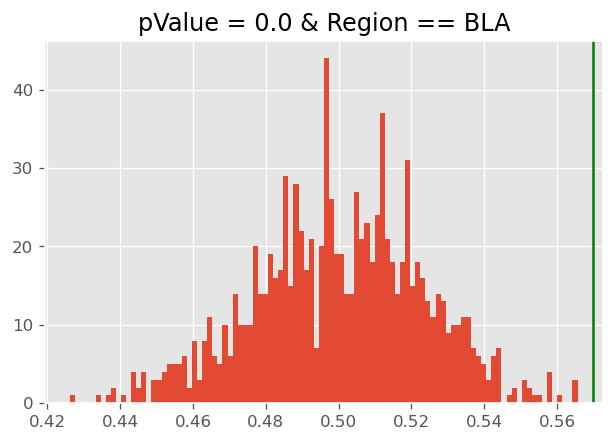

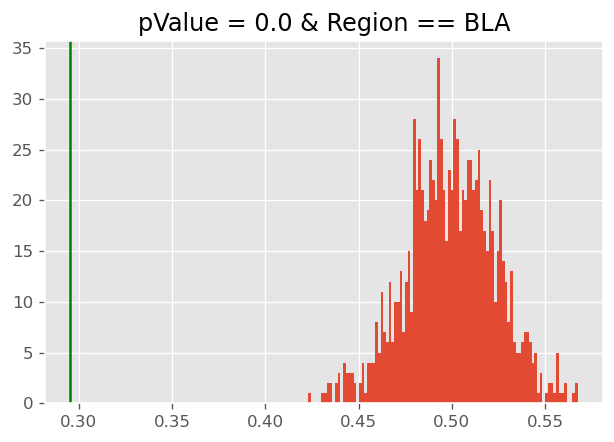

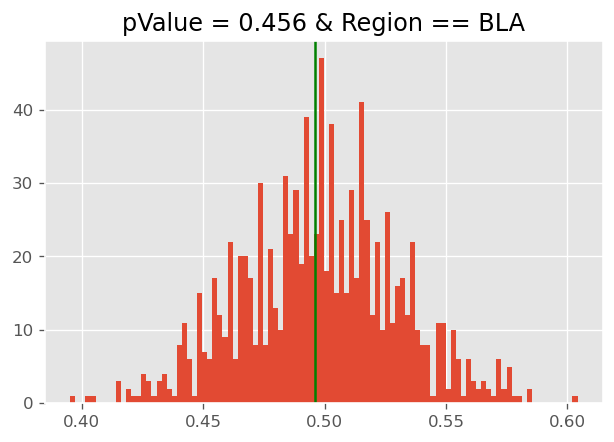

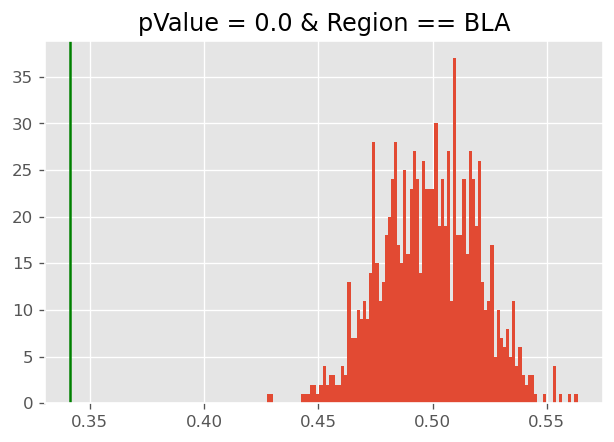

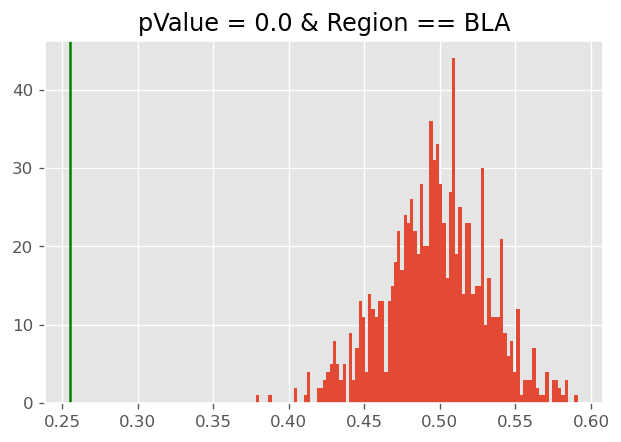

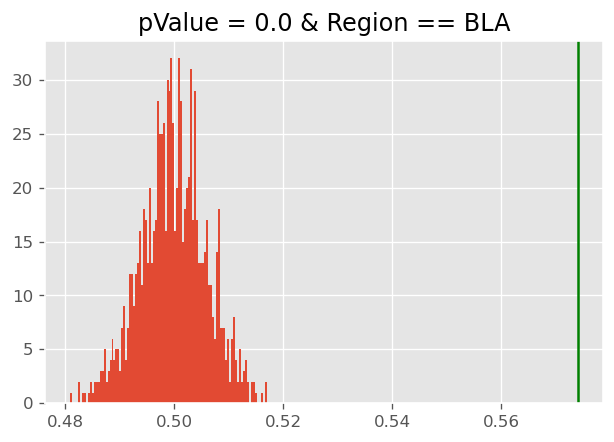

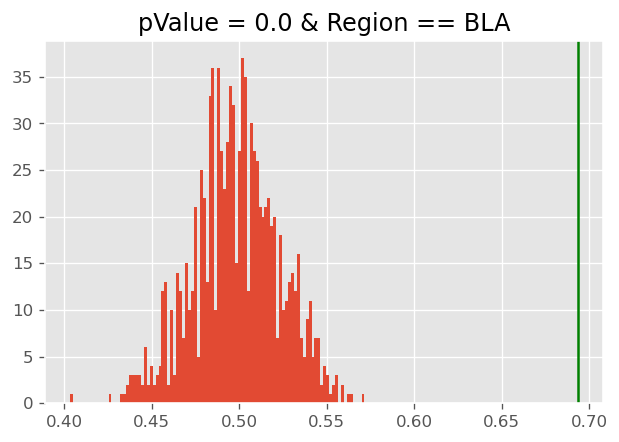

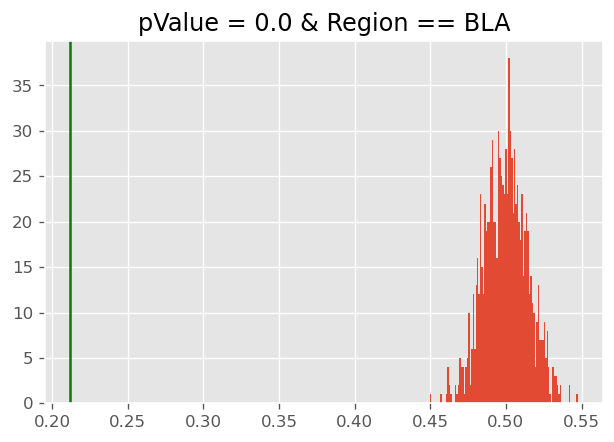

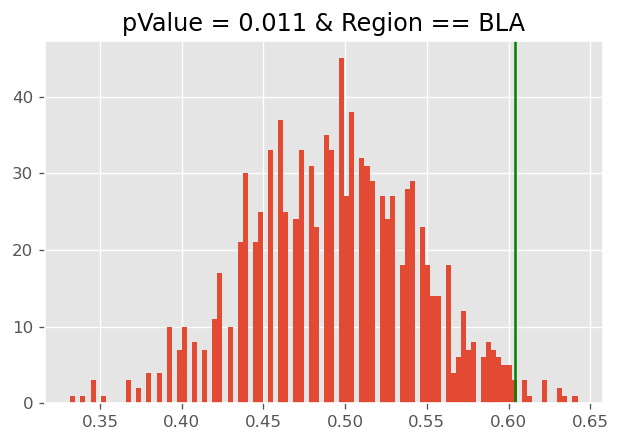

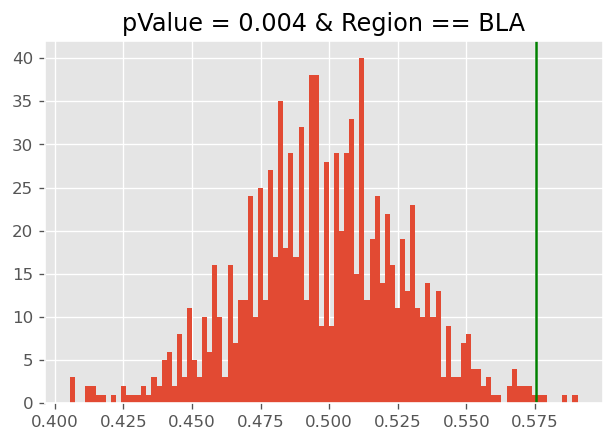

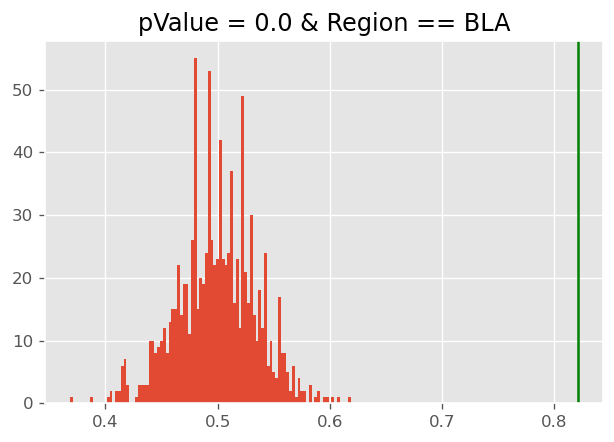

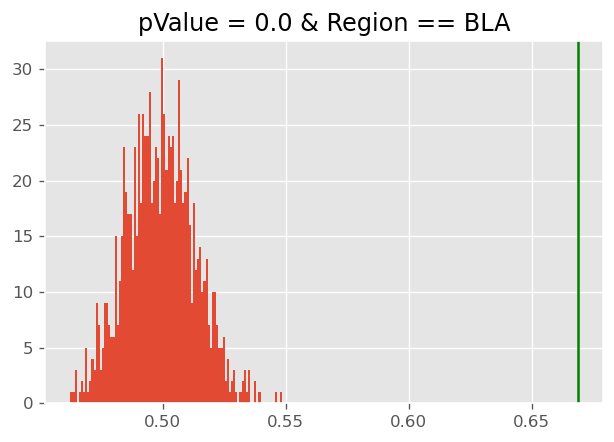

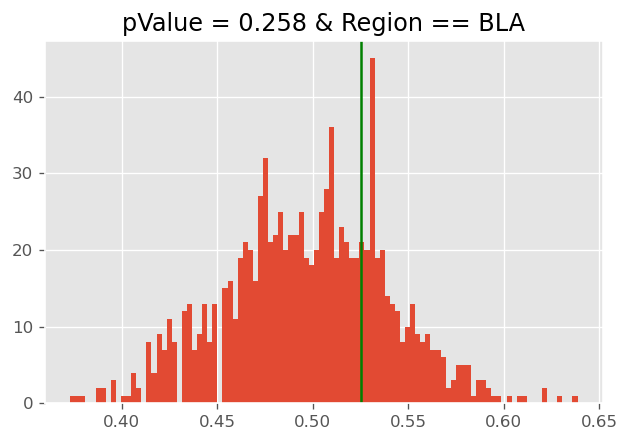

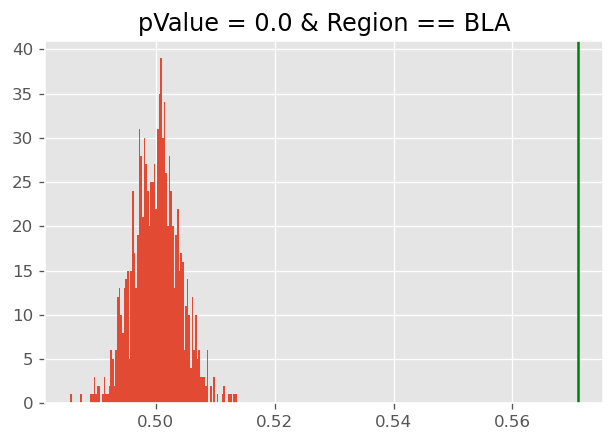

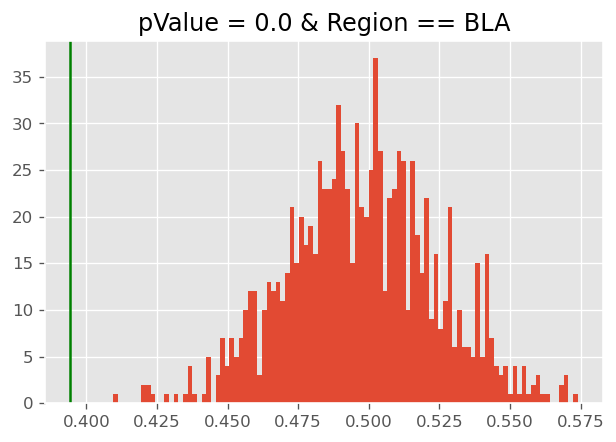

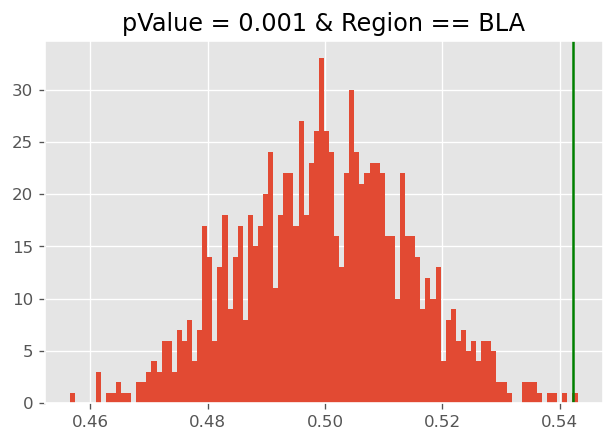

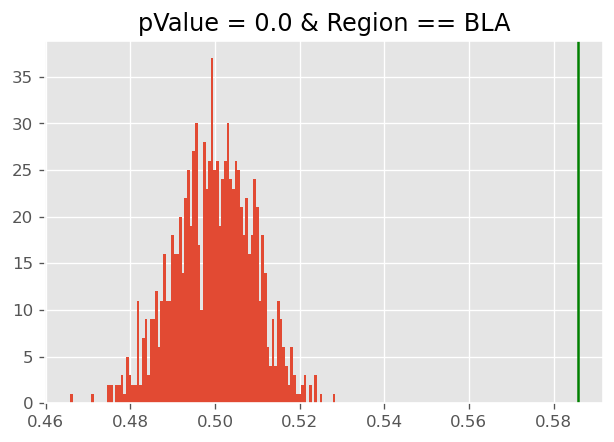

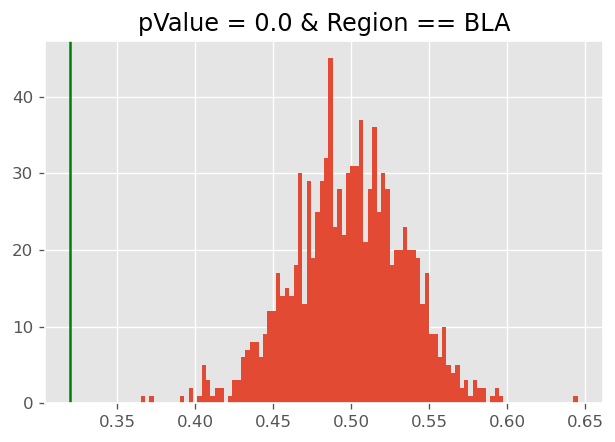

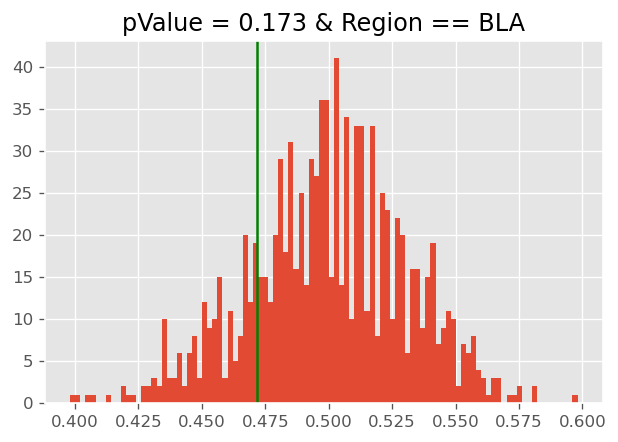

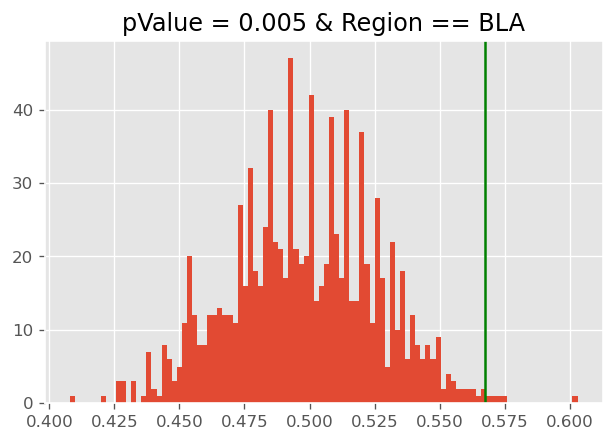

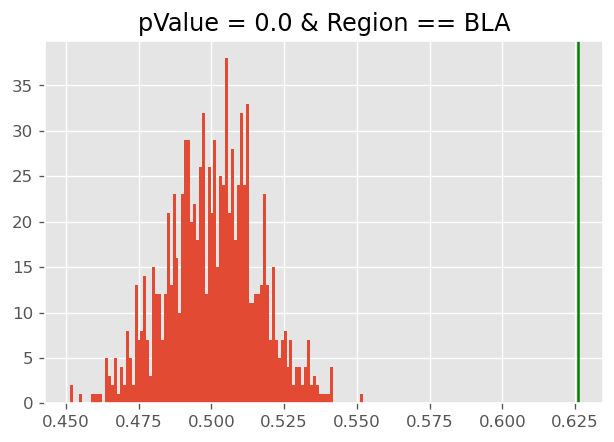

In [6]:
fake_ratio = []
for i in tqdm(range(1000),leave=False):
    shuffle(state_v)
    for state in np.unique(state_v):
        fr[state] = np.sum(activity.values[state_v==state,:],axis = 0) / np.sum(state_v == state)
    fake_ratio.append(fr['REM']/(fr['NREM']+fr['REM']))

fake_ratio = np.array(fake_ratio)
for i in range(252):
    plt.figure(dpi = 120)
    plt.hist(fake_ratio[:,i],100)
    plt.axvline(true_ratio[i],color = 'green')
    pvalue = bk.stats.shuffles_pvalue(fake_ratio[:,i],true_ratio[i])
    plt.title(f'pValue = {pvalue} & Region == {metadata.Region.iloc[i]}')

/tmp/ipykernel_433660/2346402911.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi = 180)


KeyboardInterrupt: 

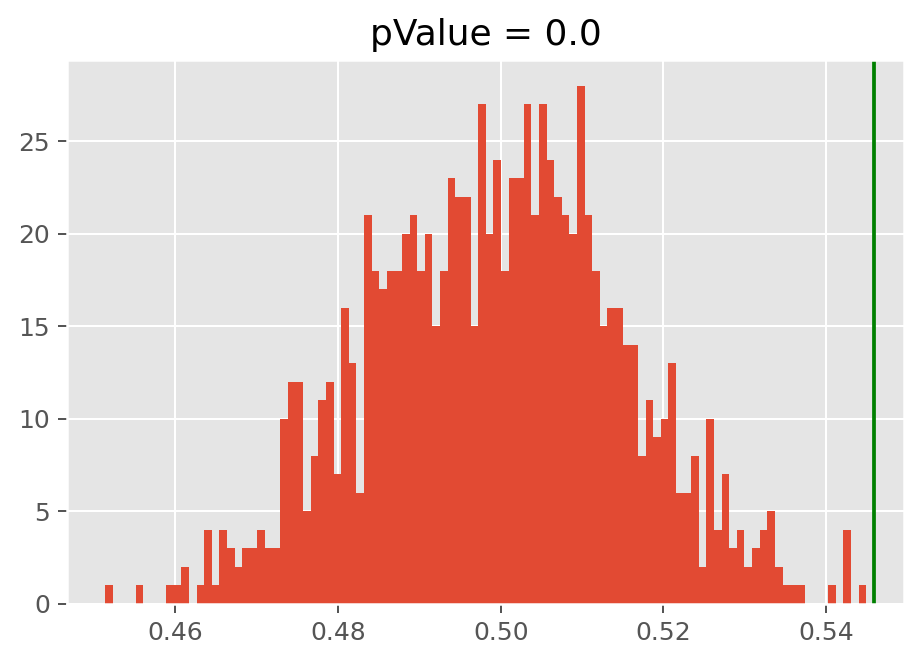

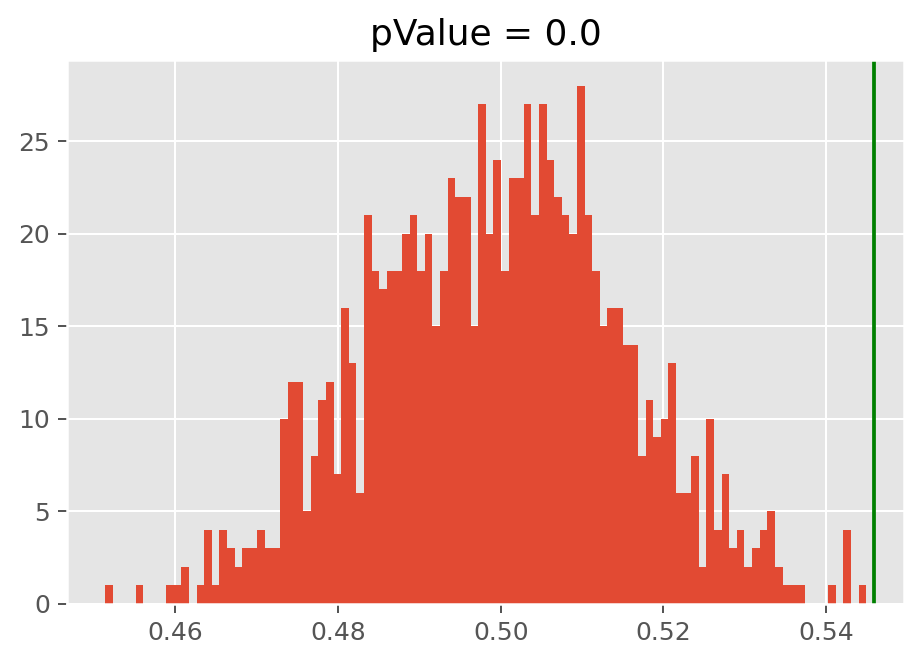

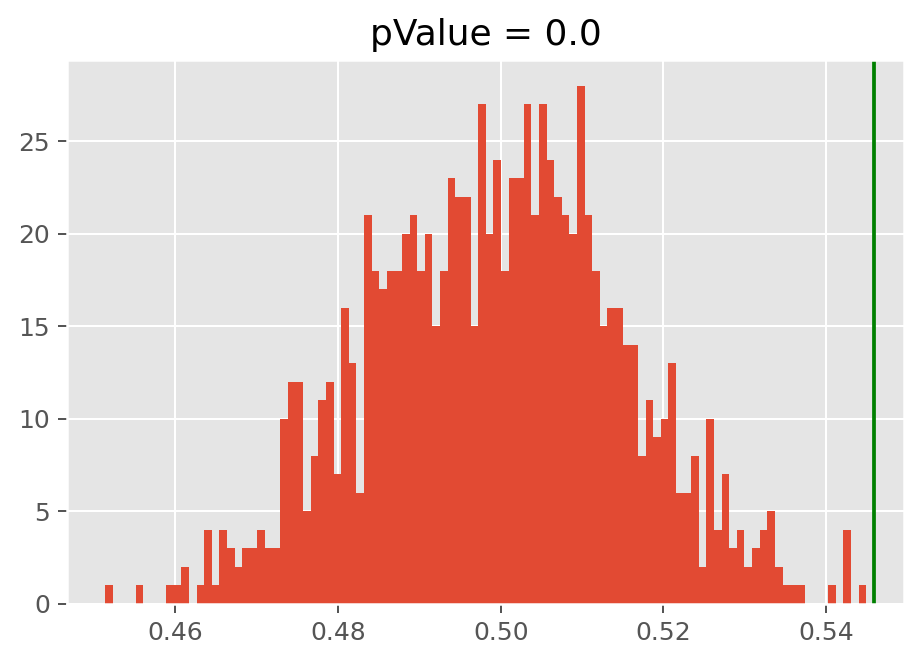

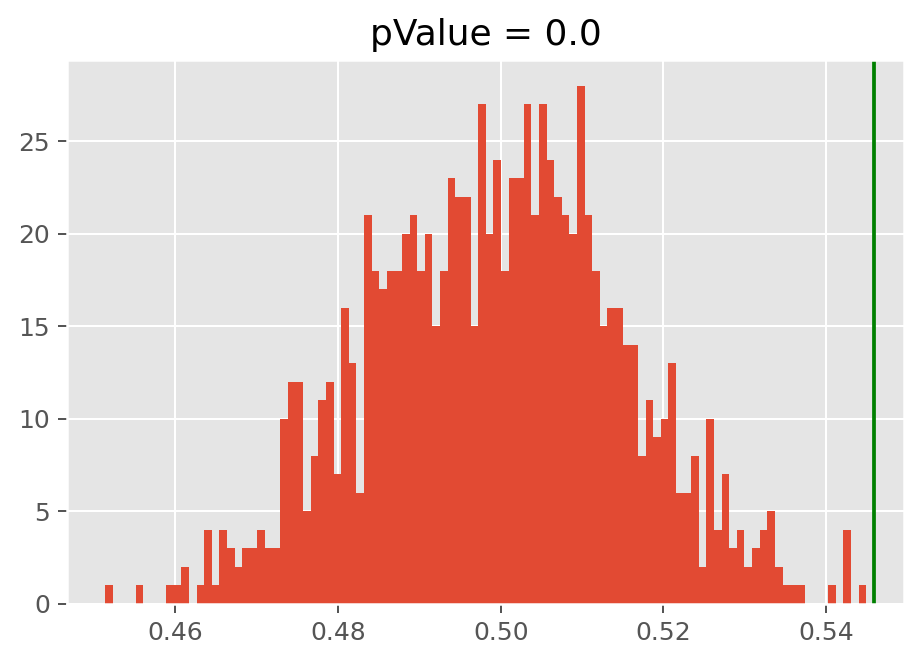

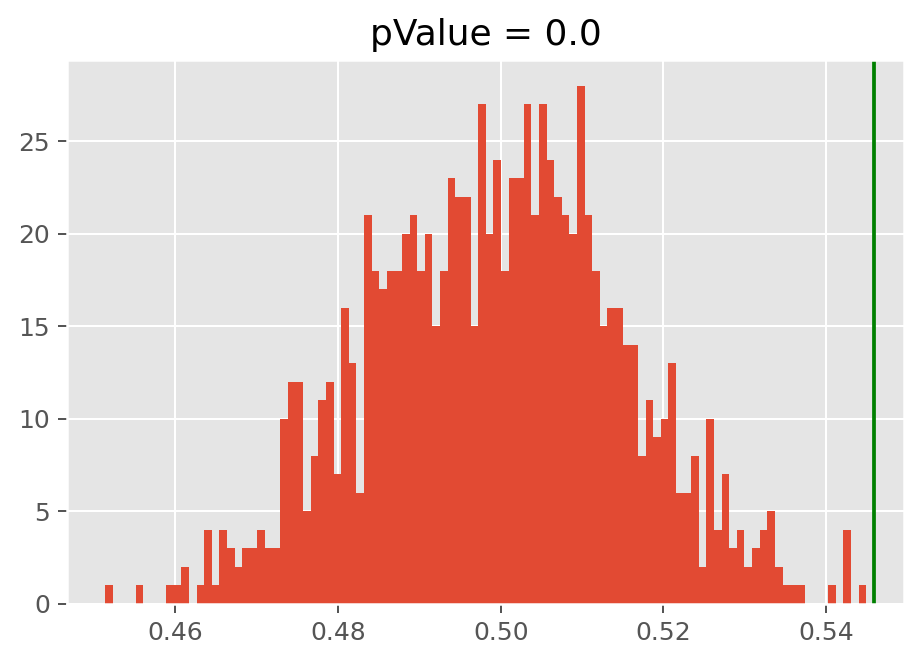

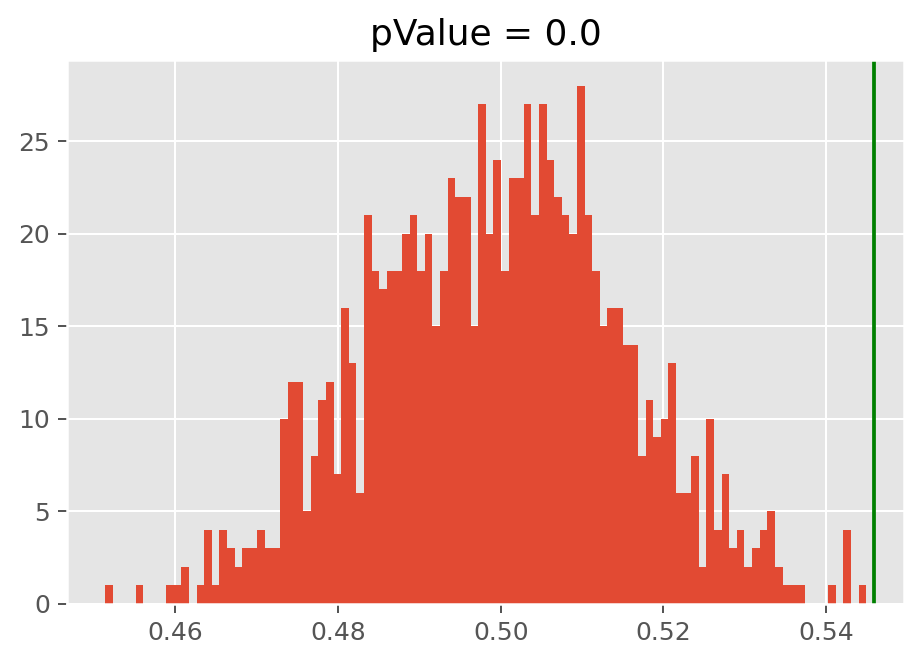

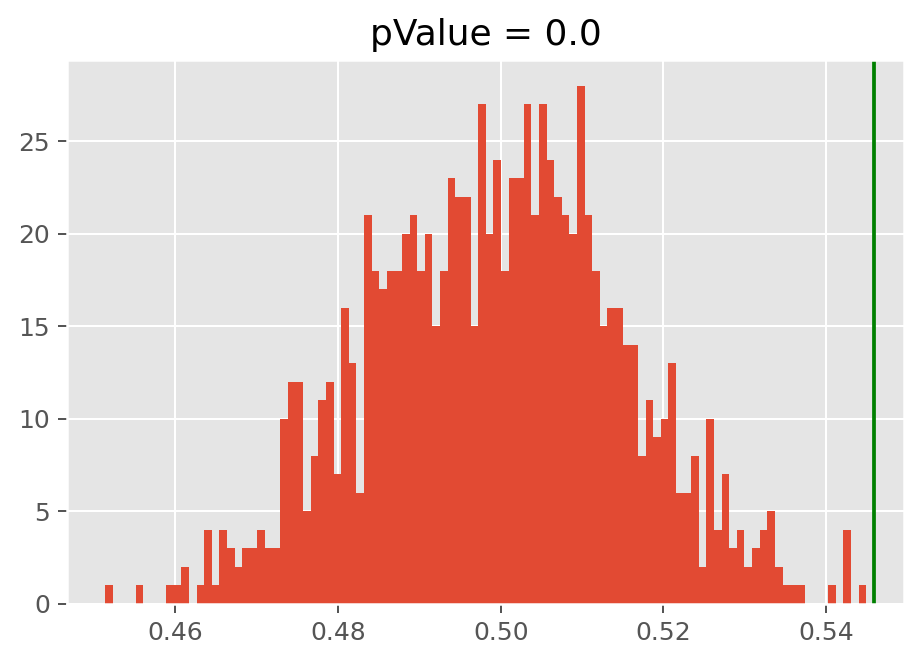

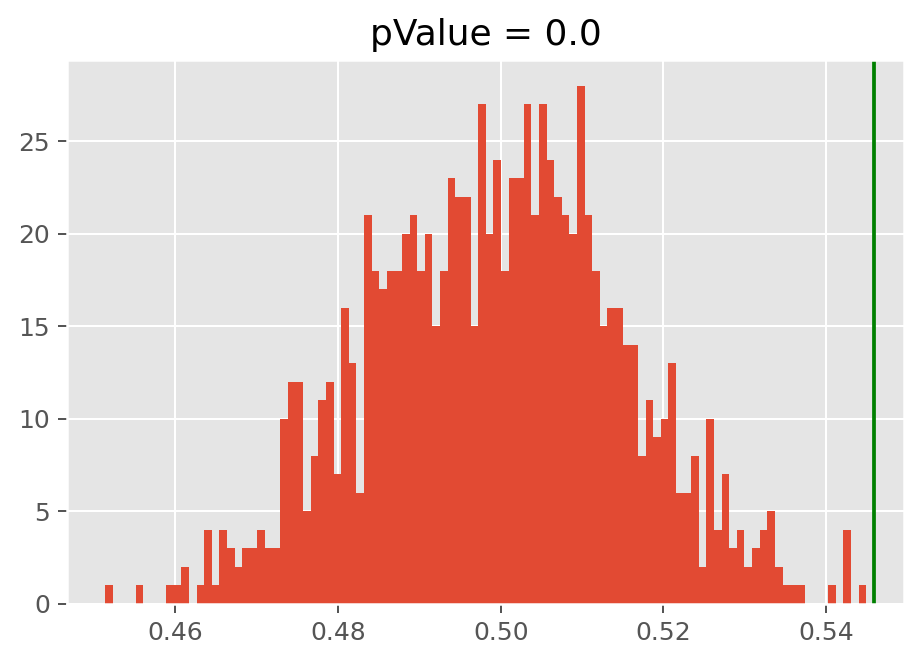

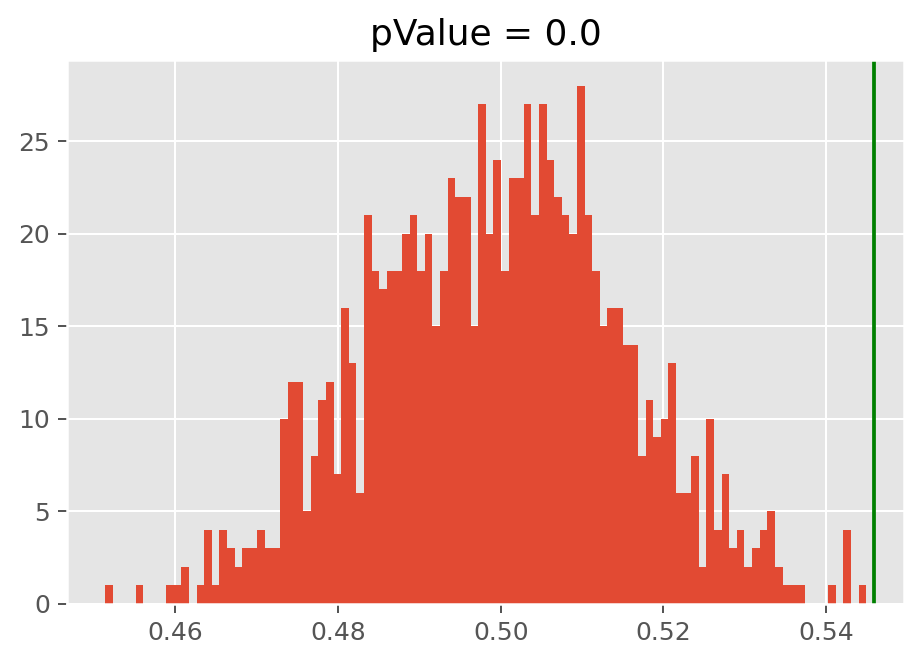

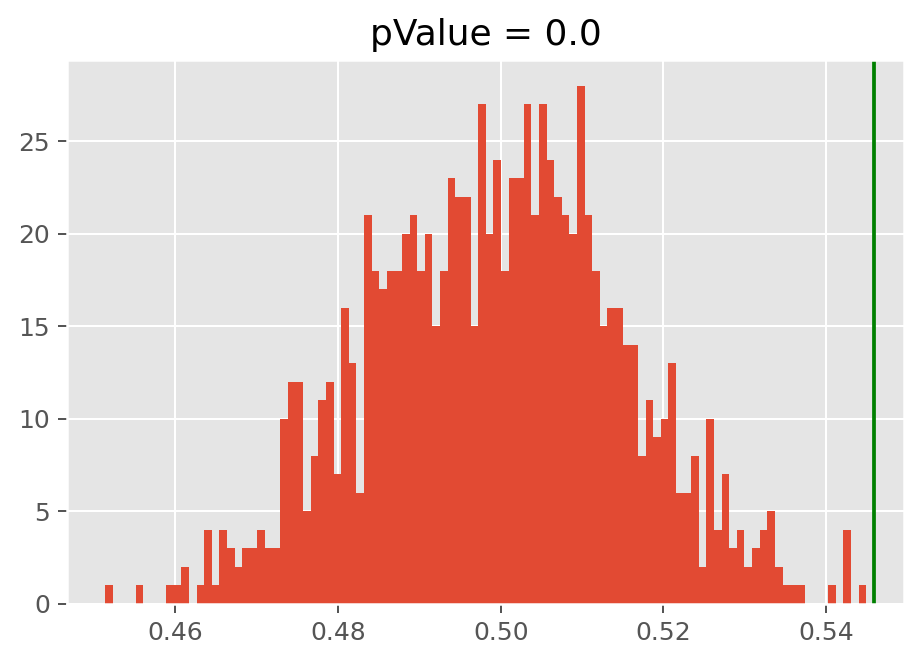

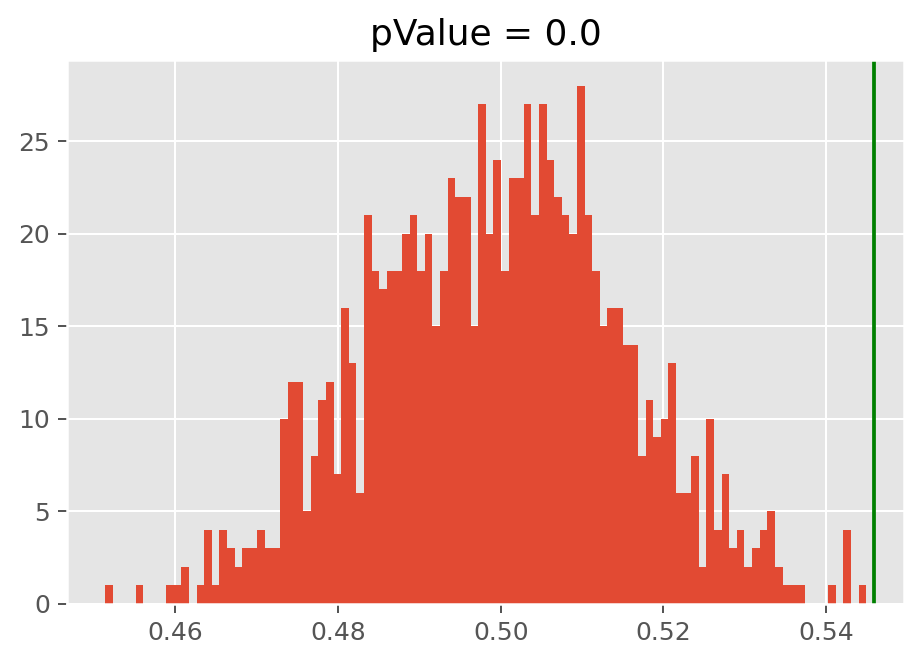

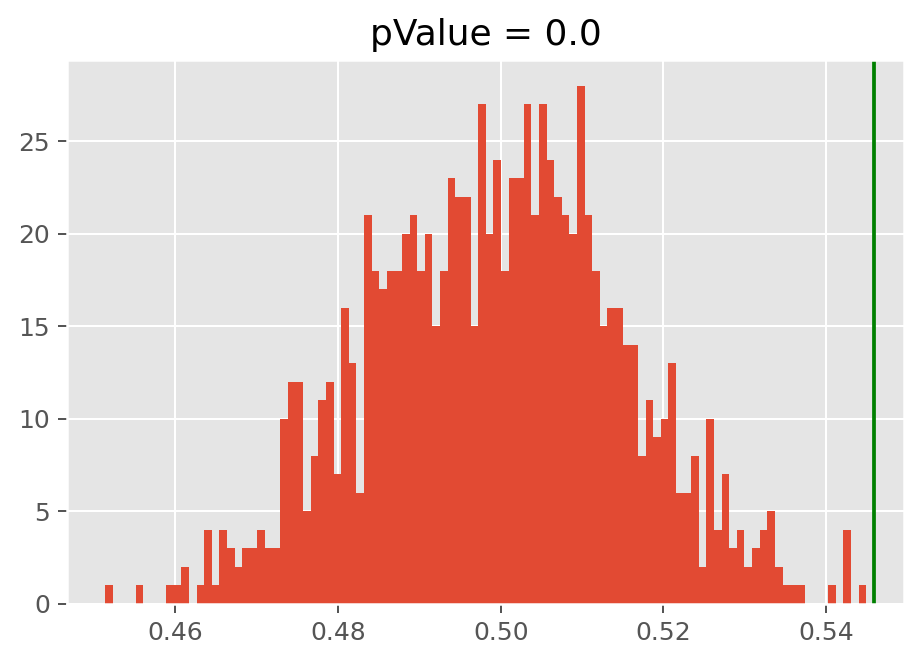

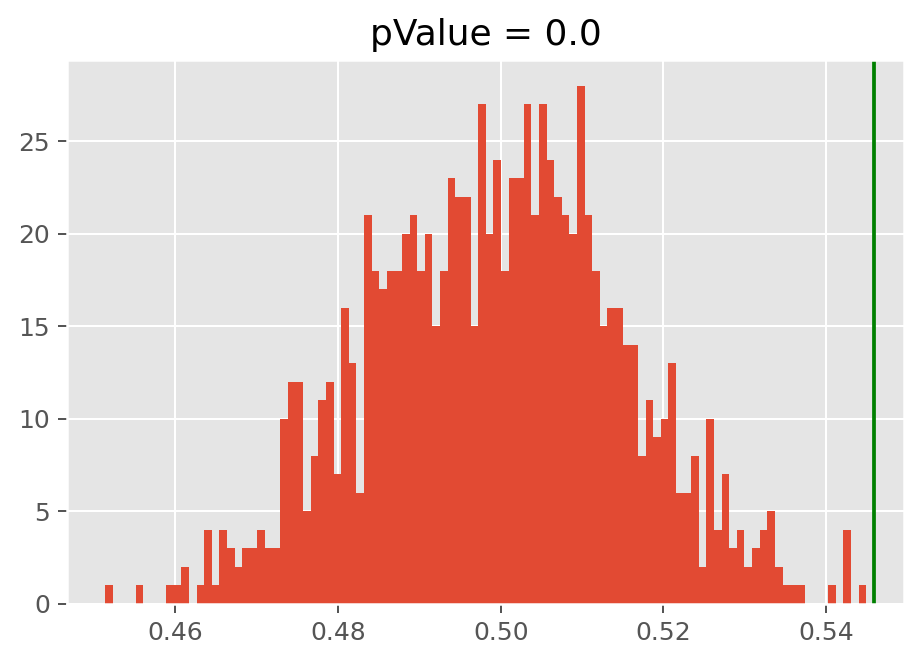

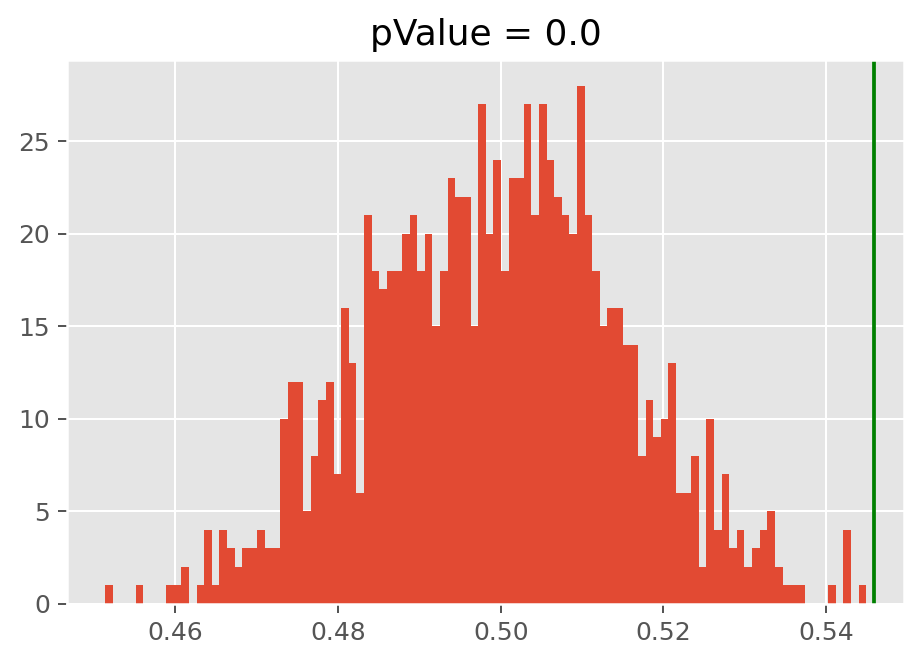

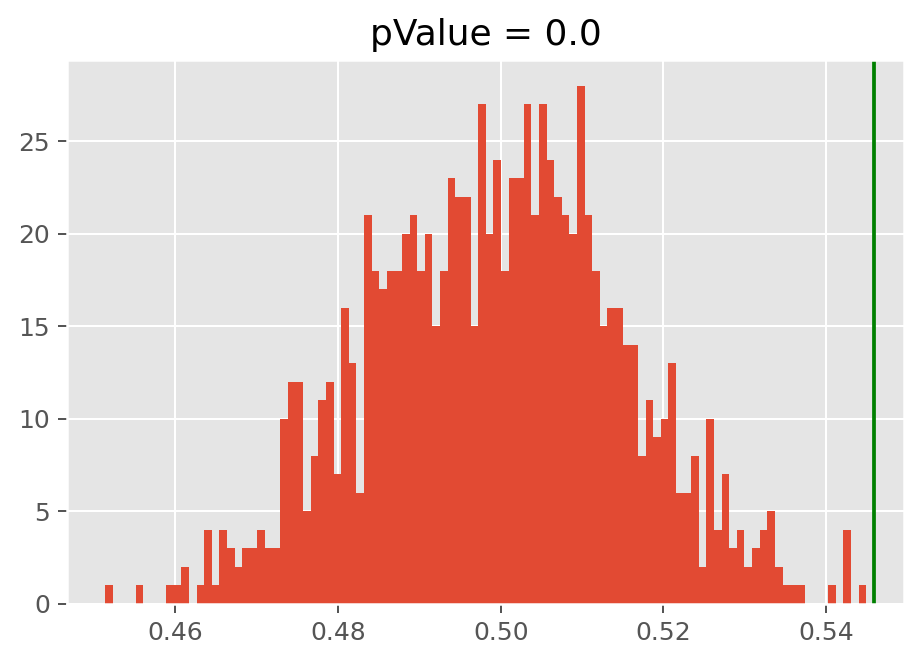

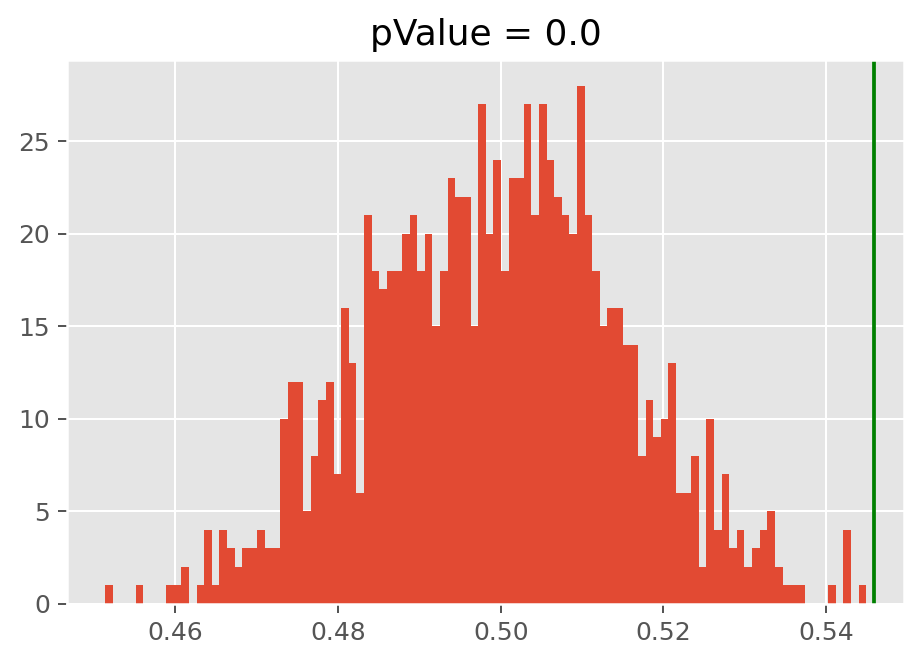

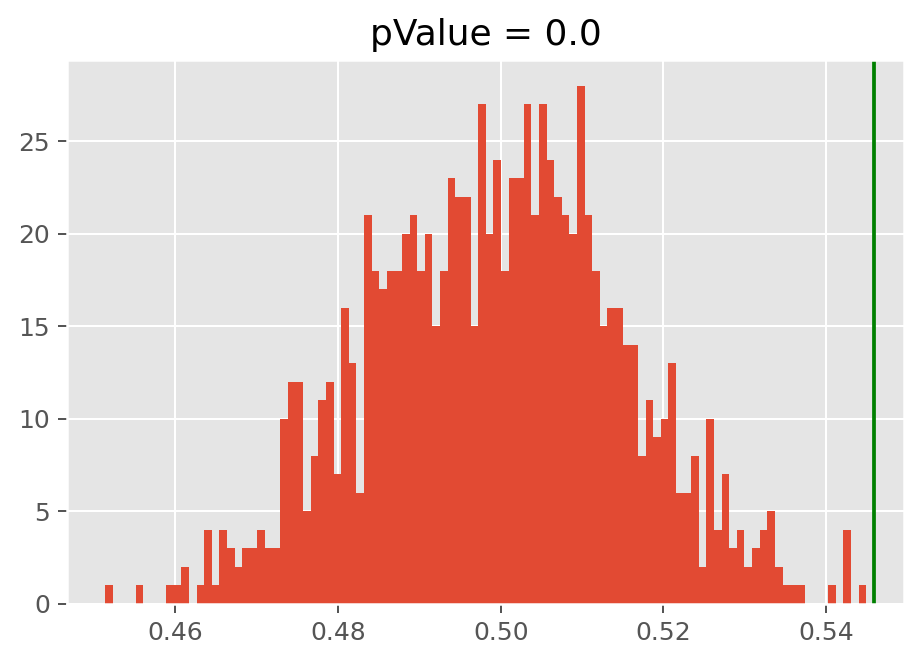

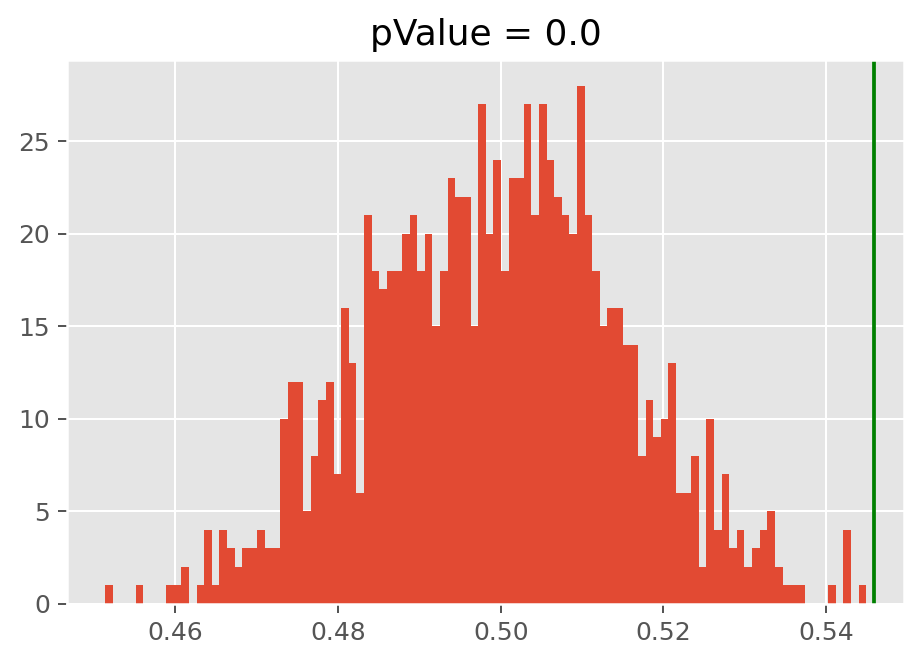

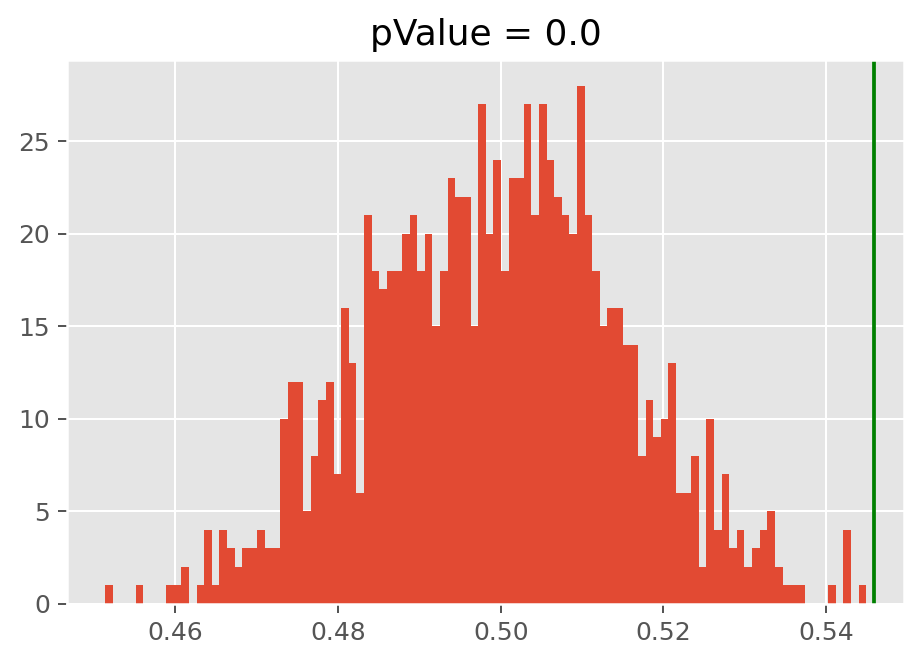

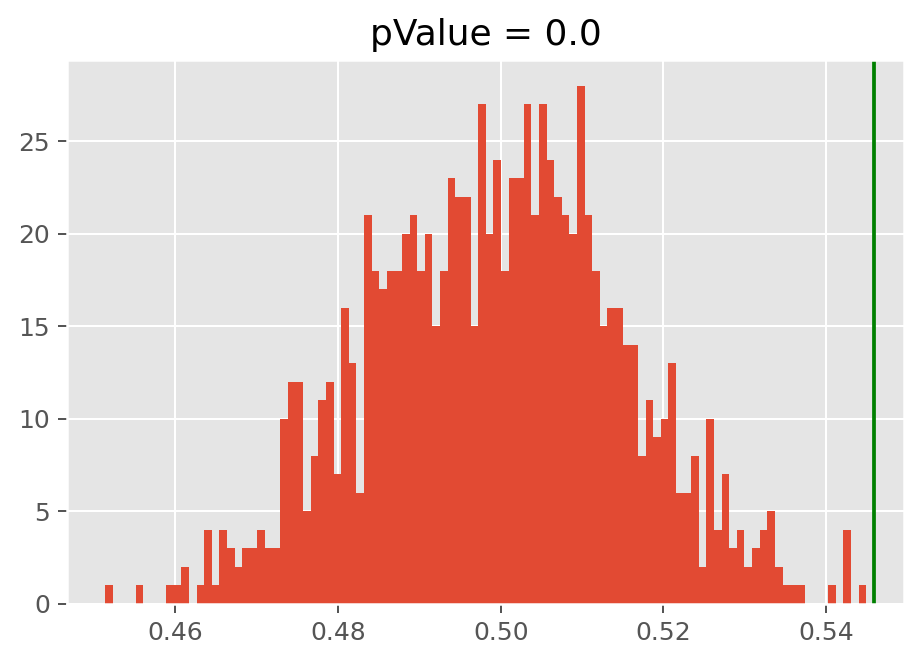

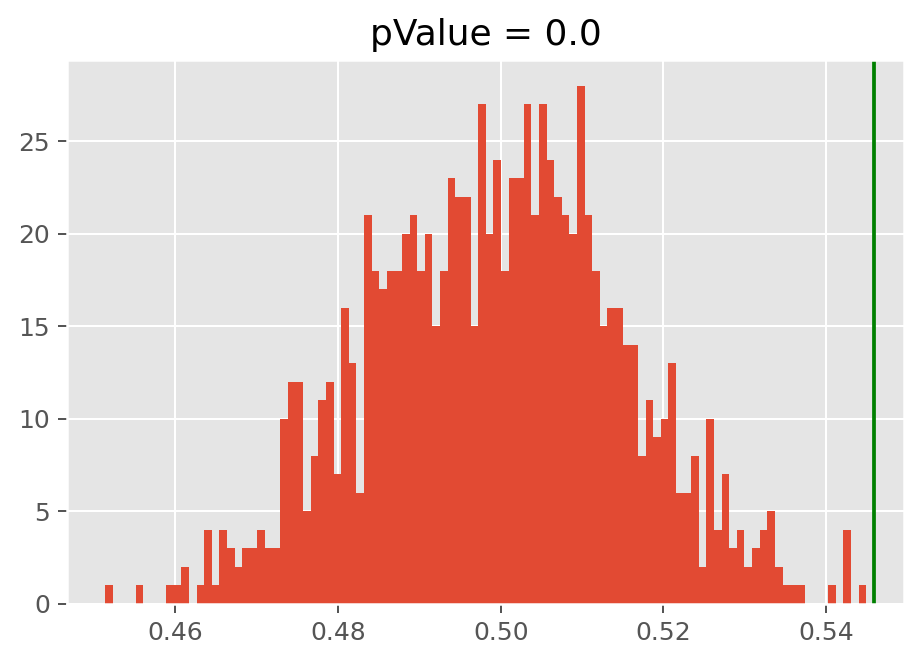

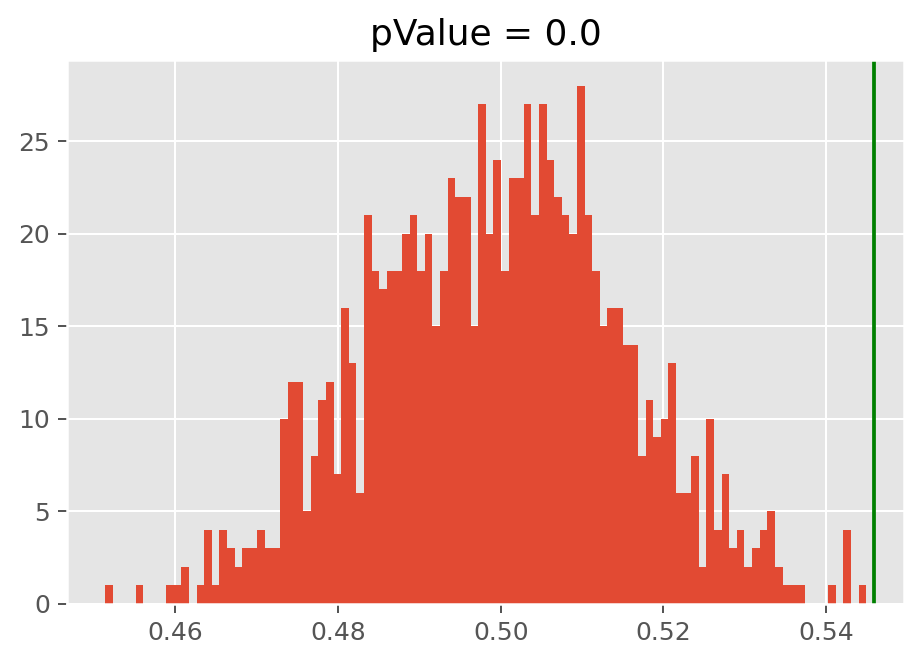

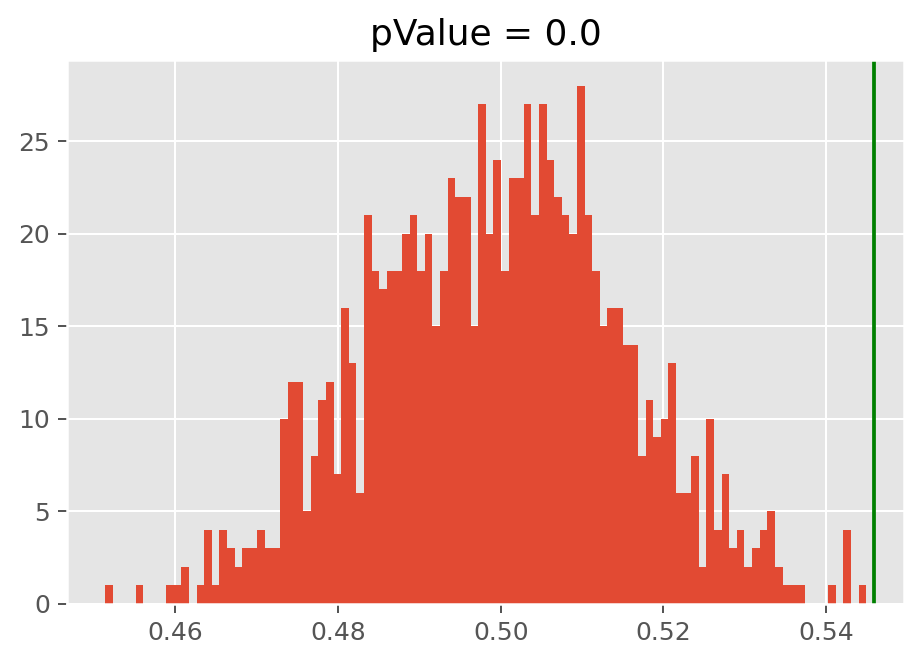

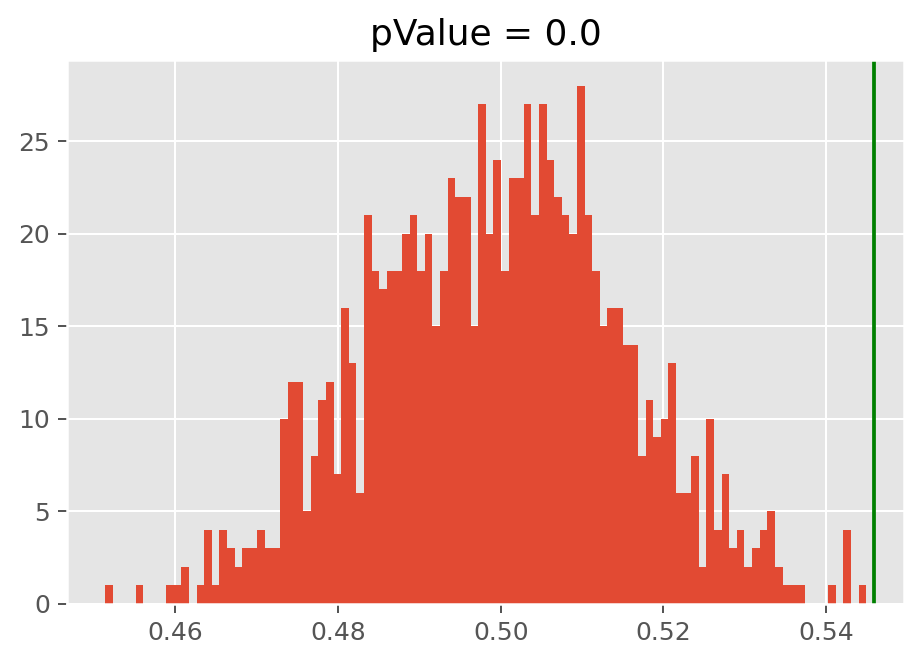

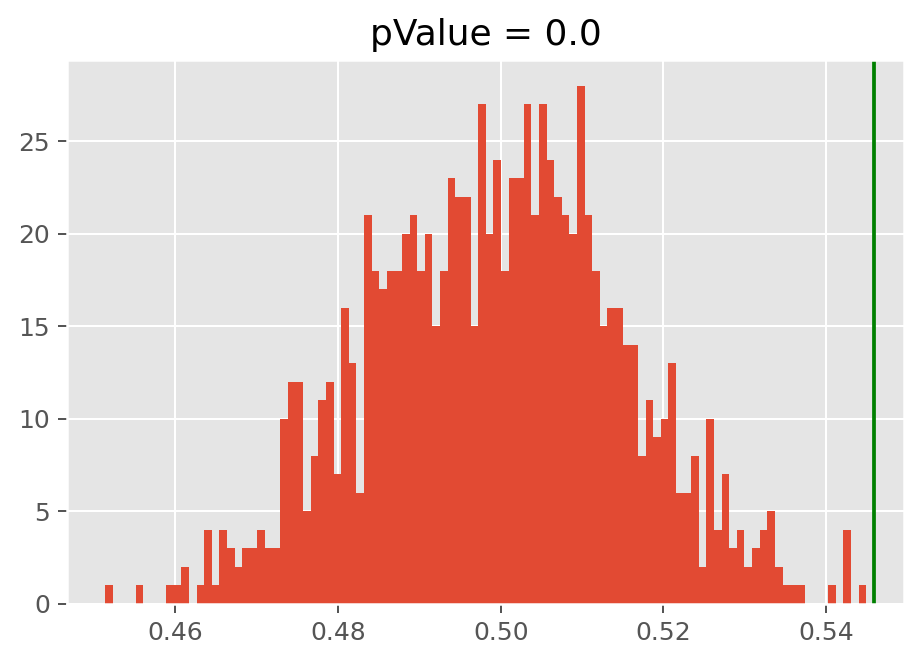

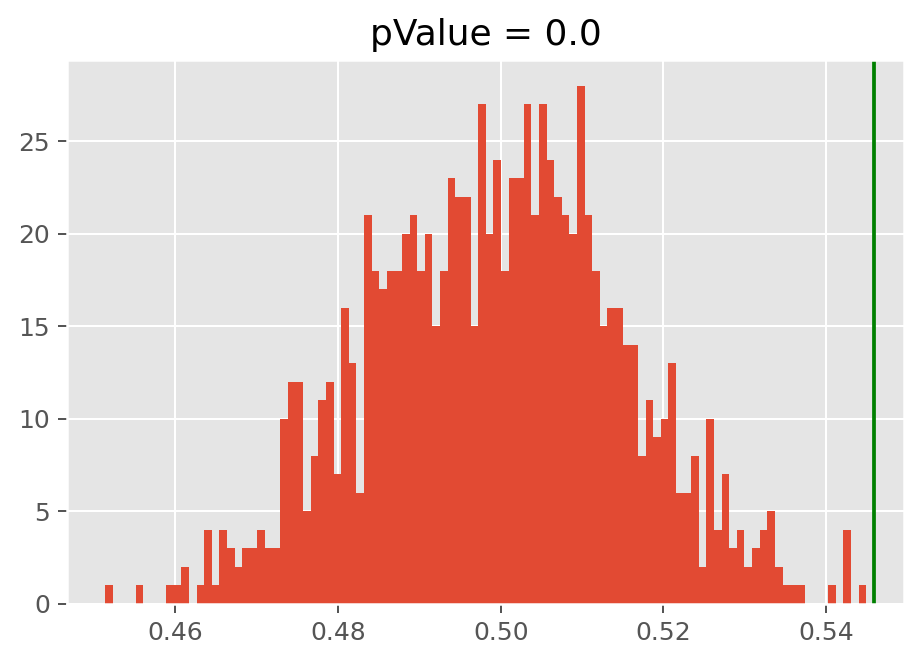

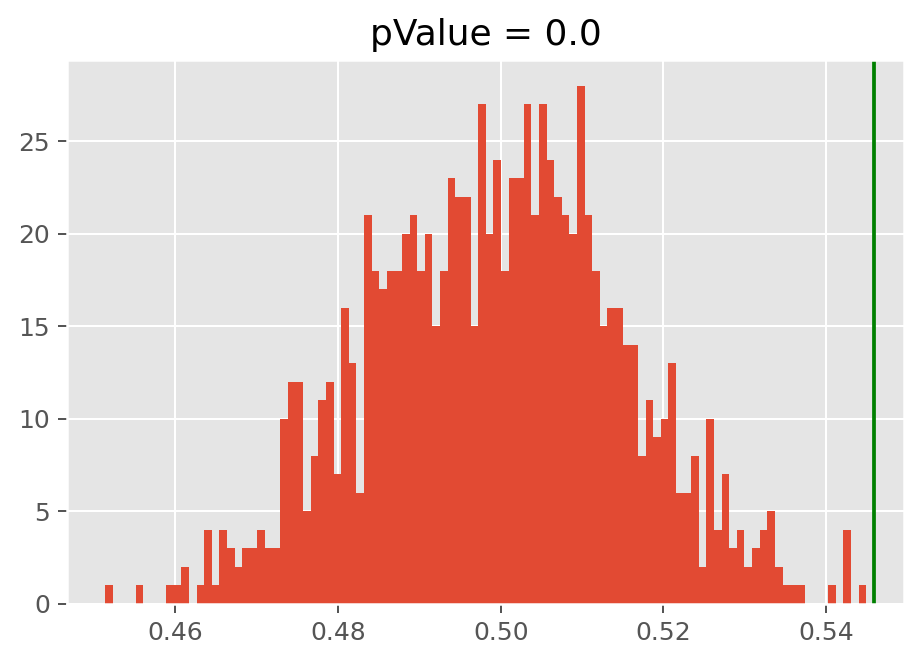

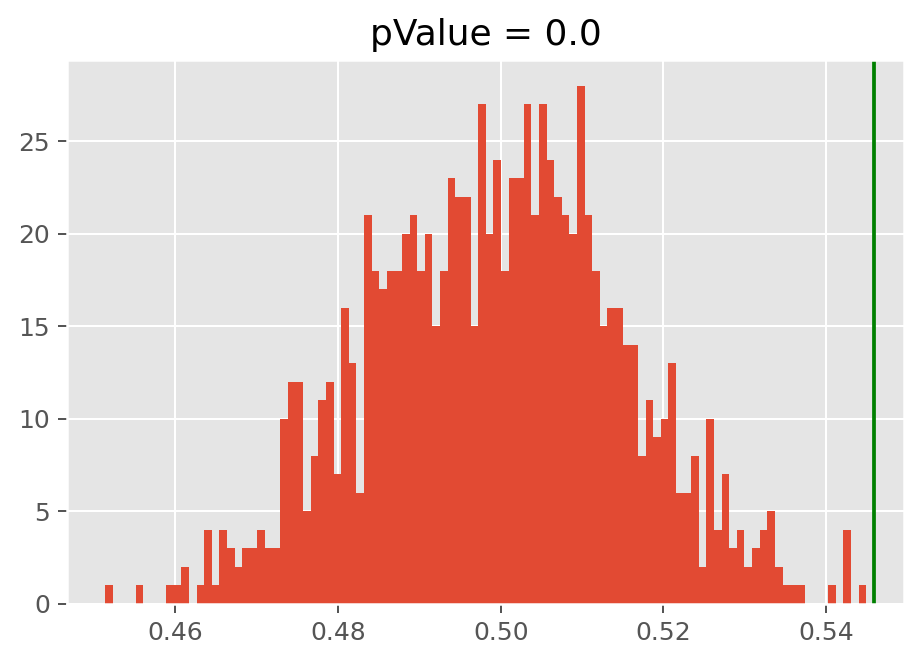

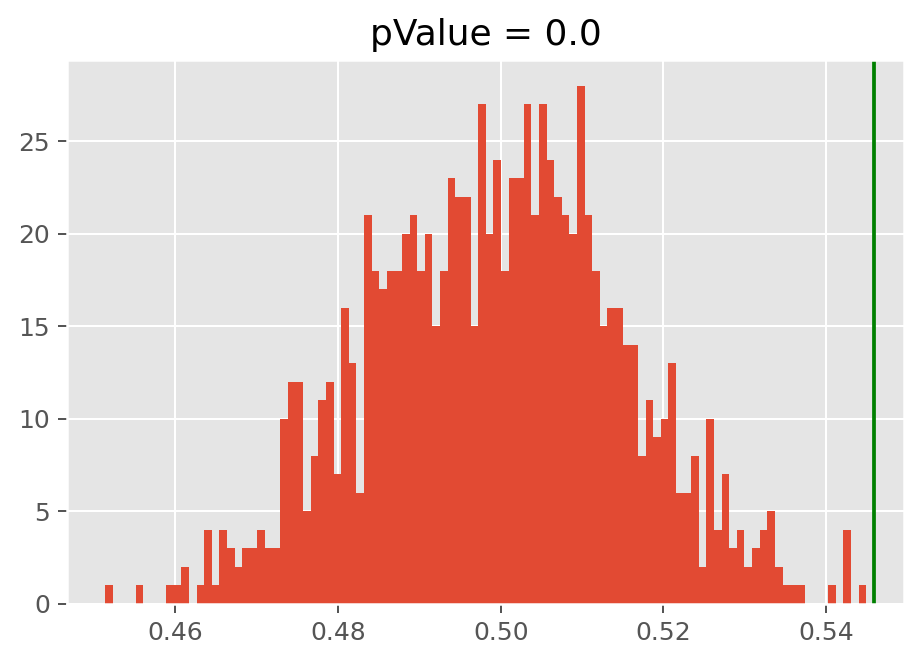

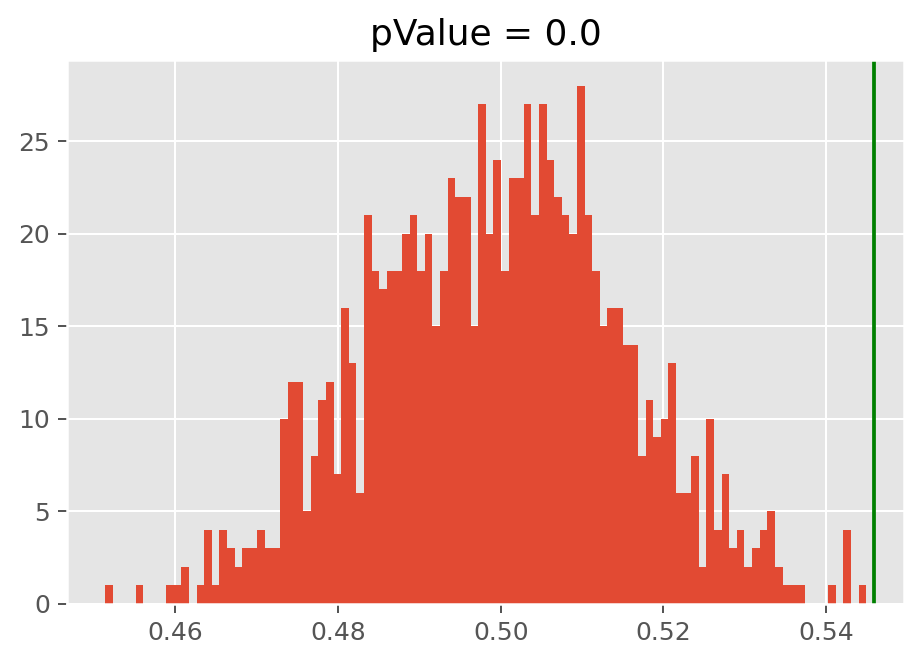

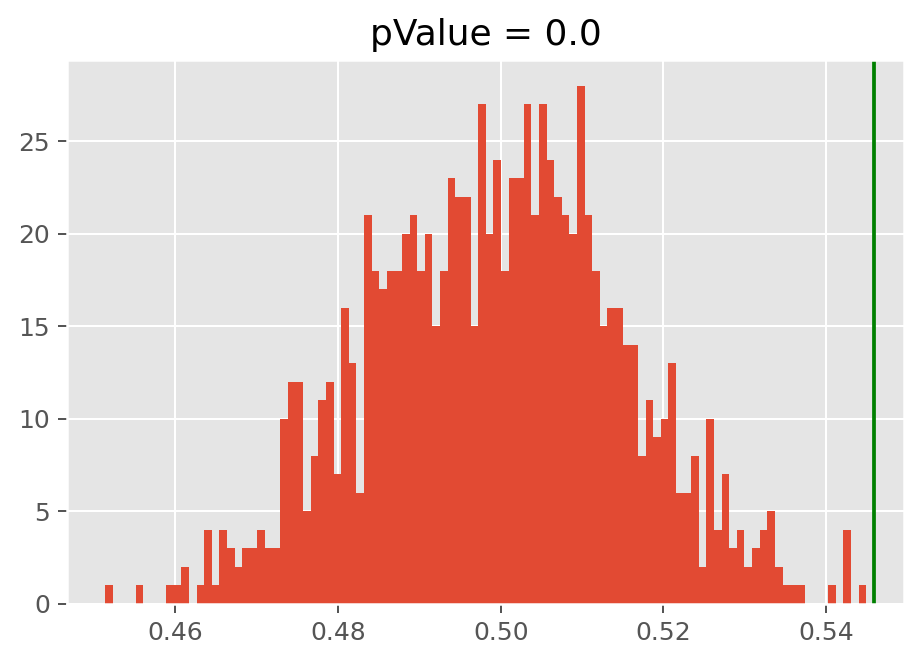

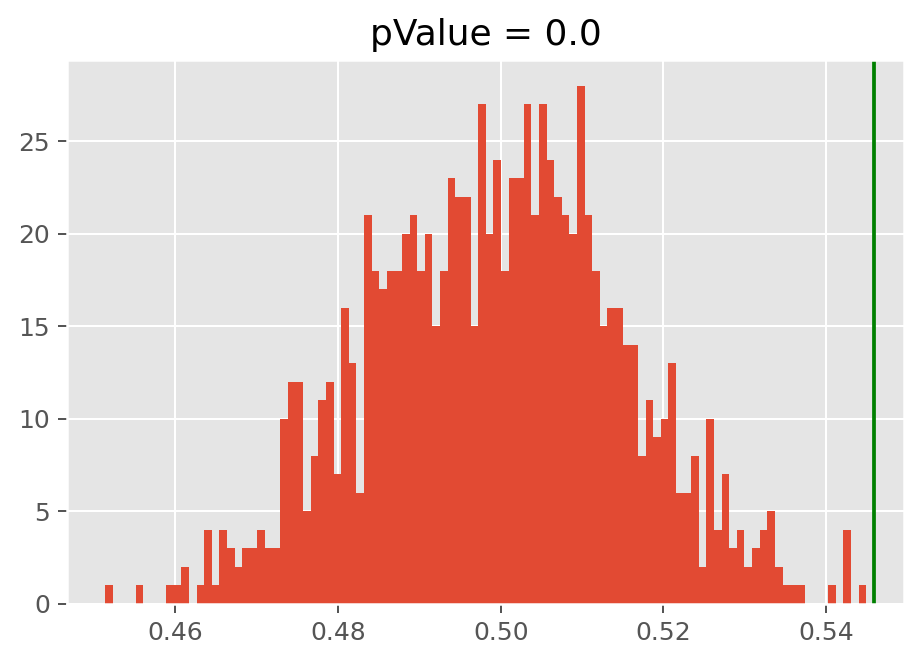

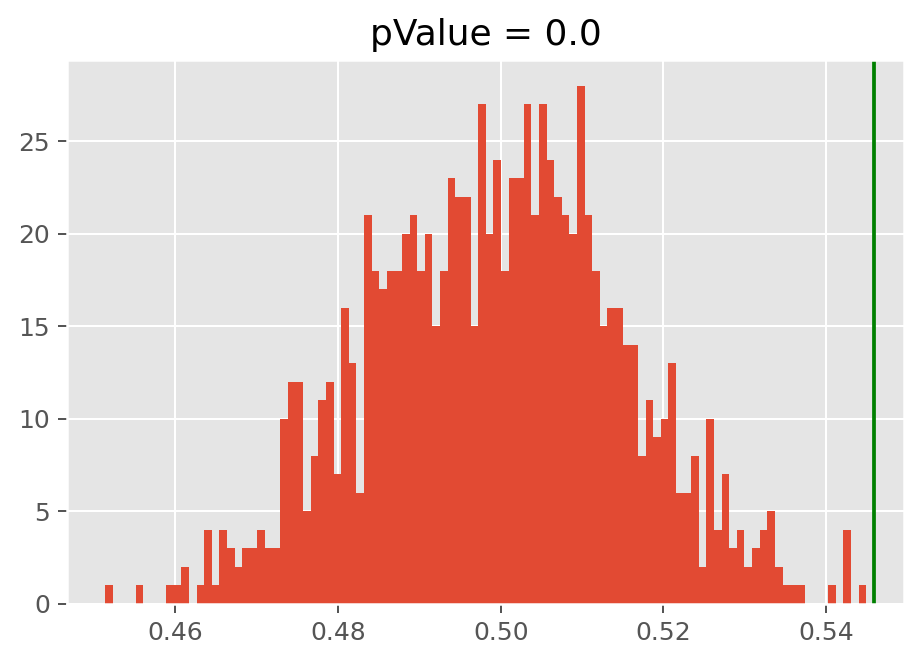

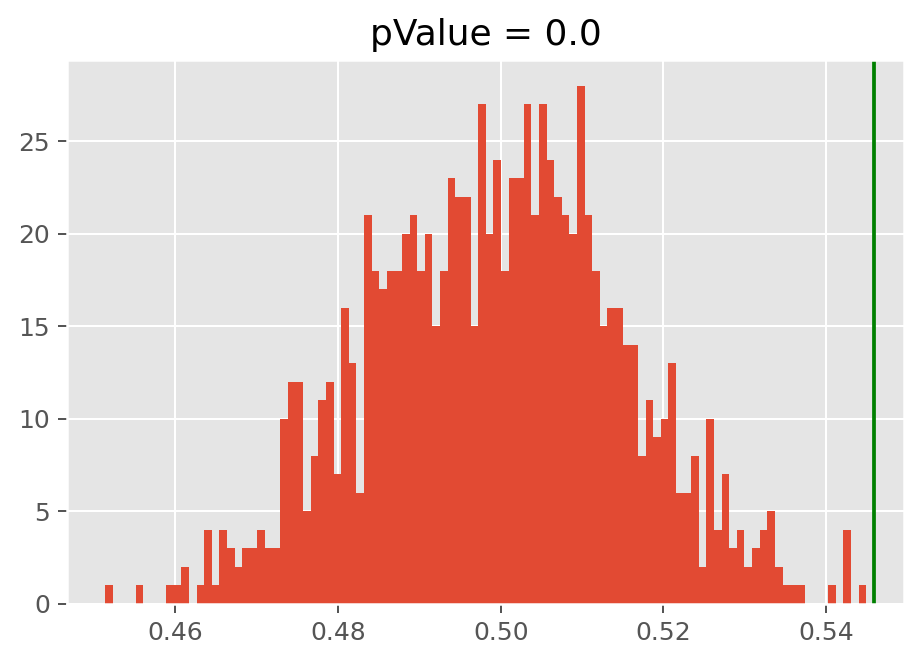

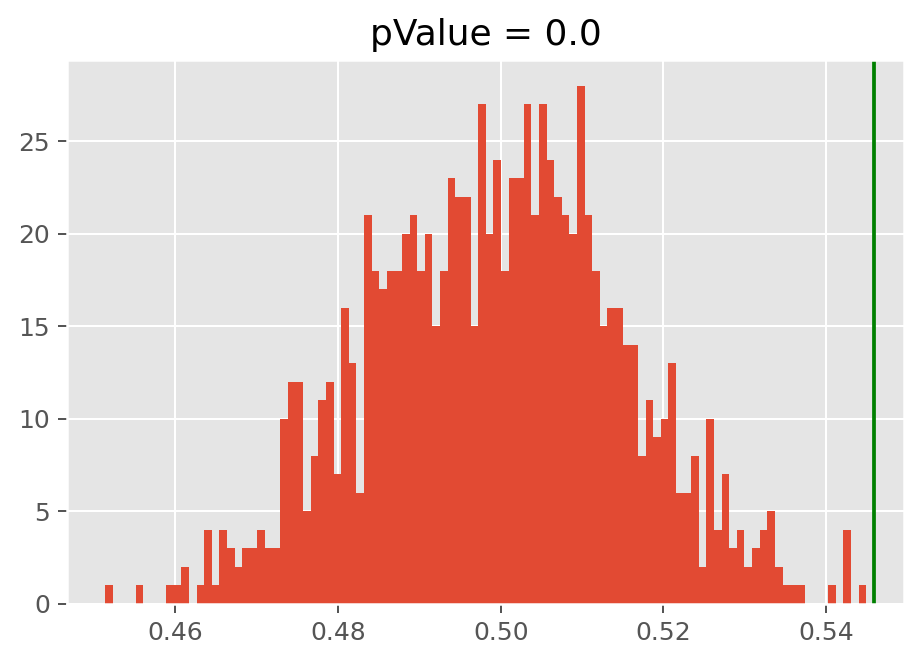

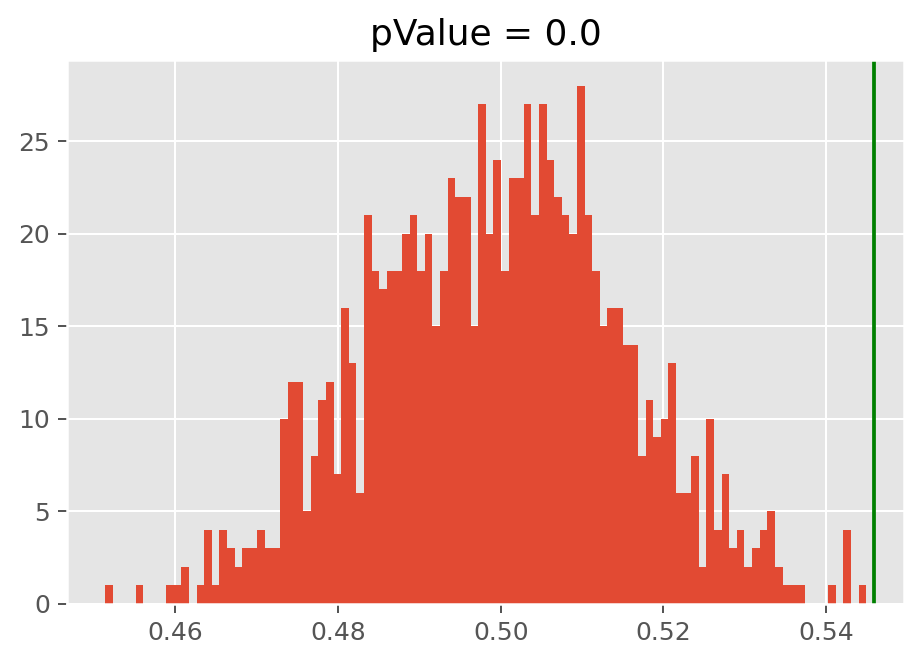

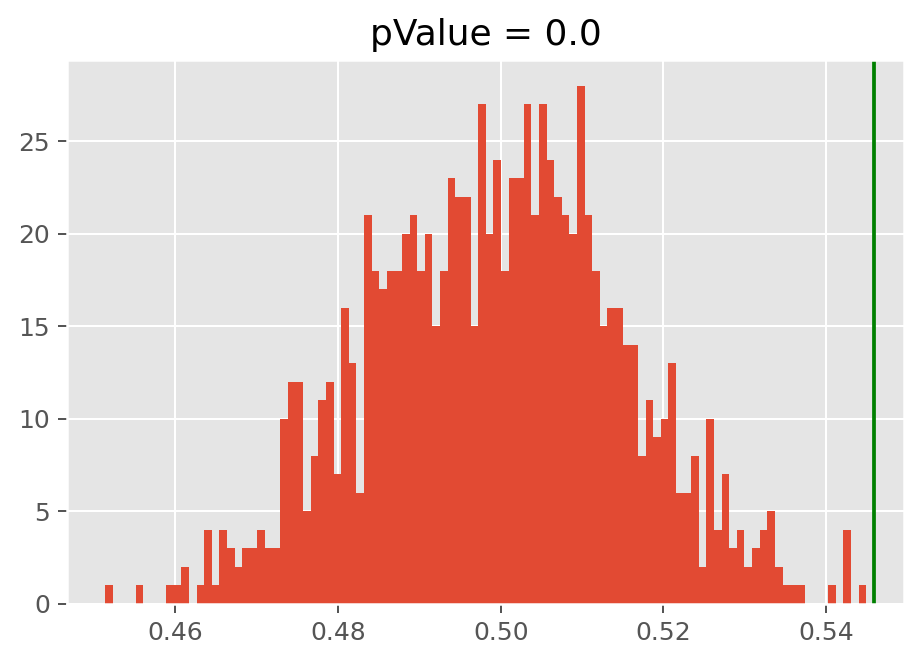

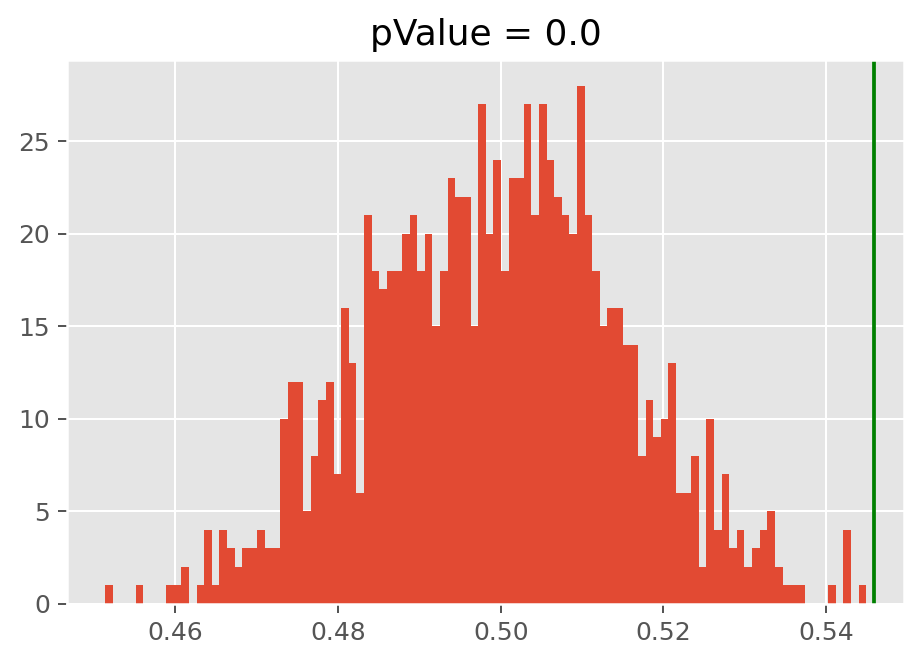

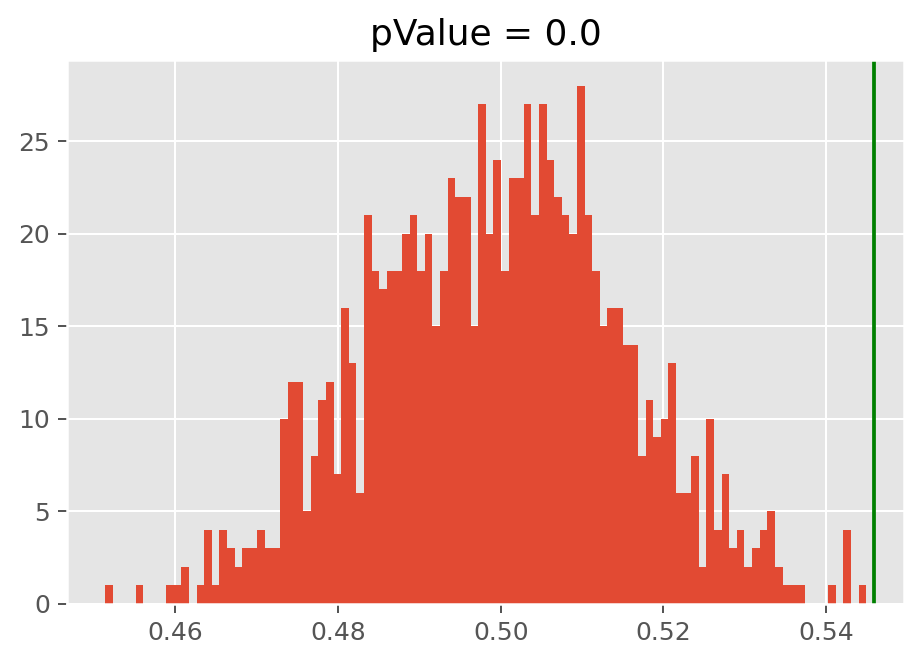

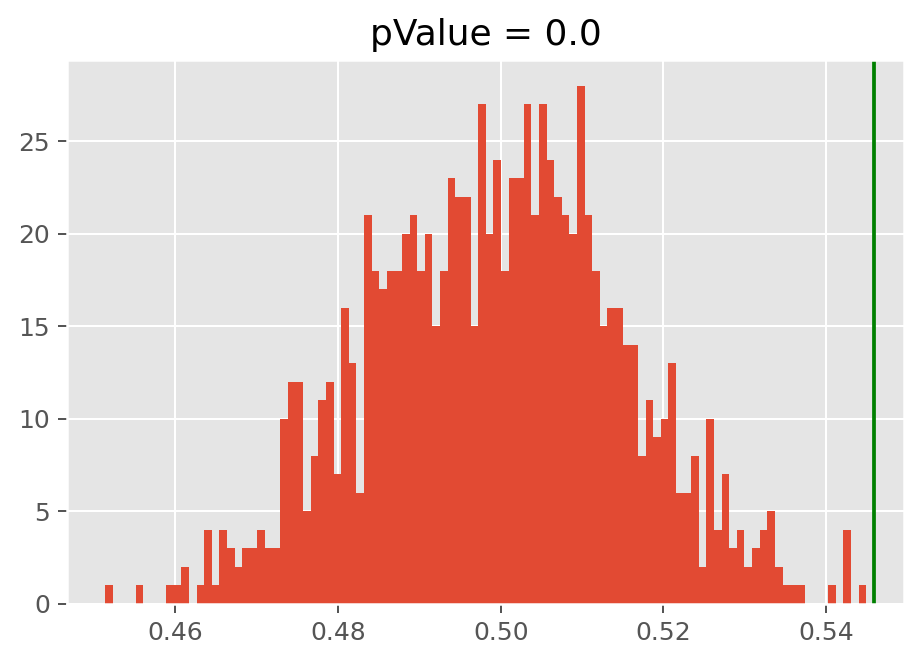

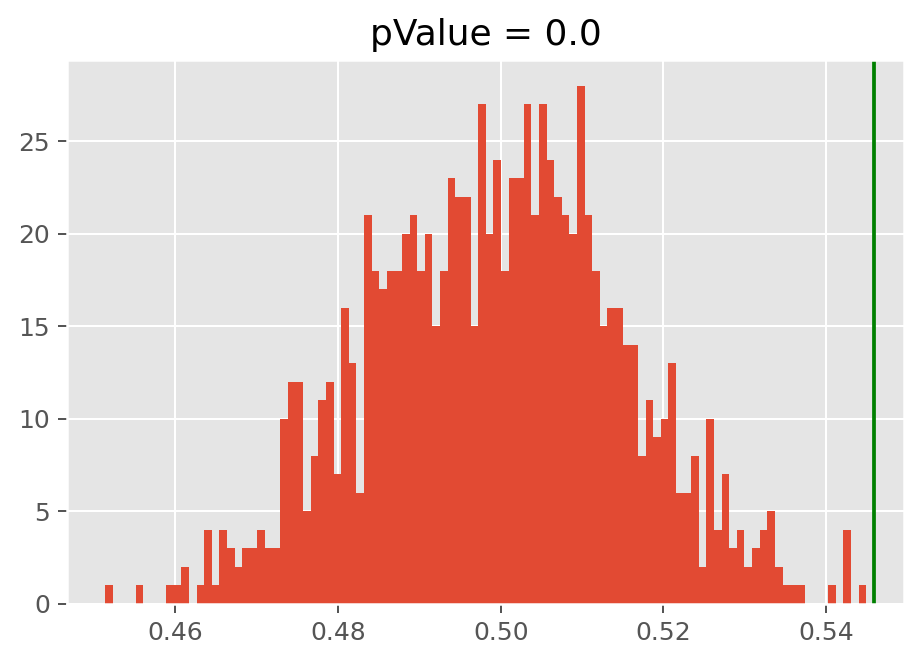

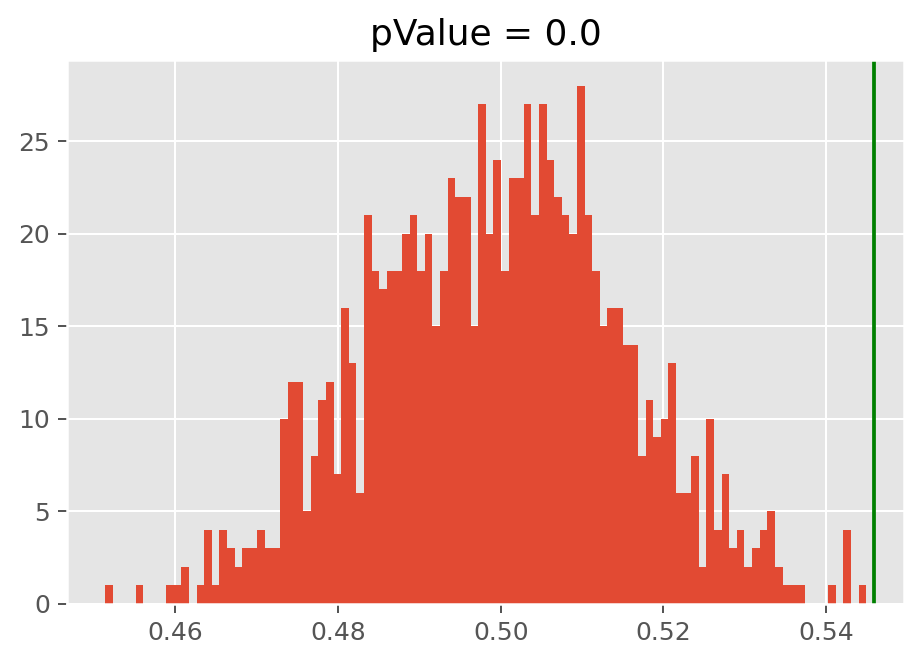

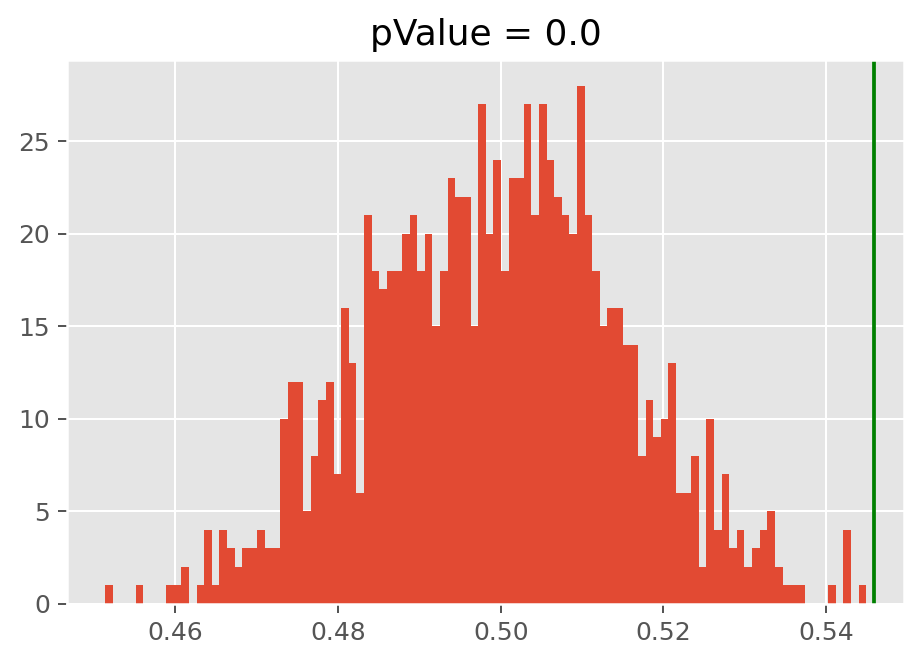

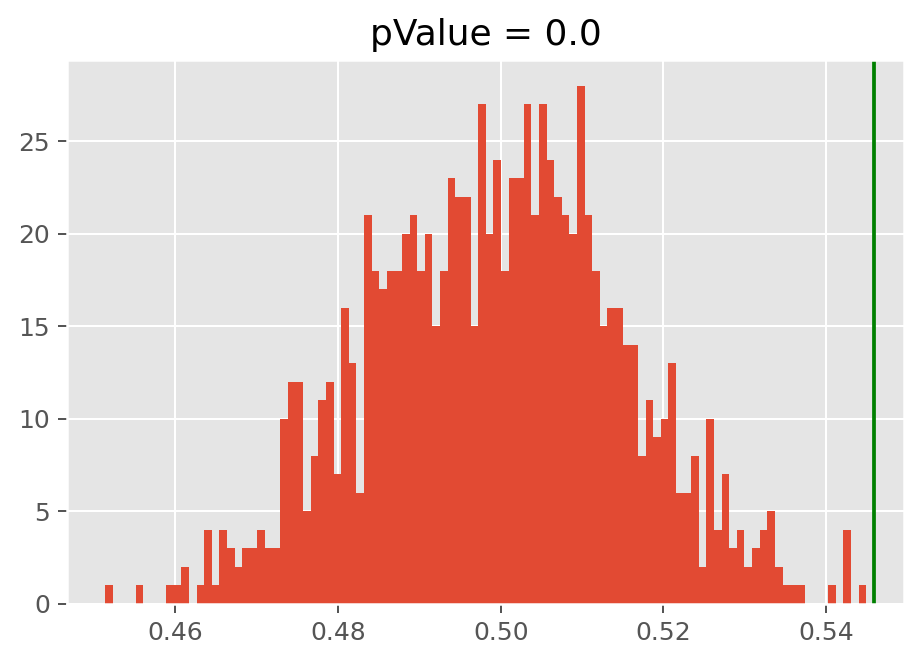

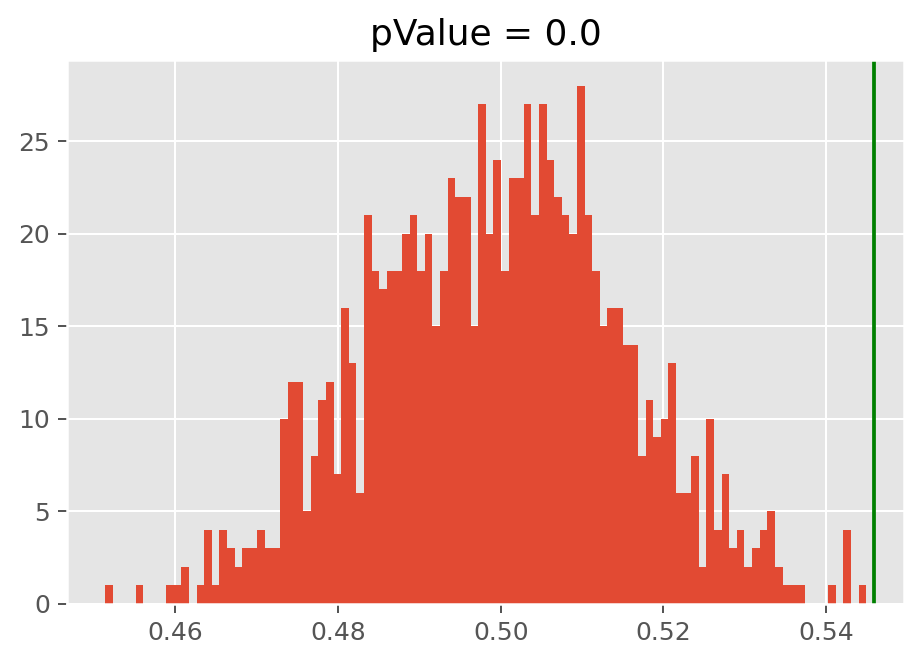

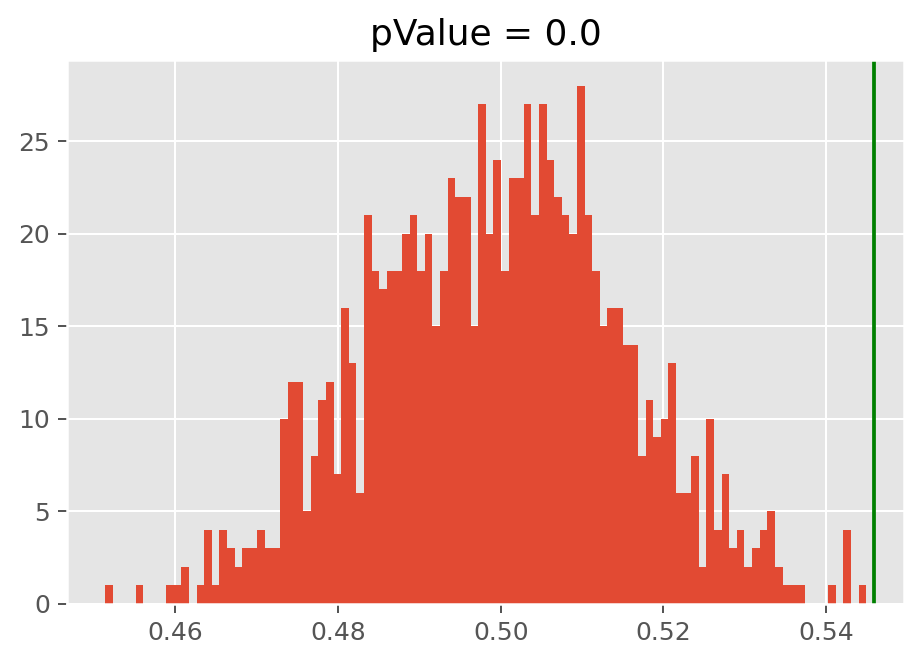

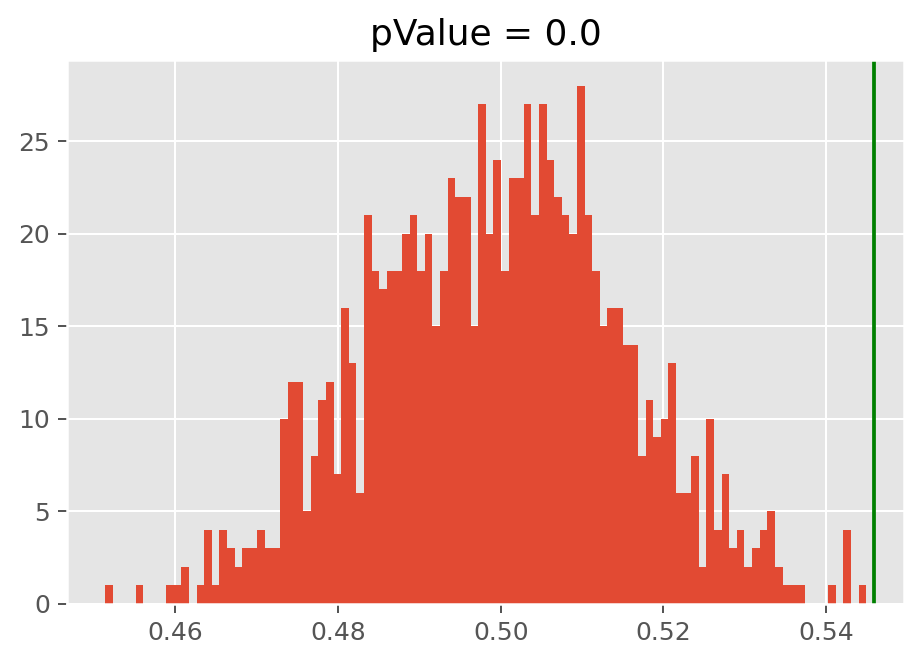

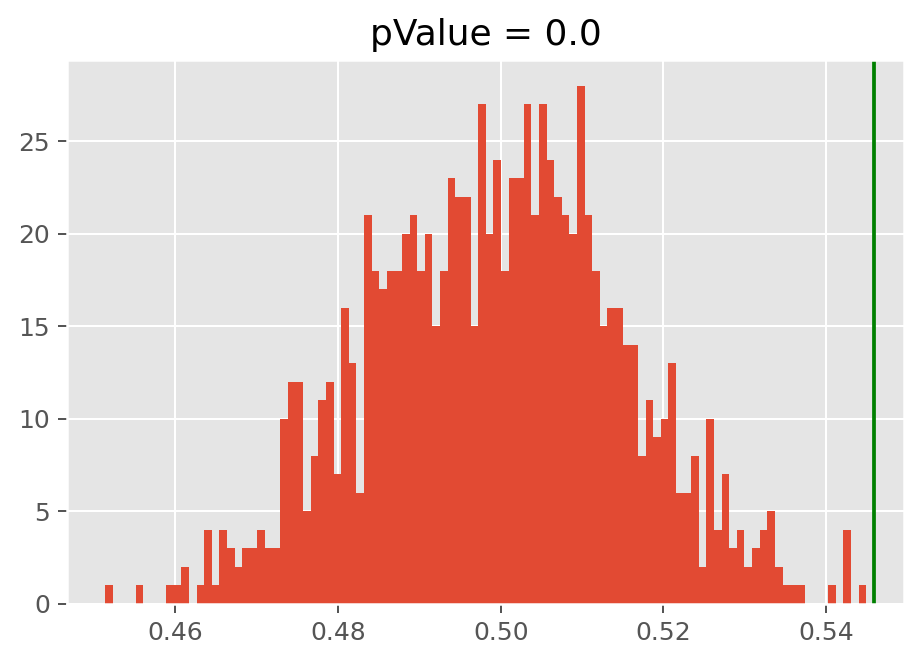

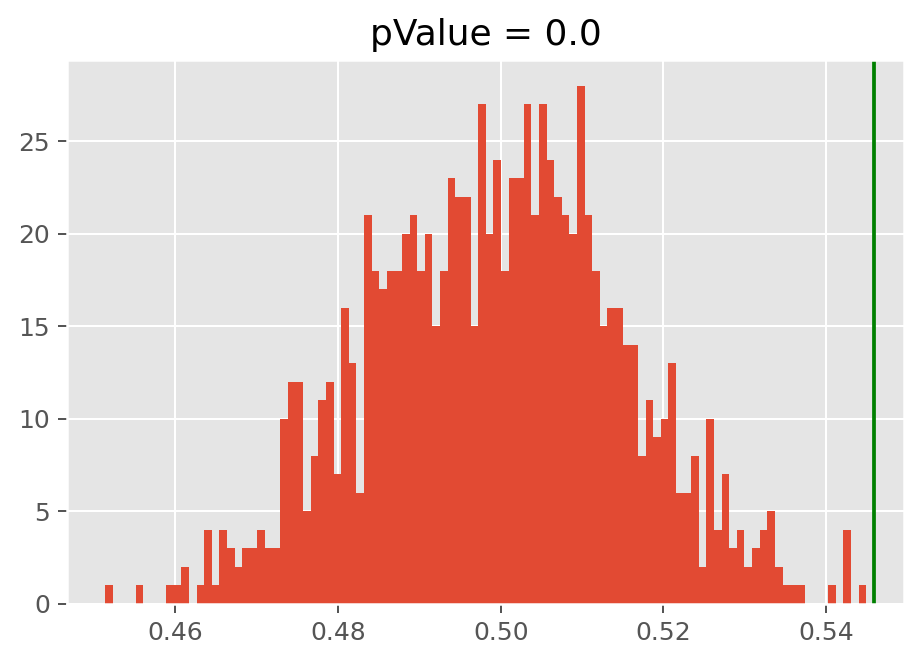

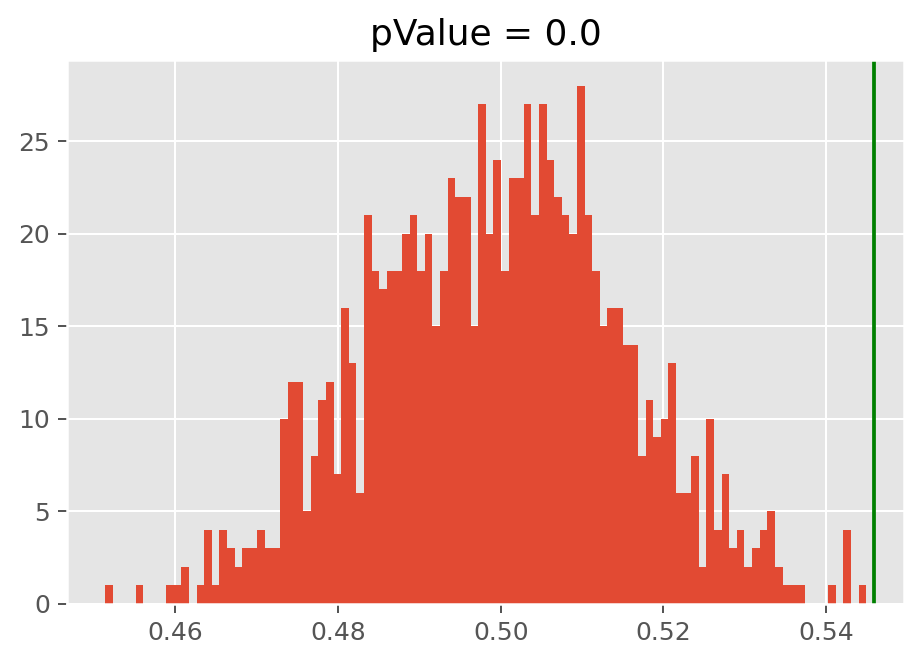

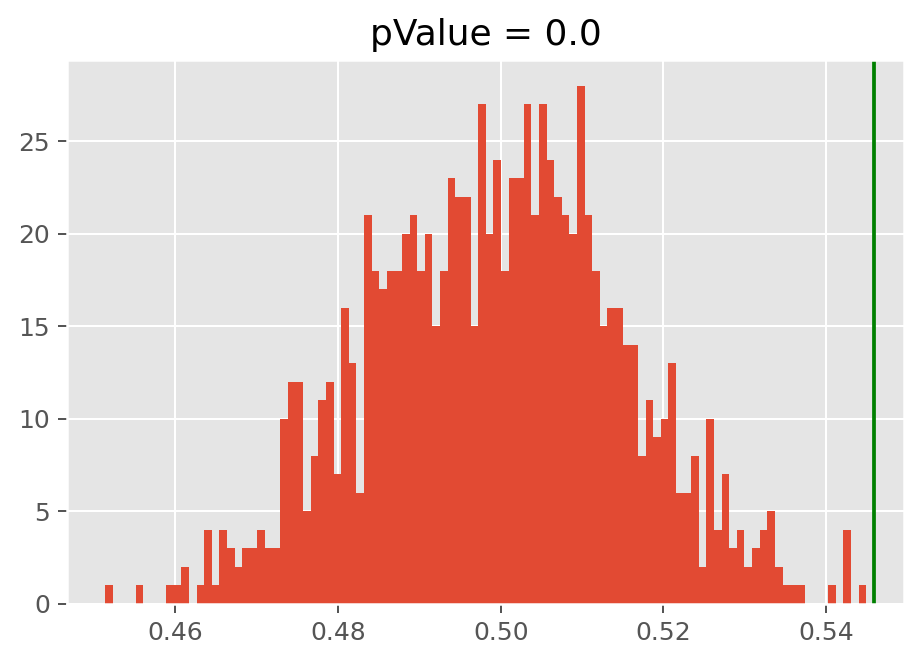

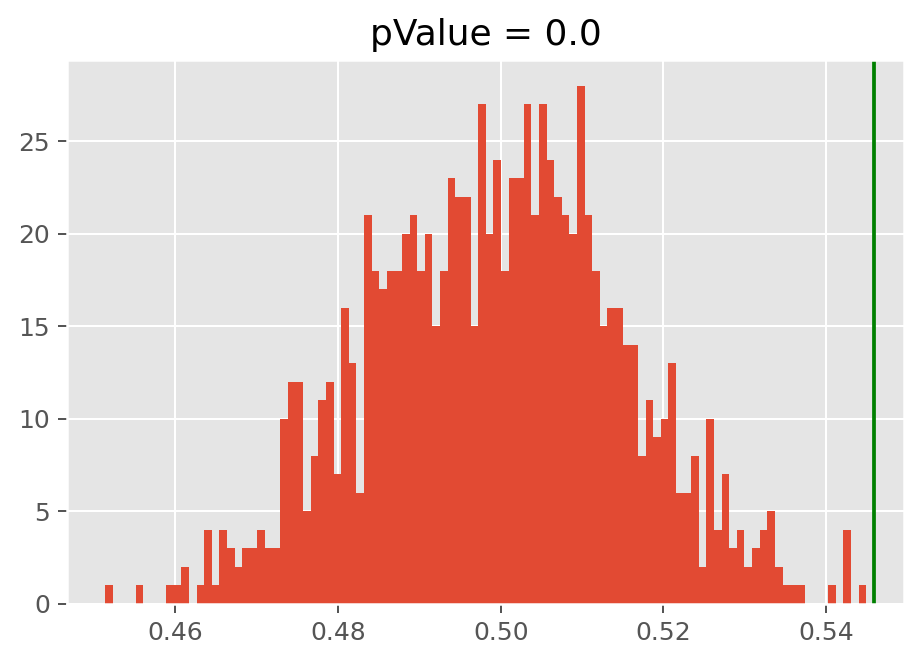

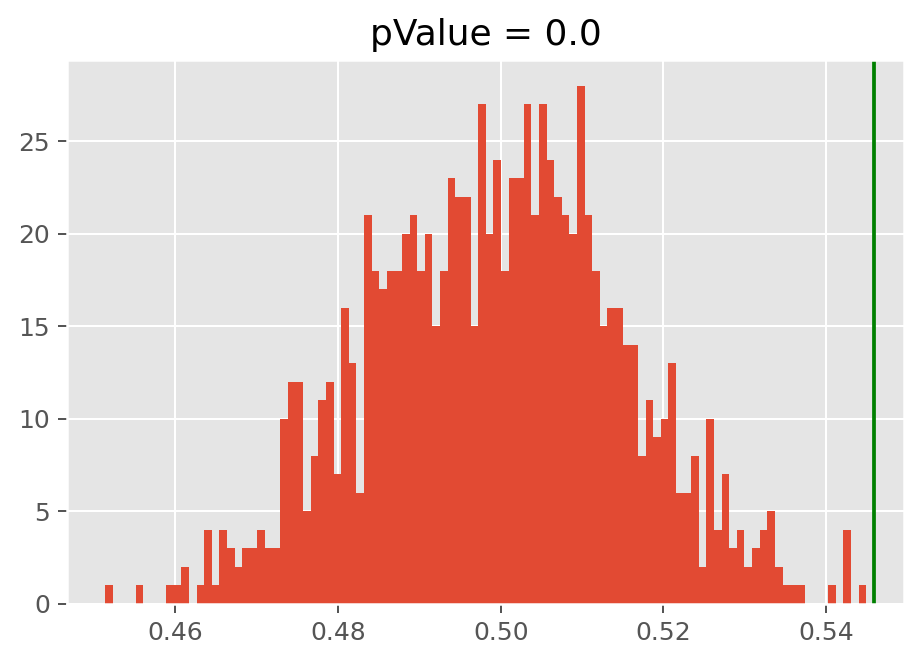

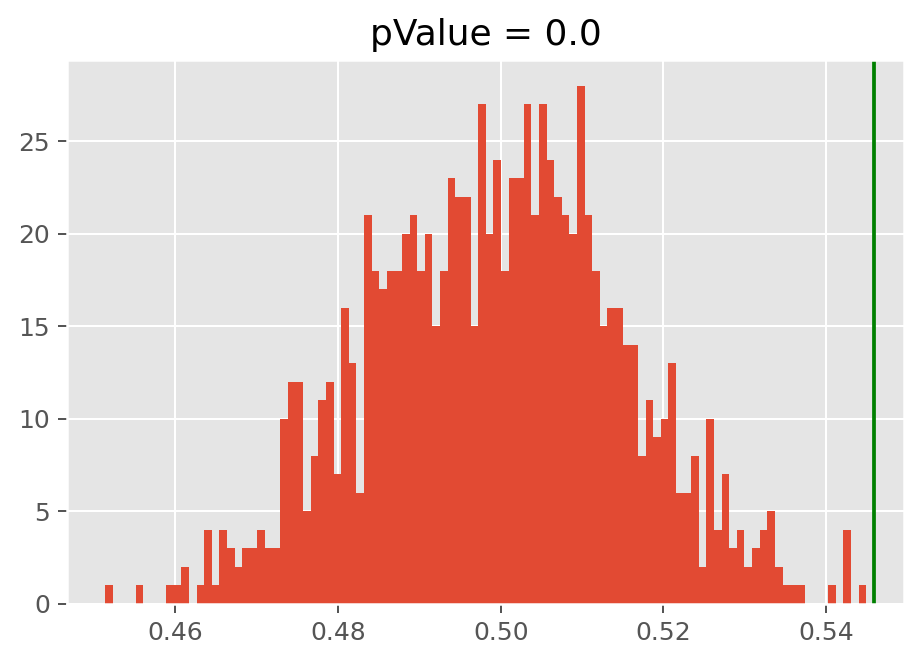

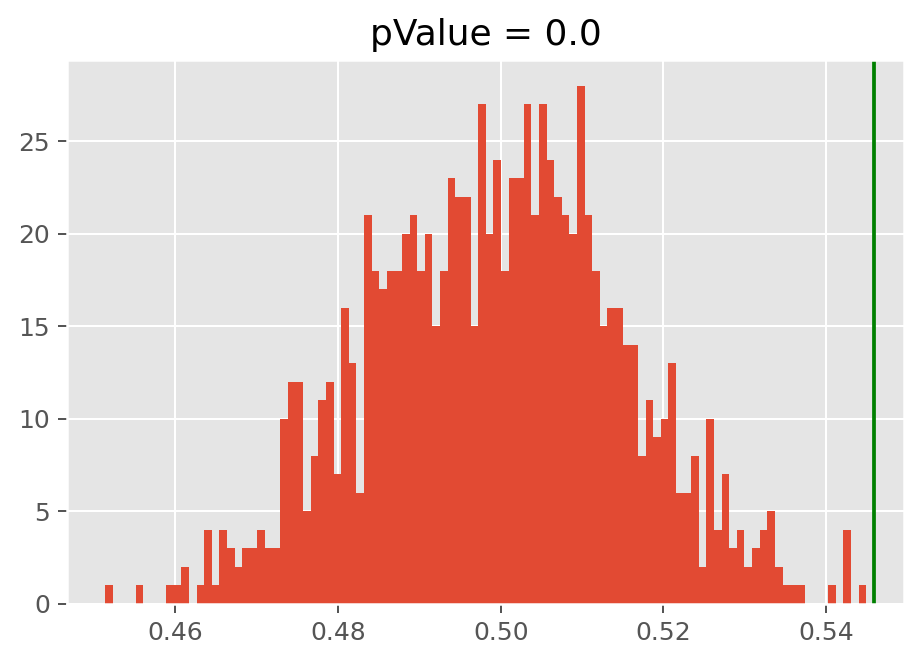

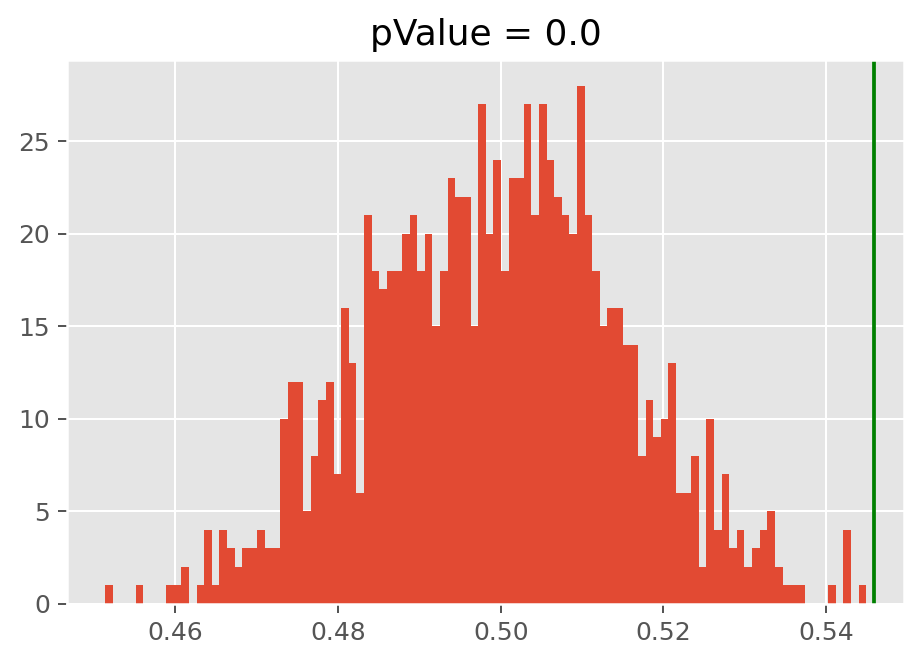

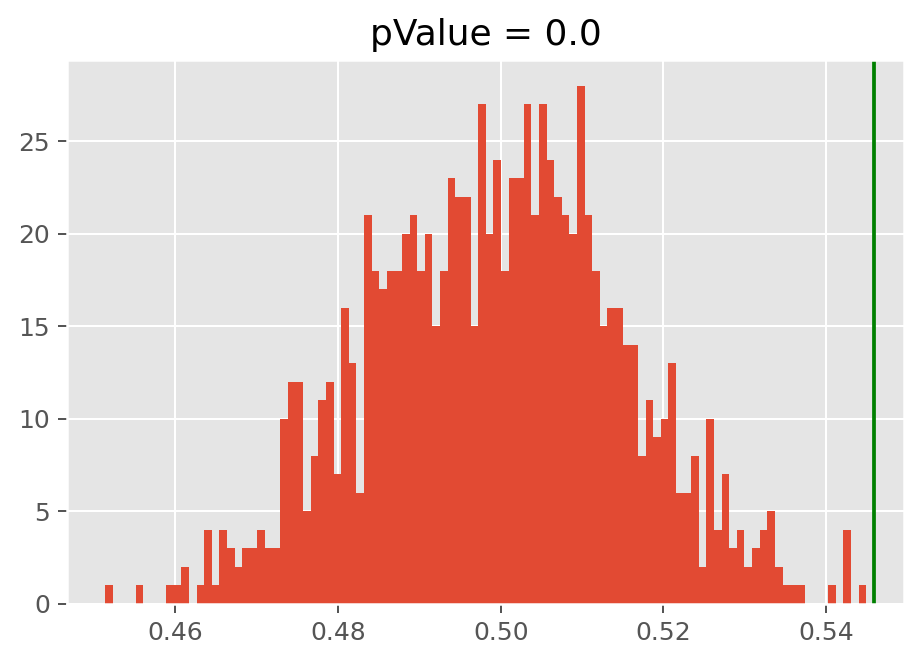

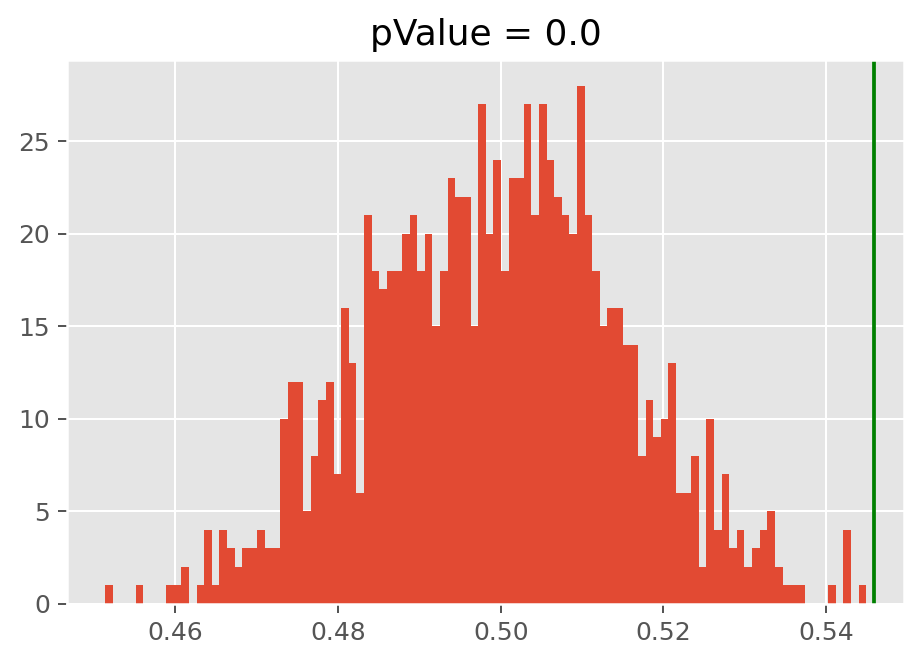

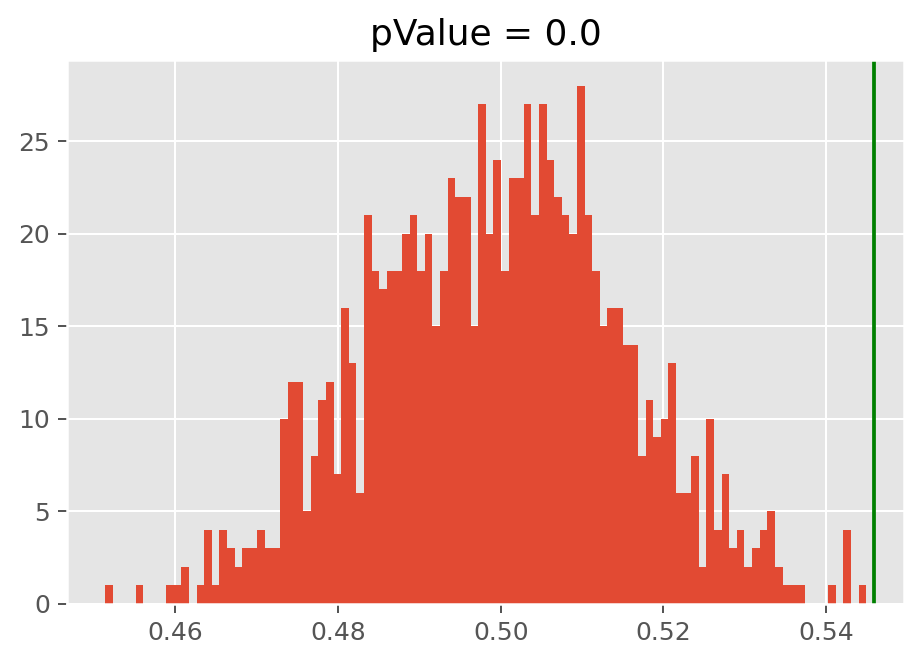

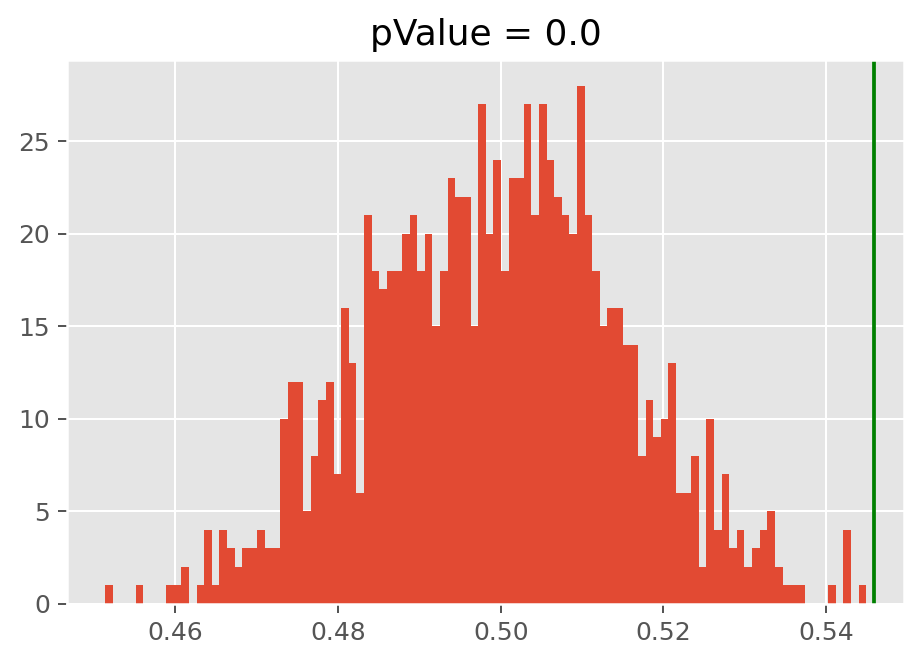

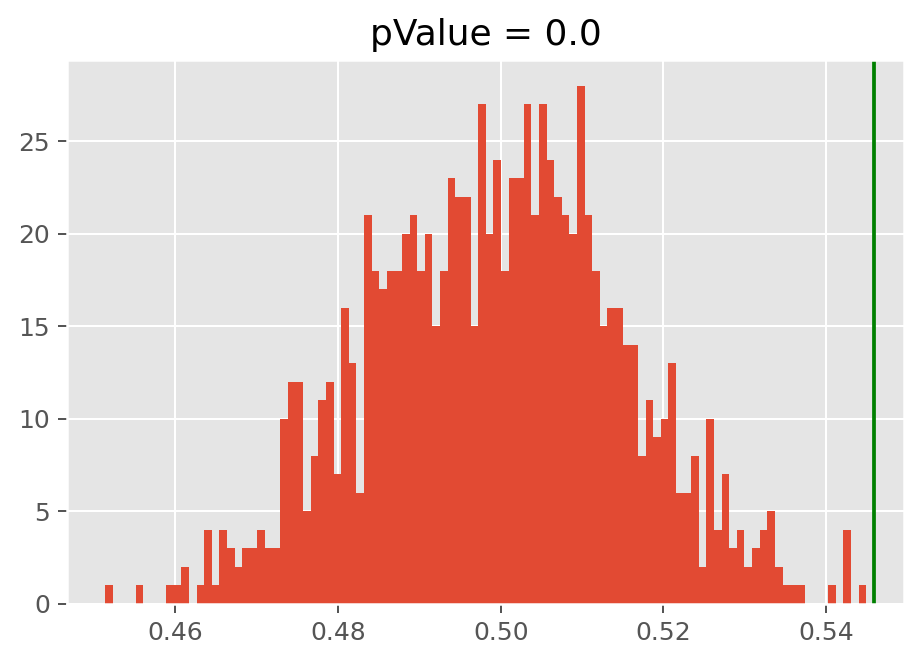

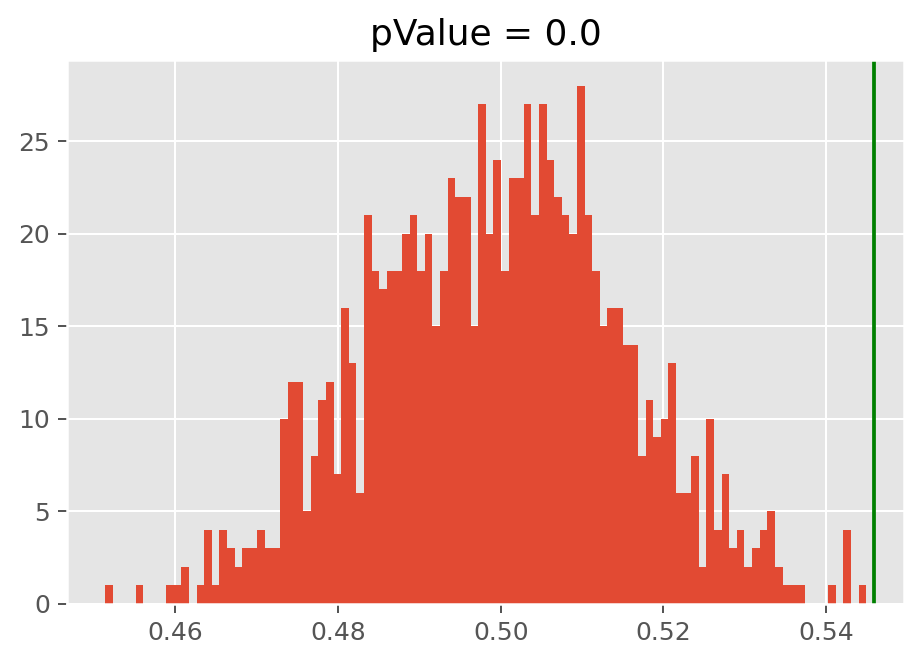

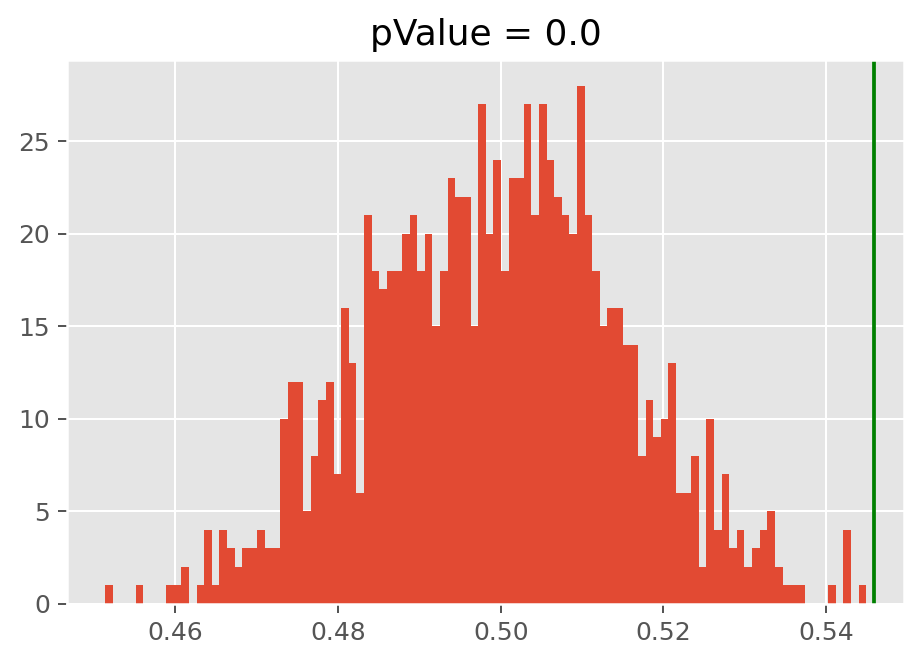

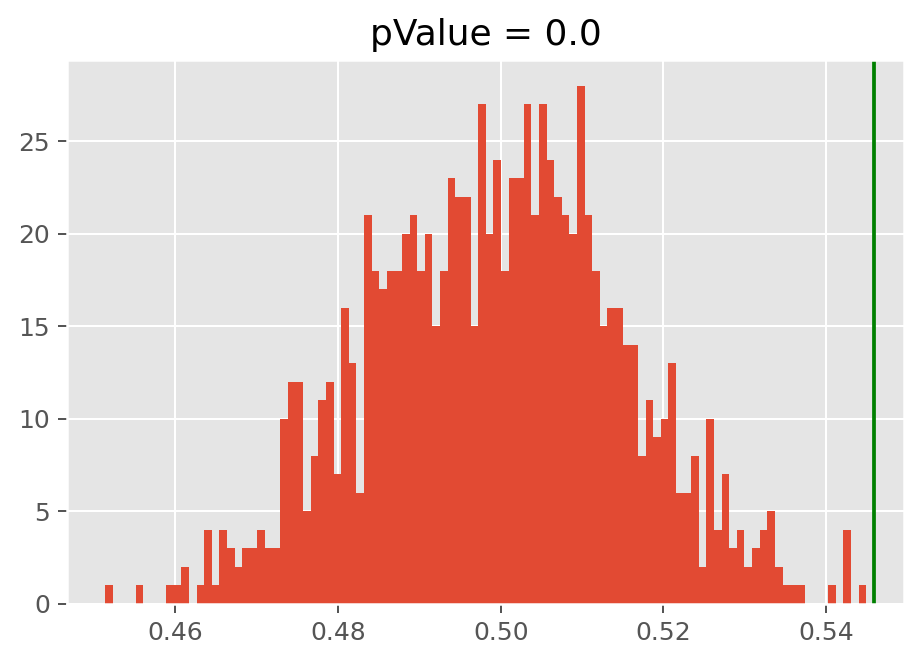

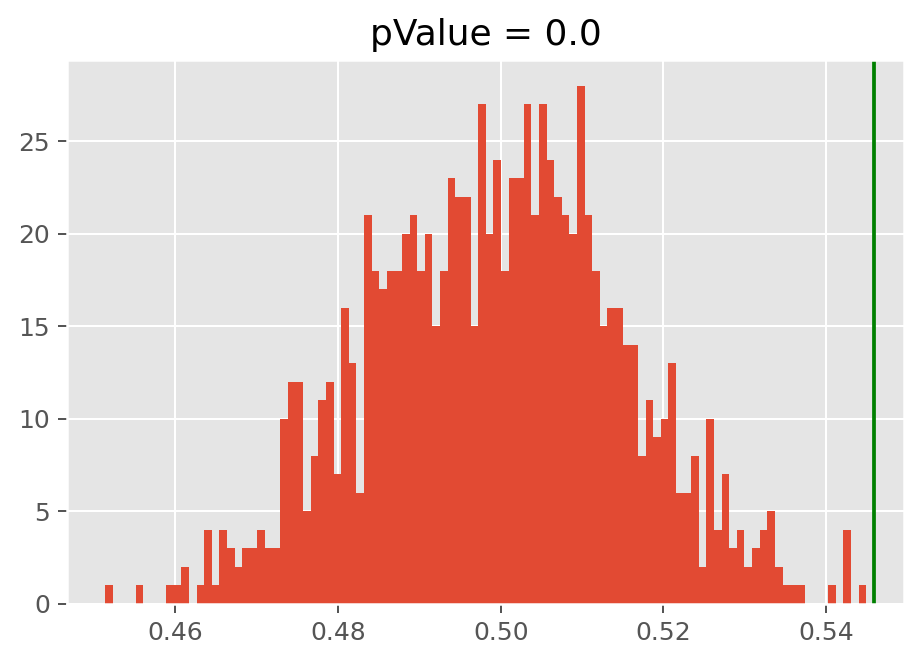

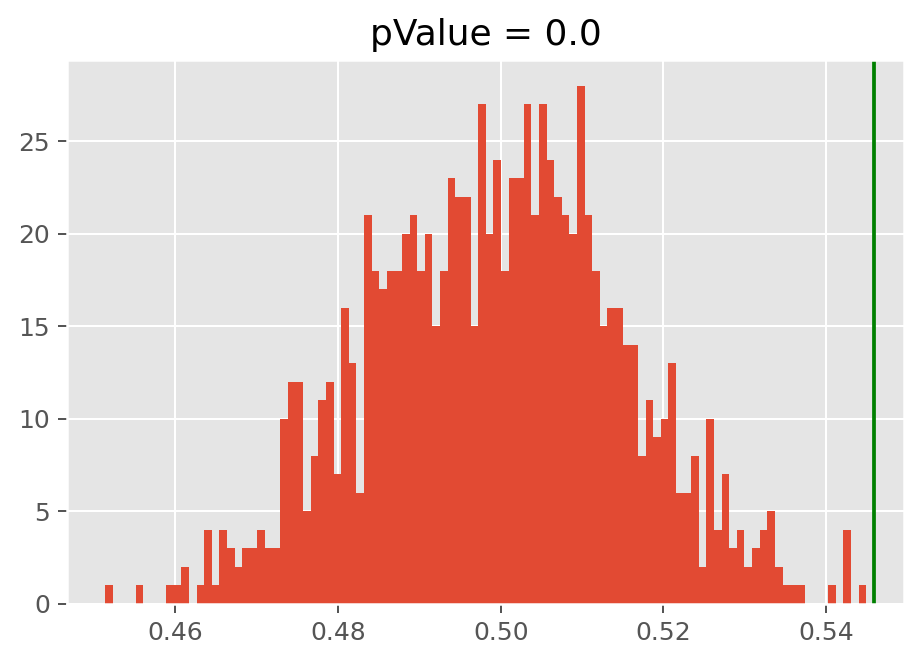

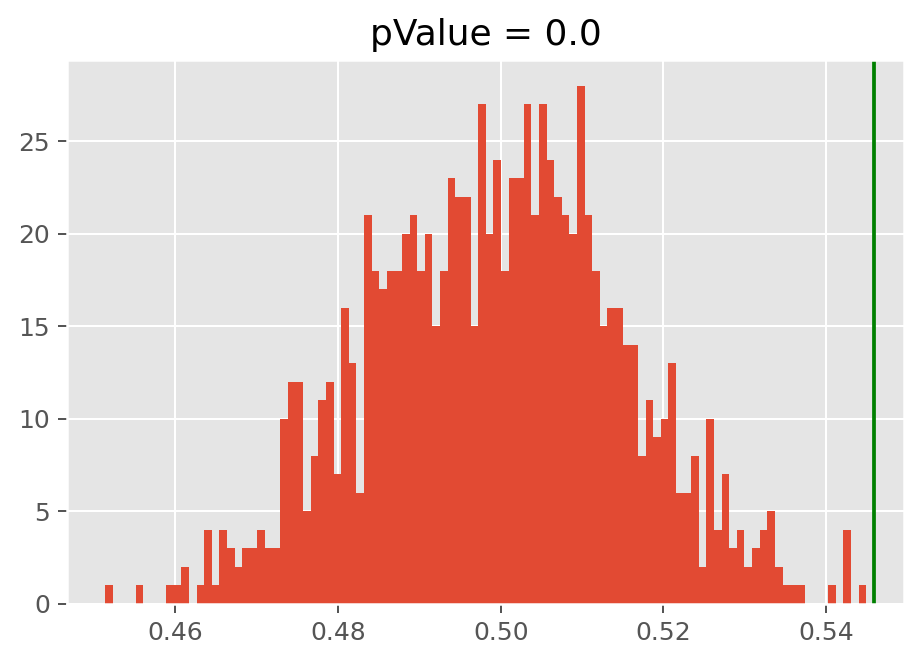

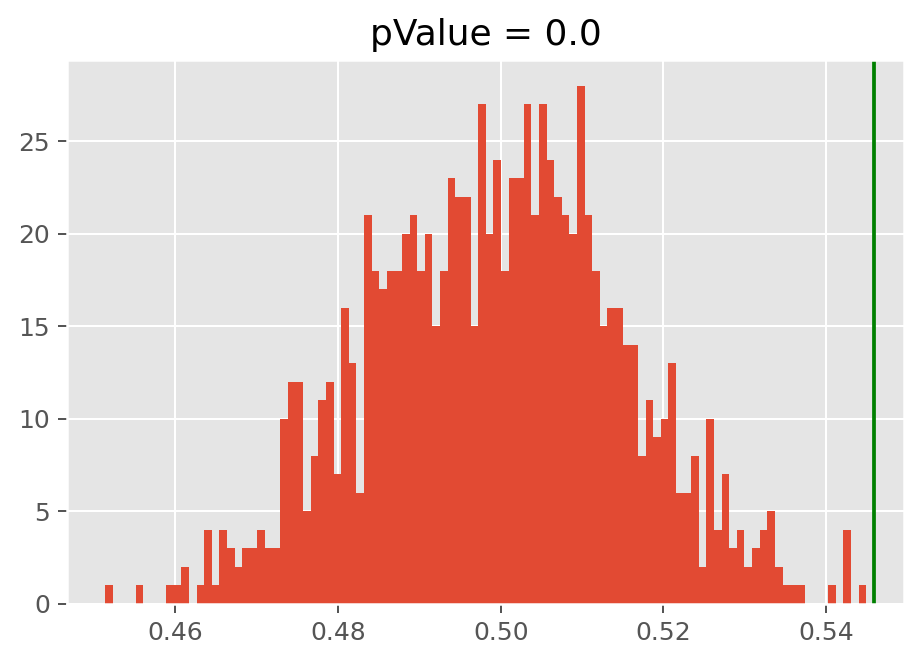

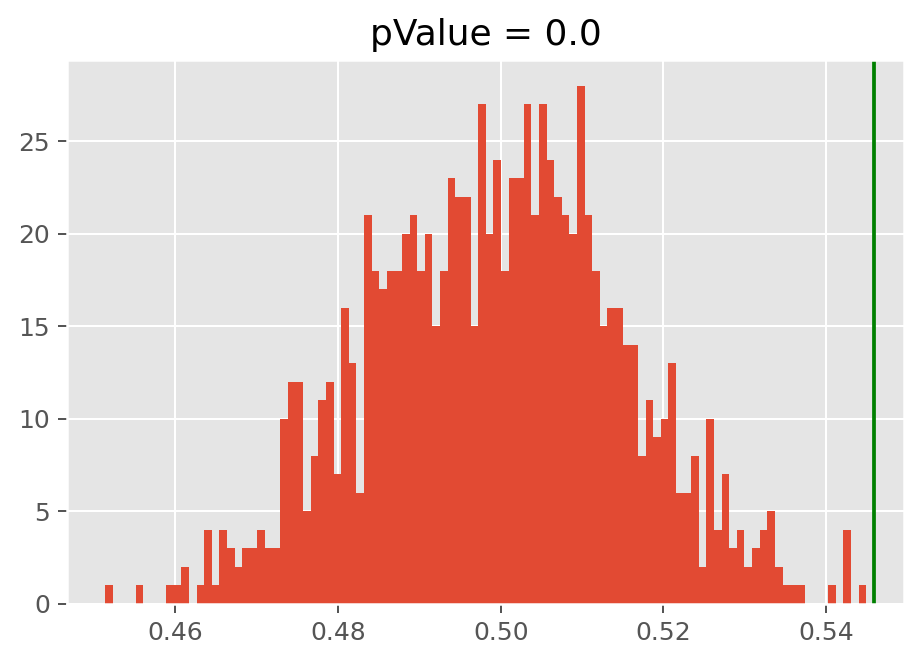

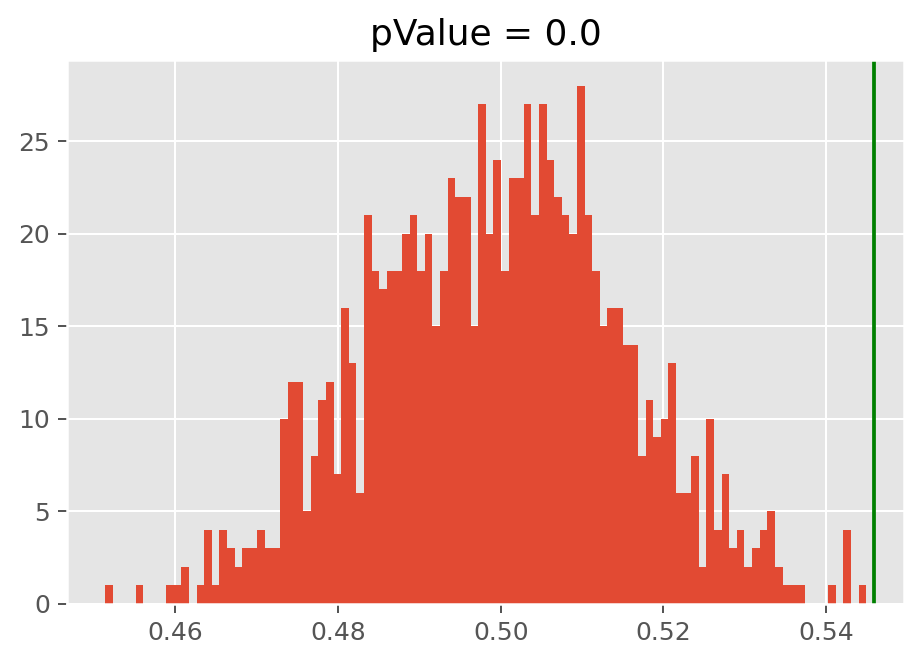

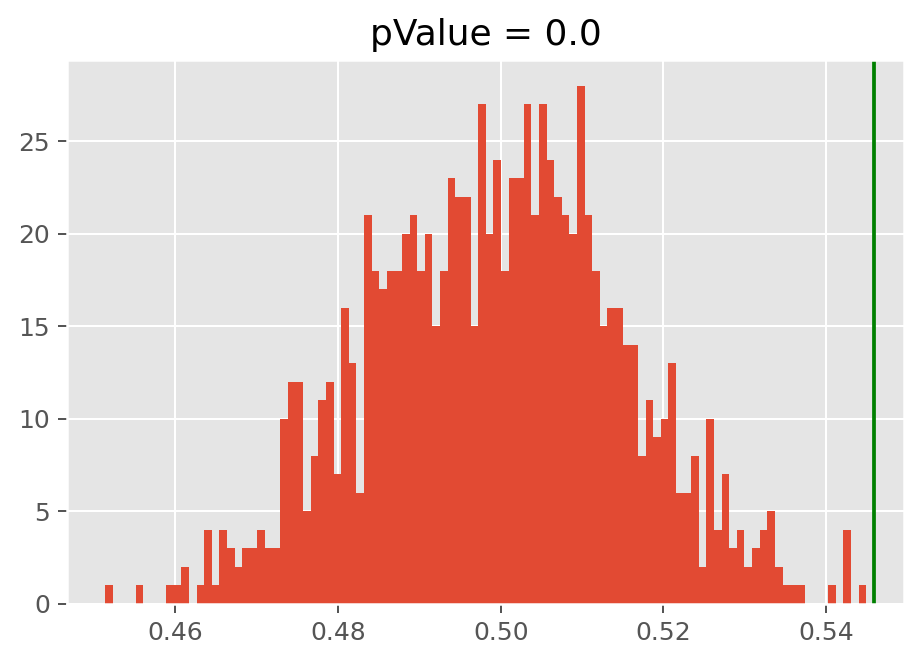

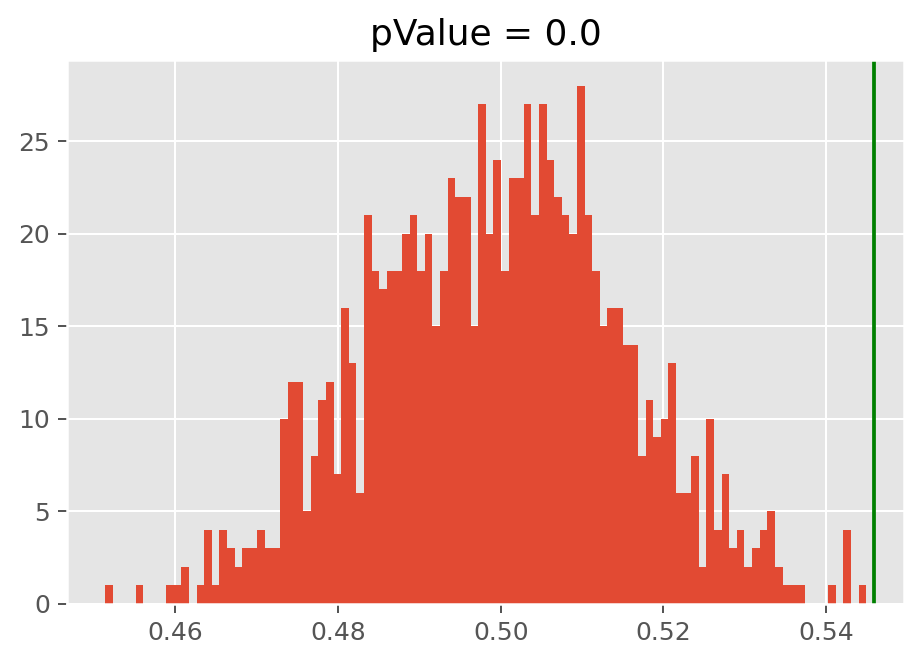

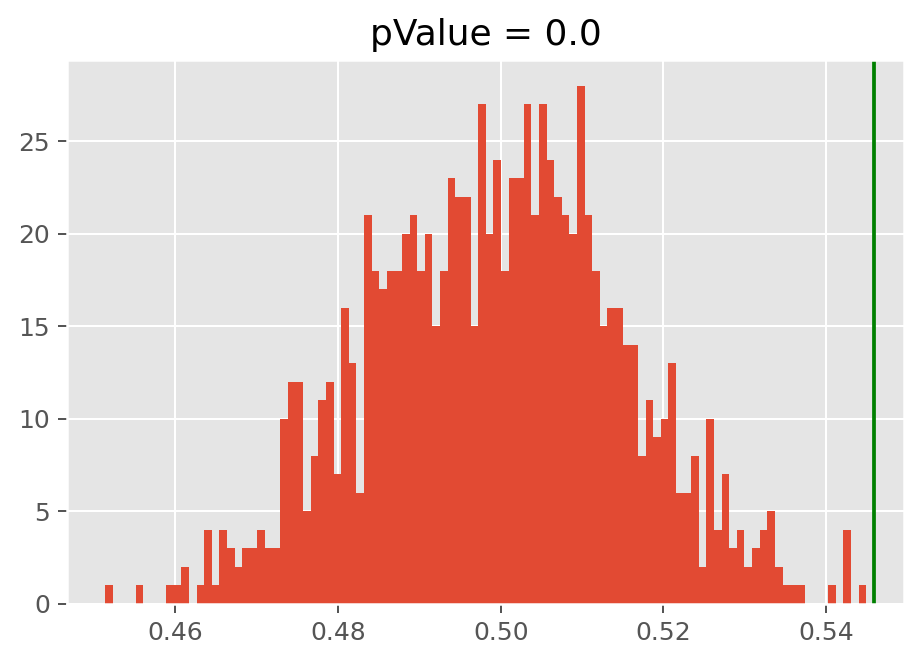

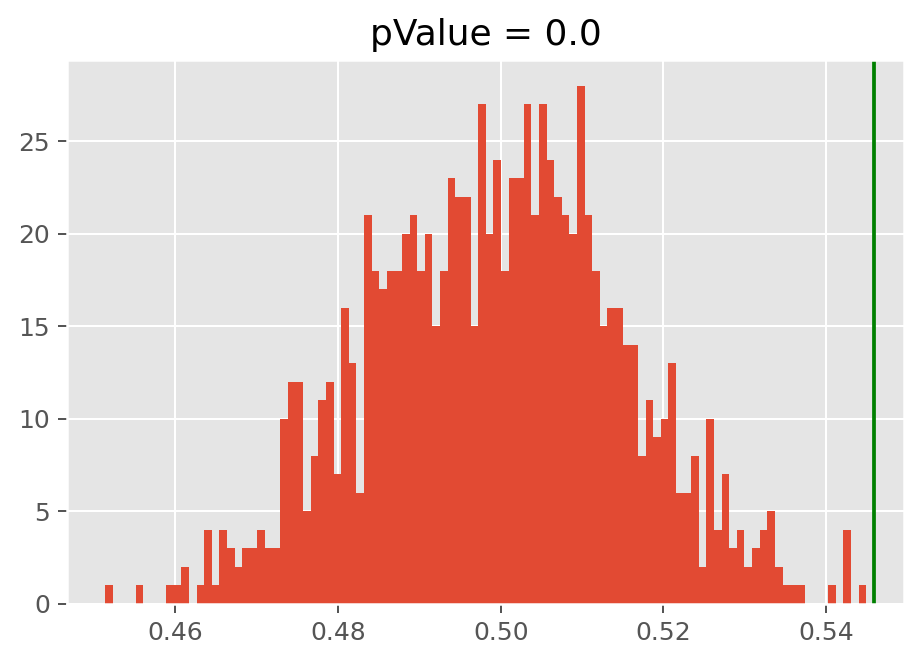

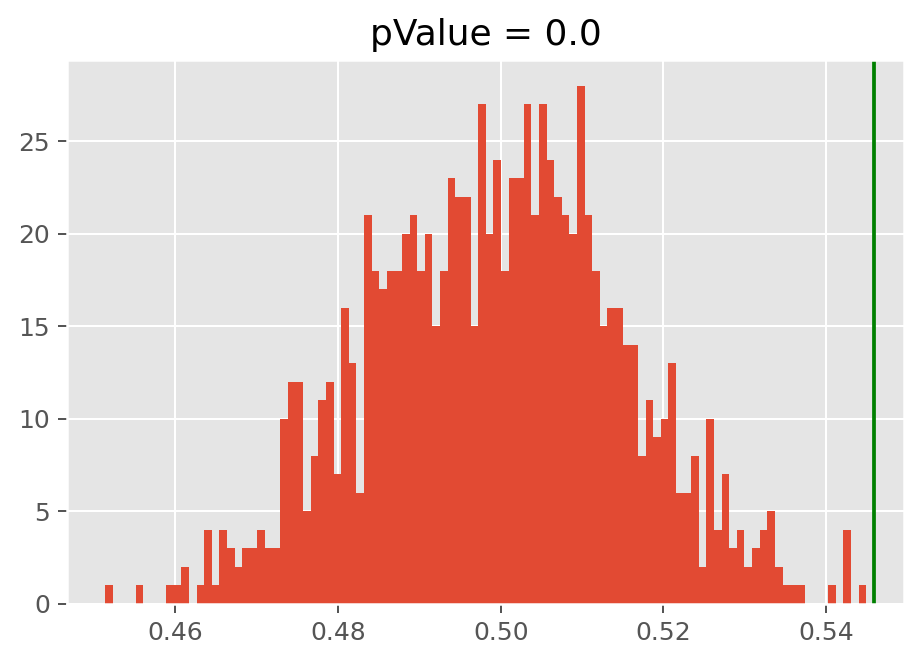

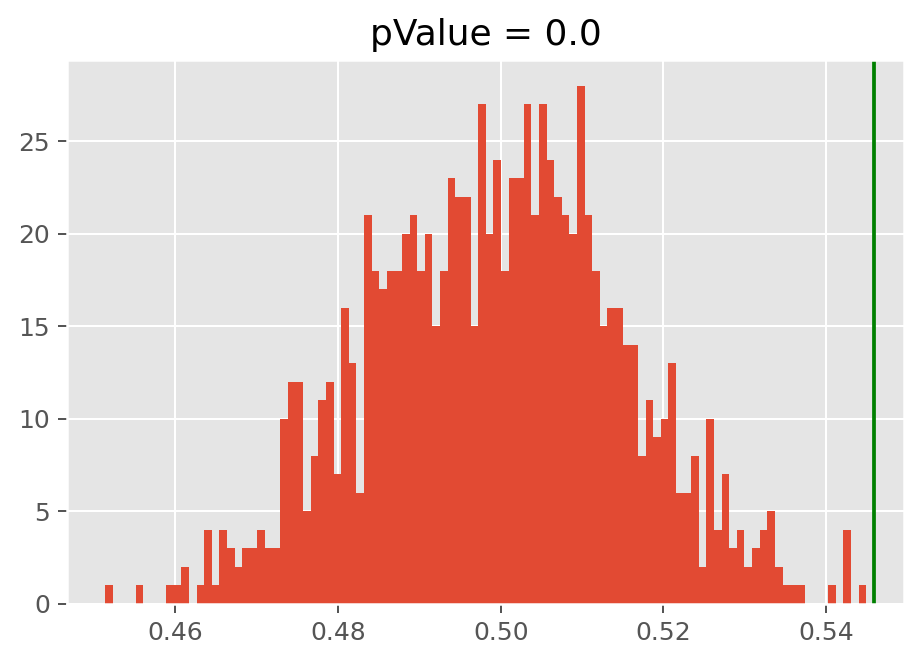

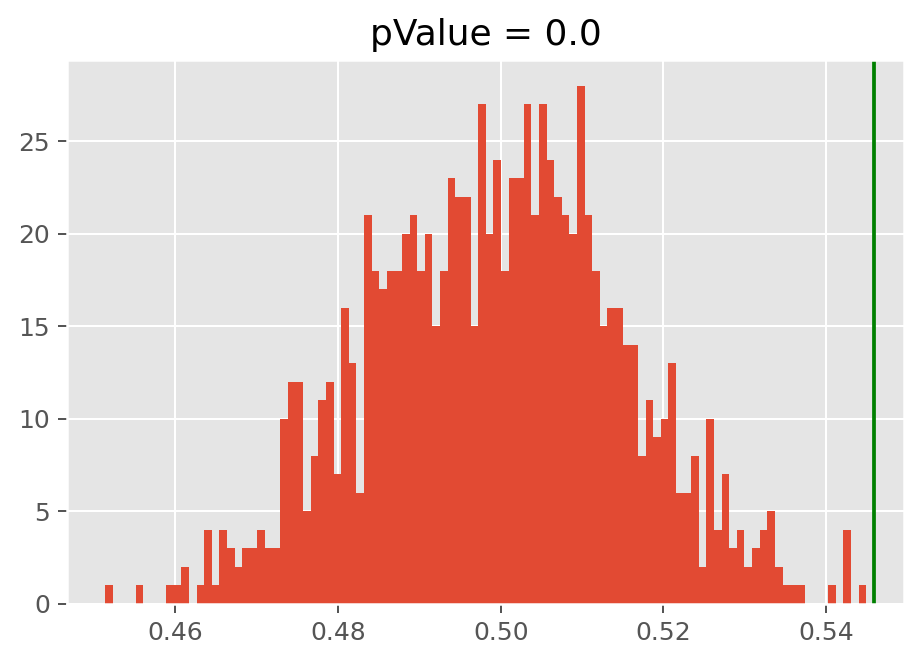

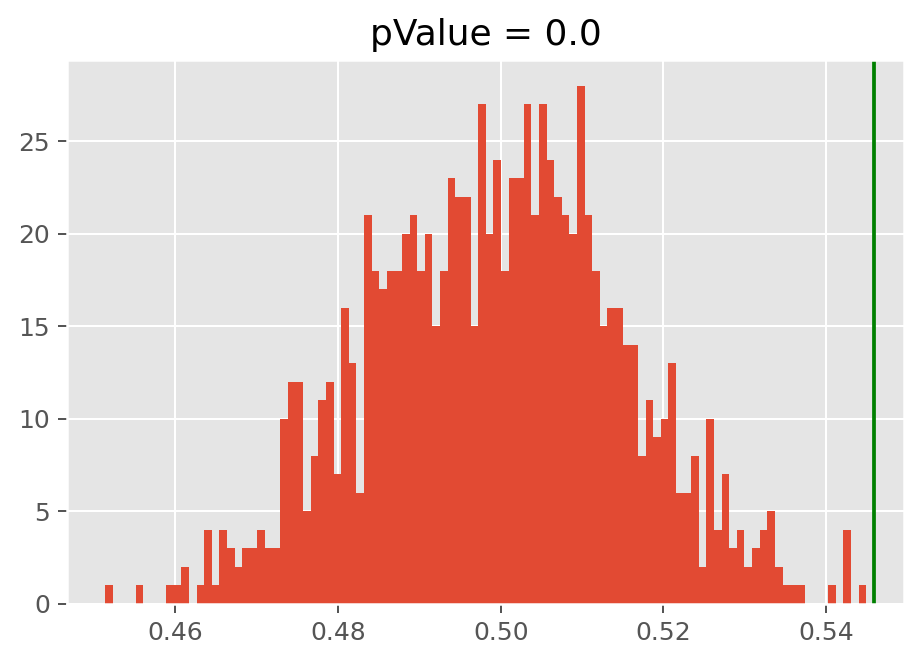

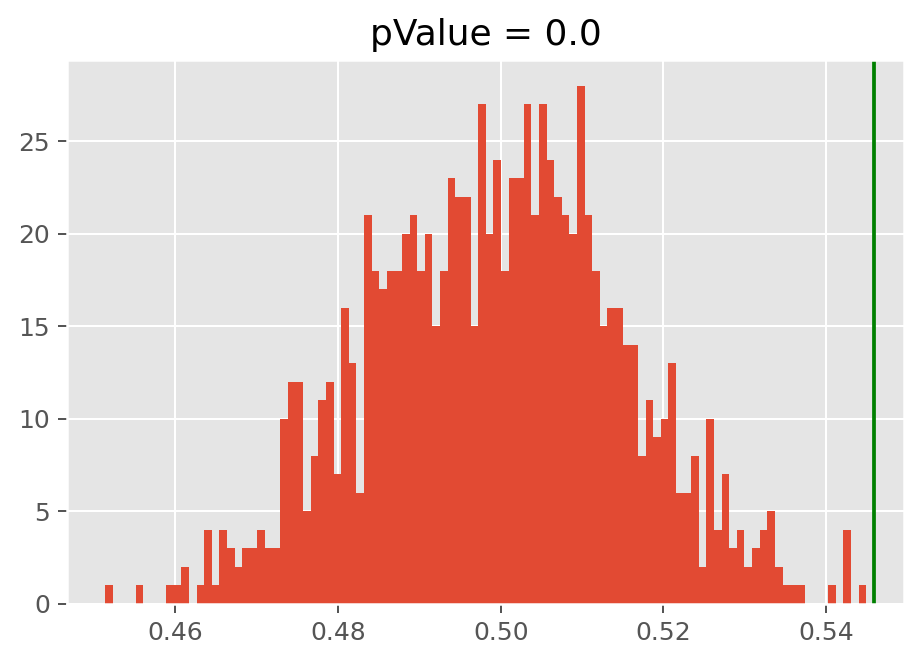

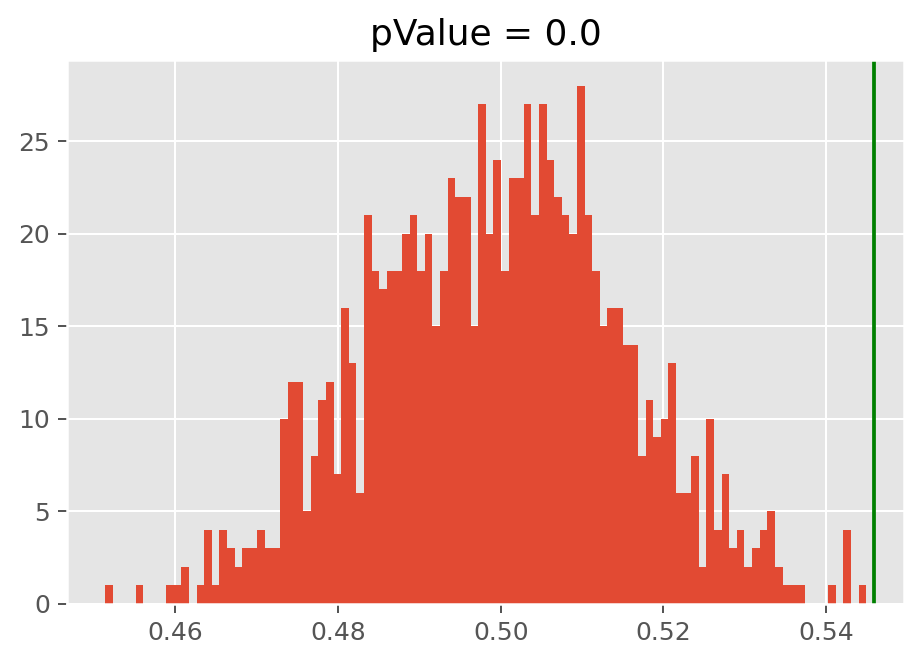

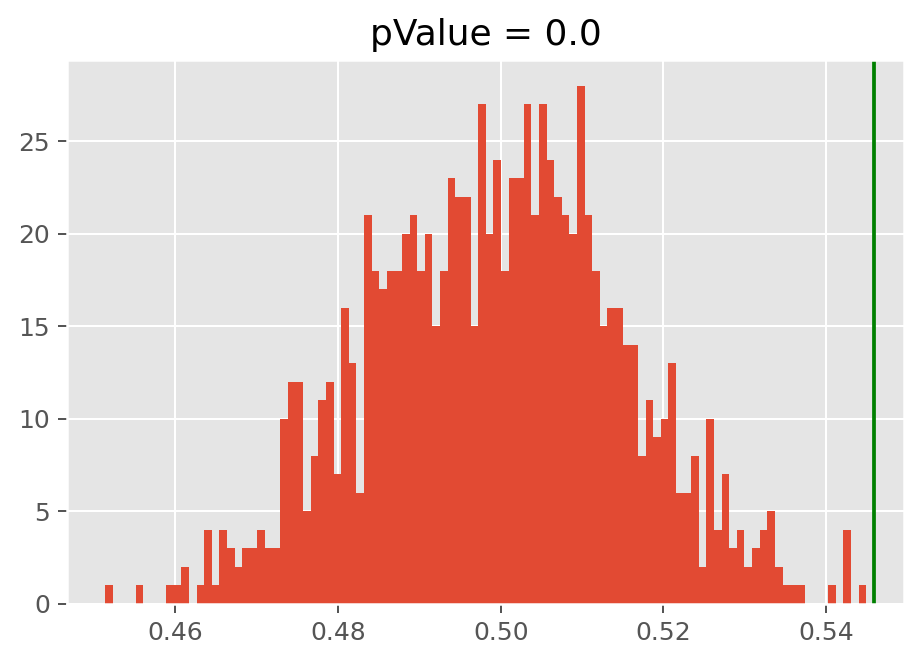

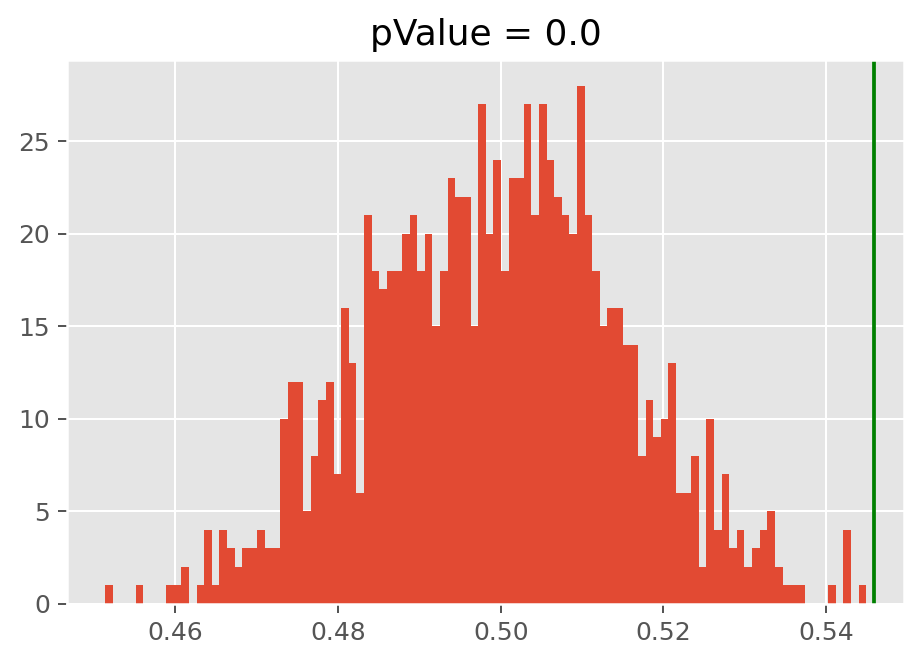

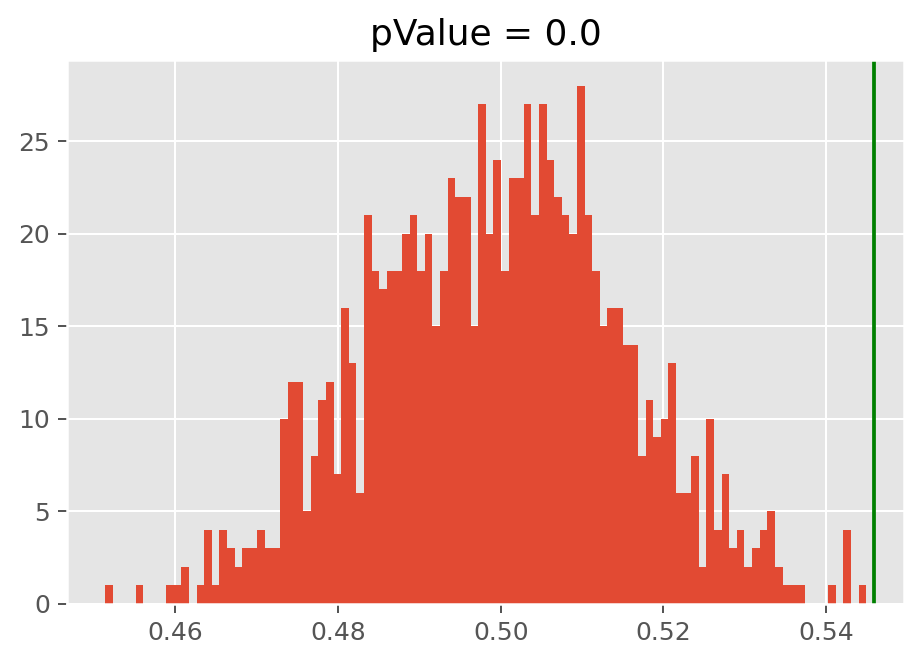

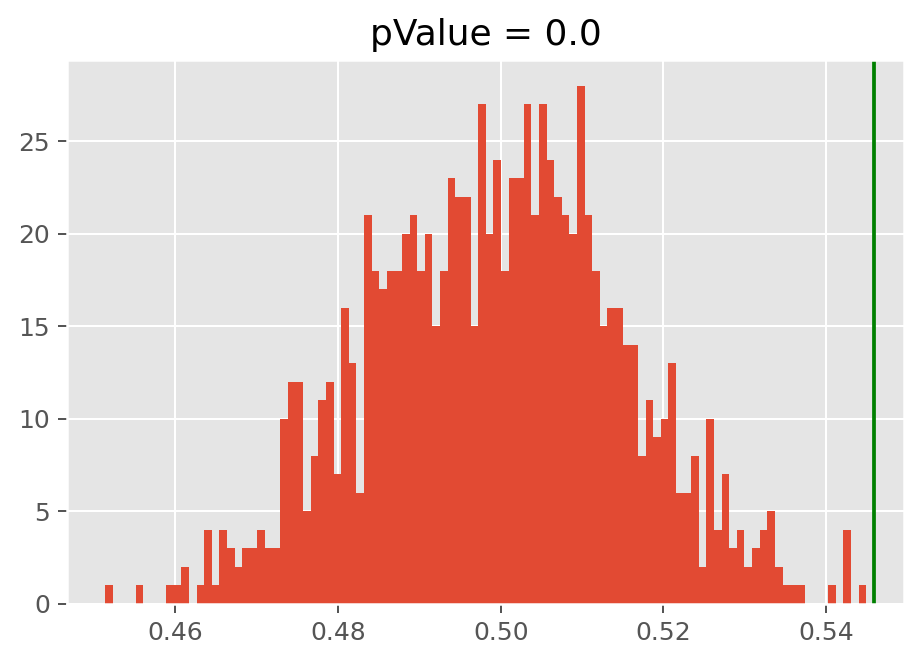

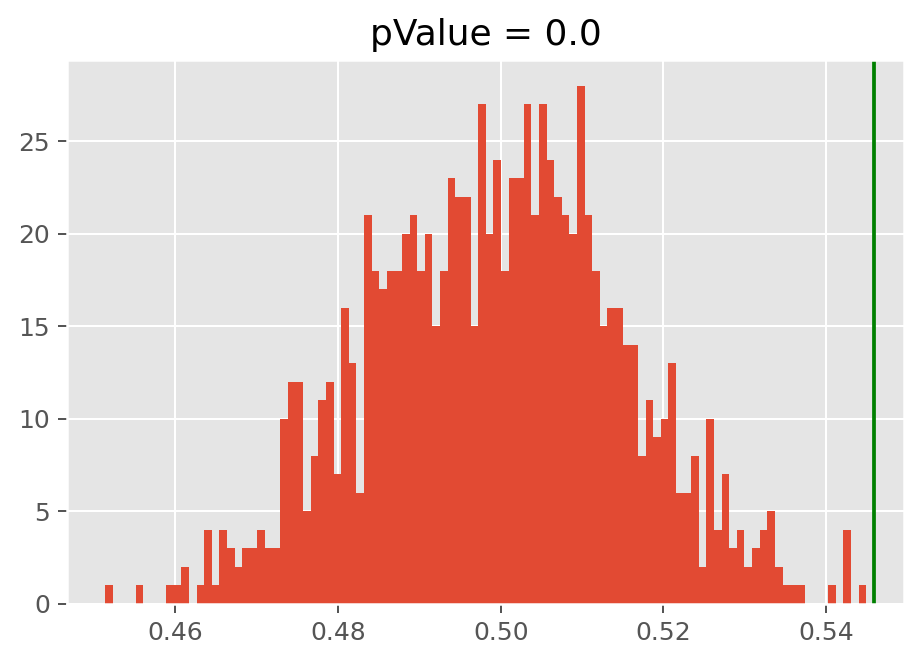

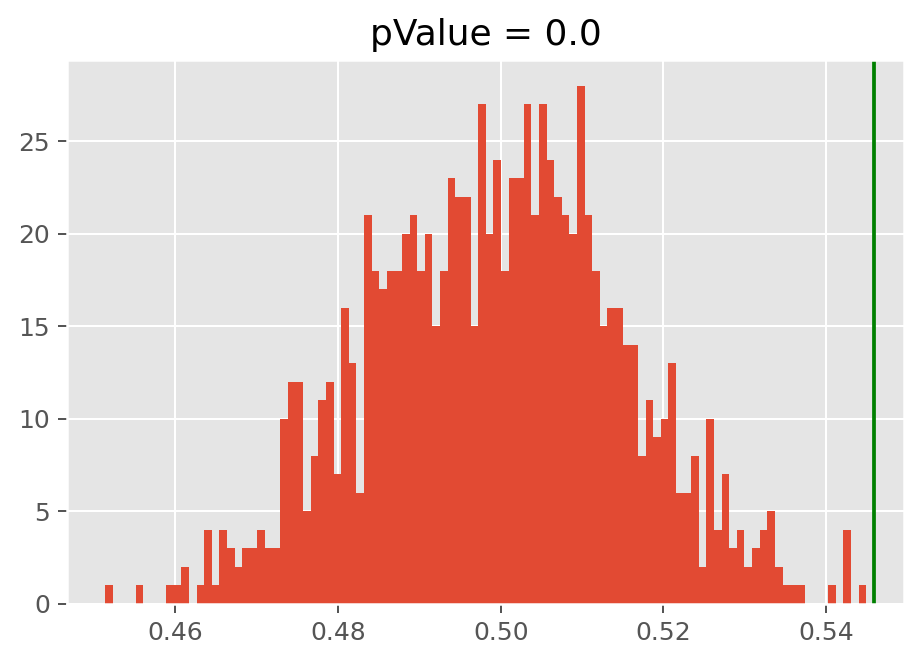

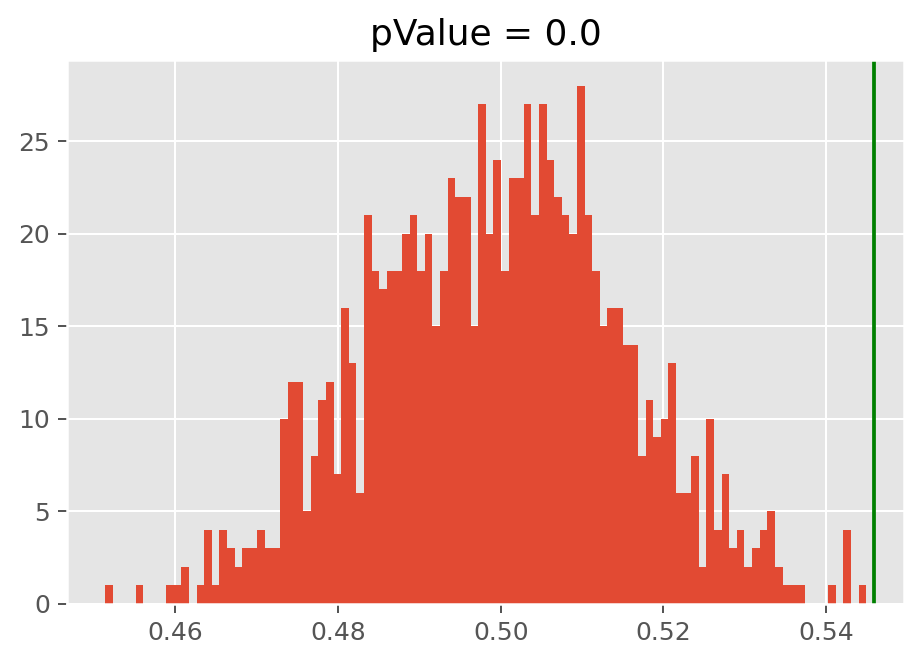

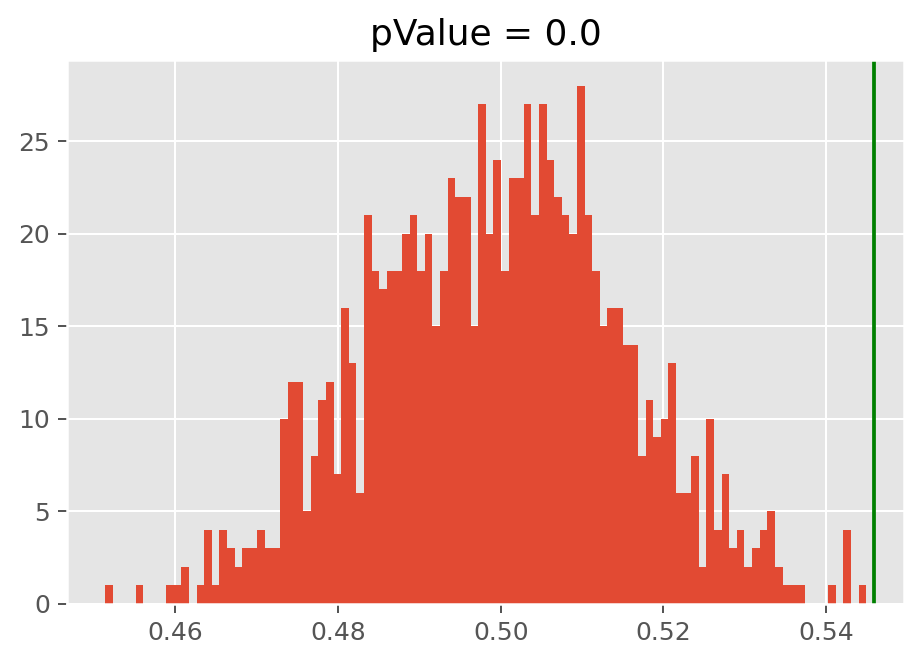

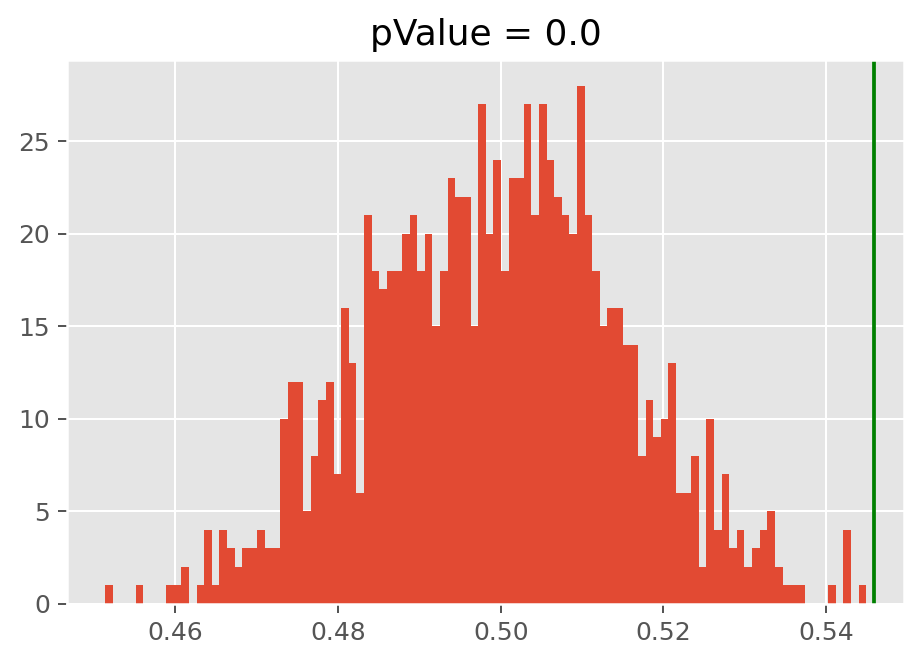

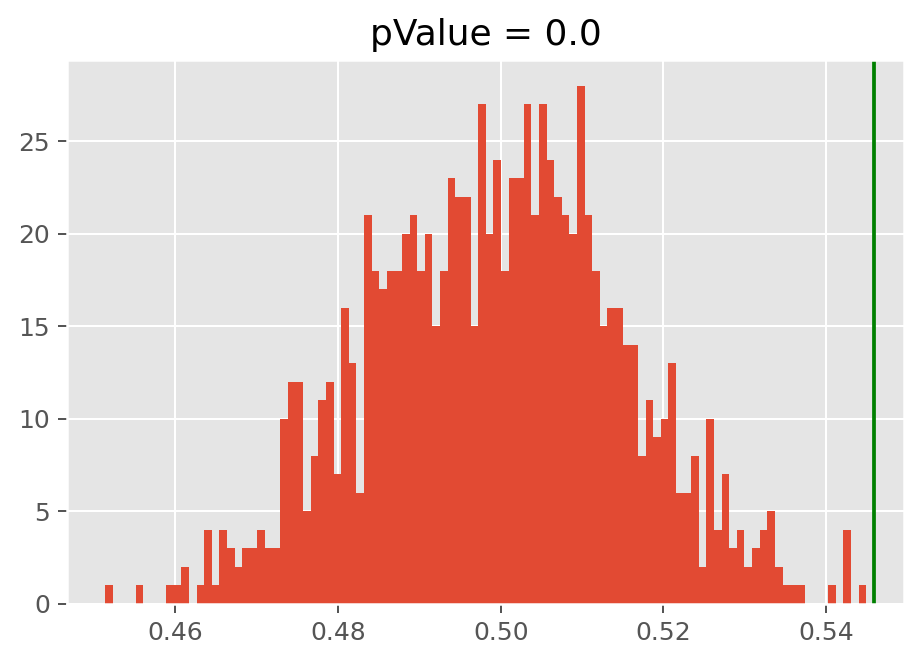

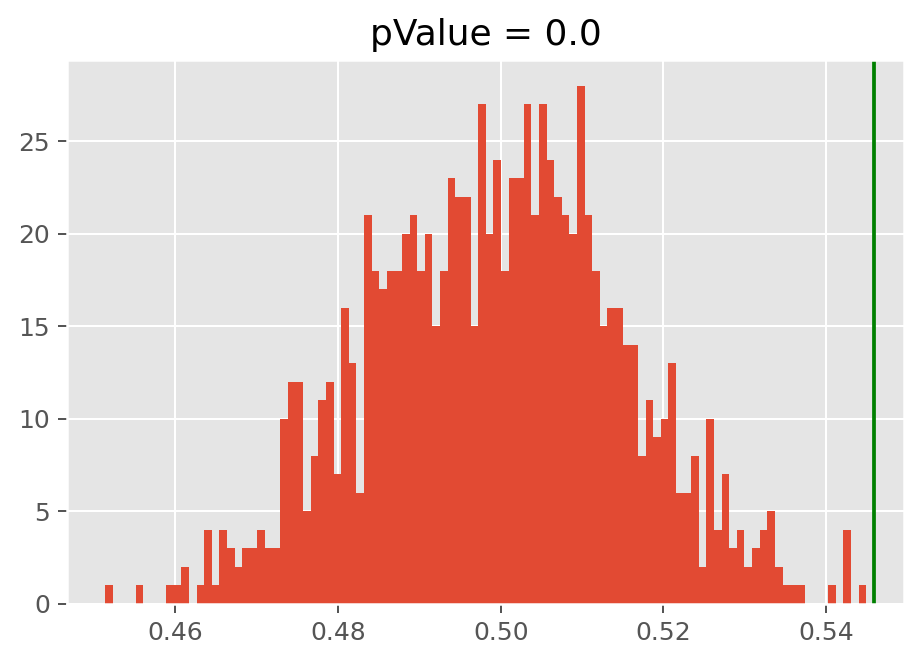

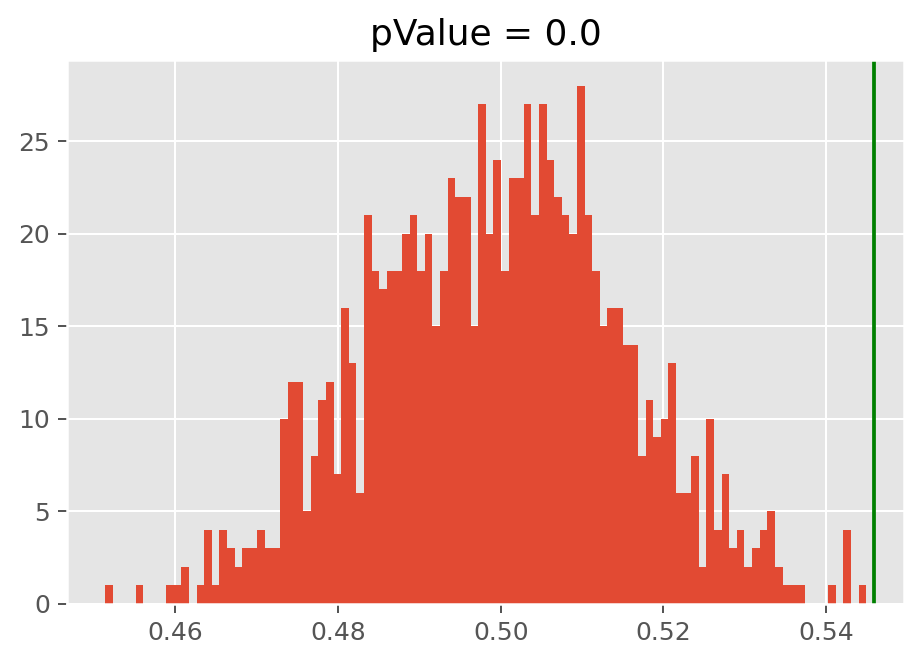

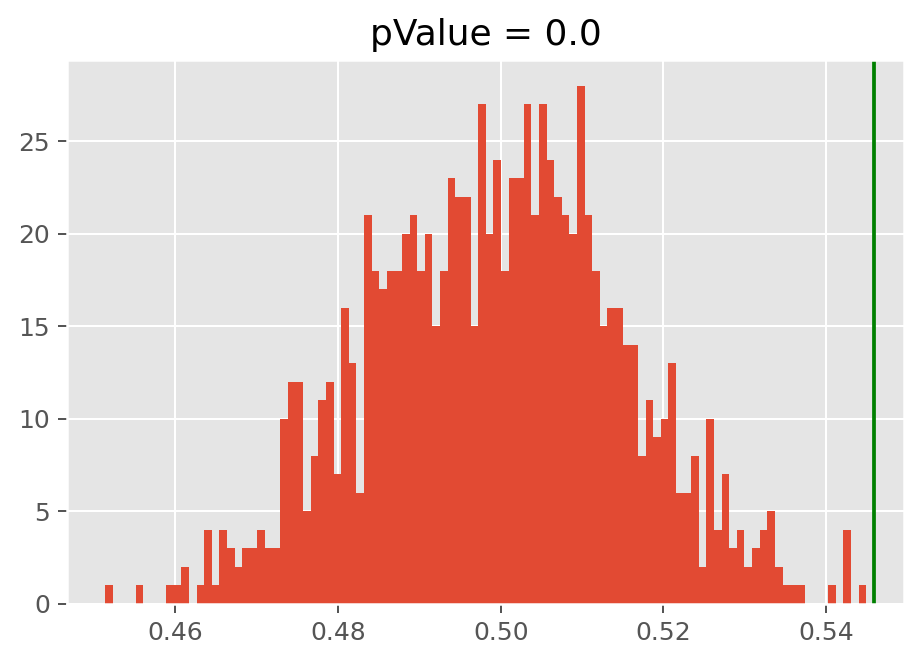

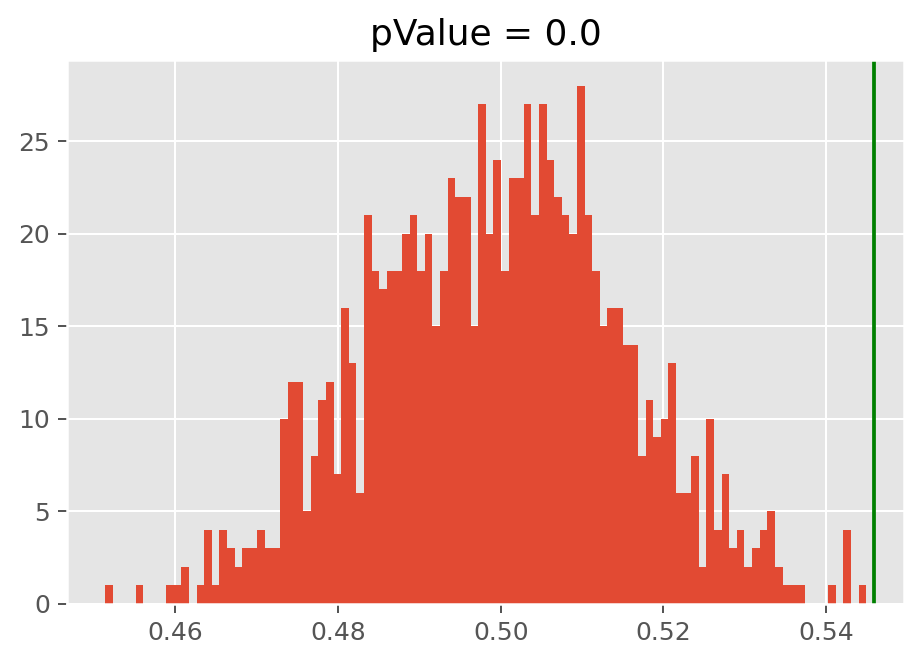

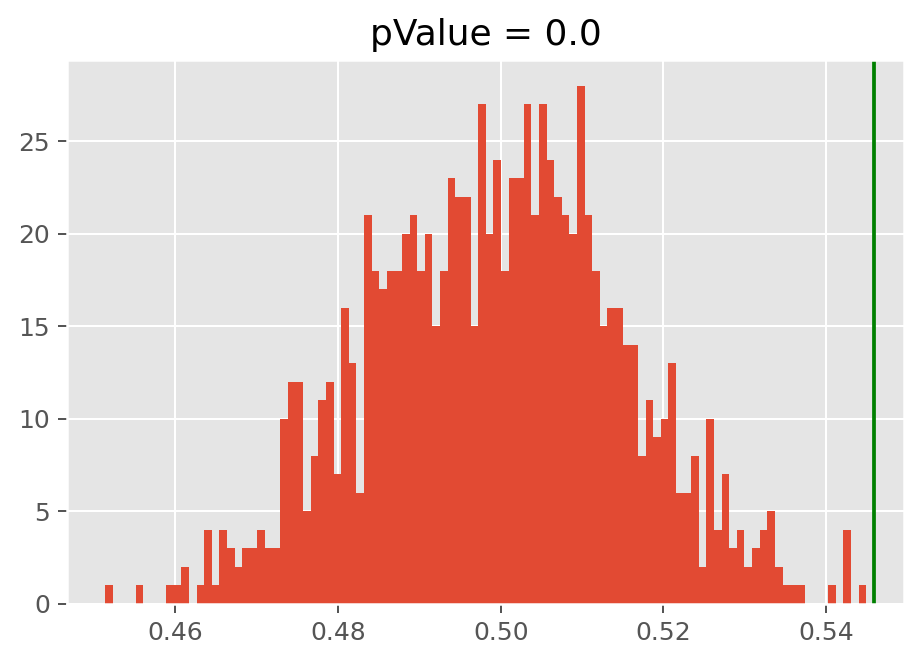

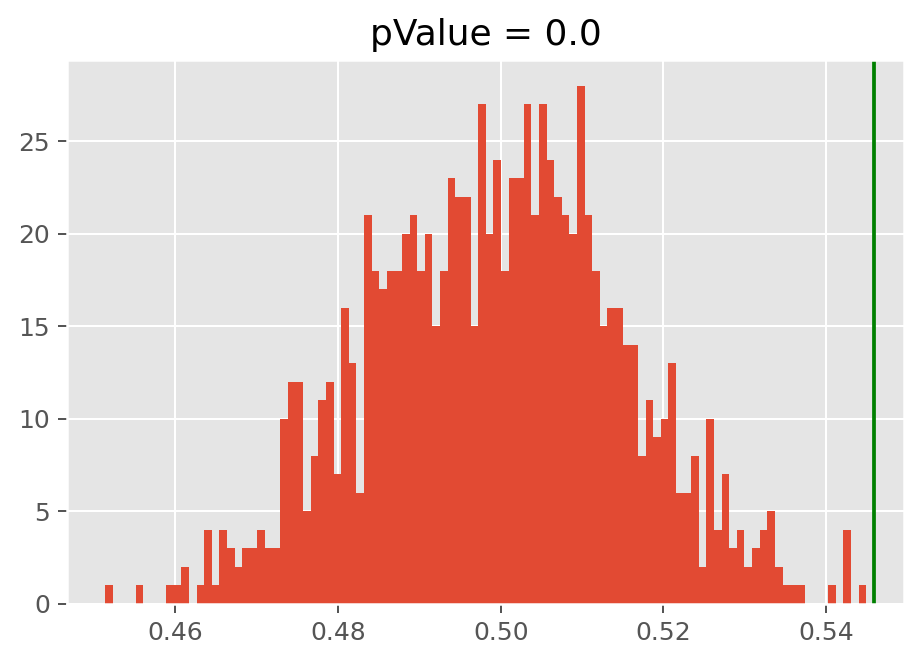

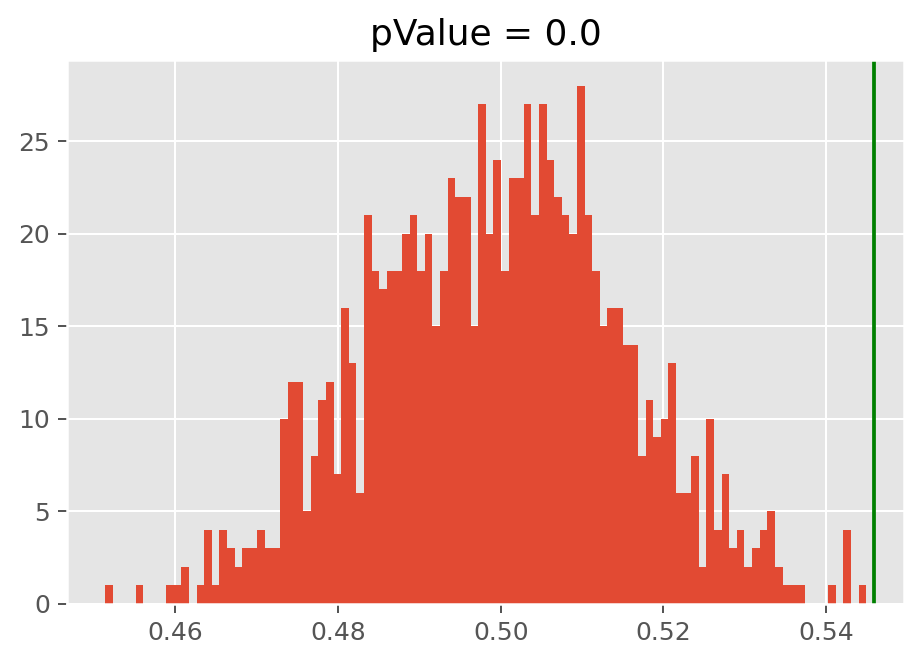

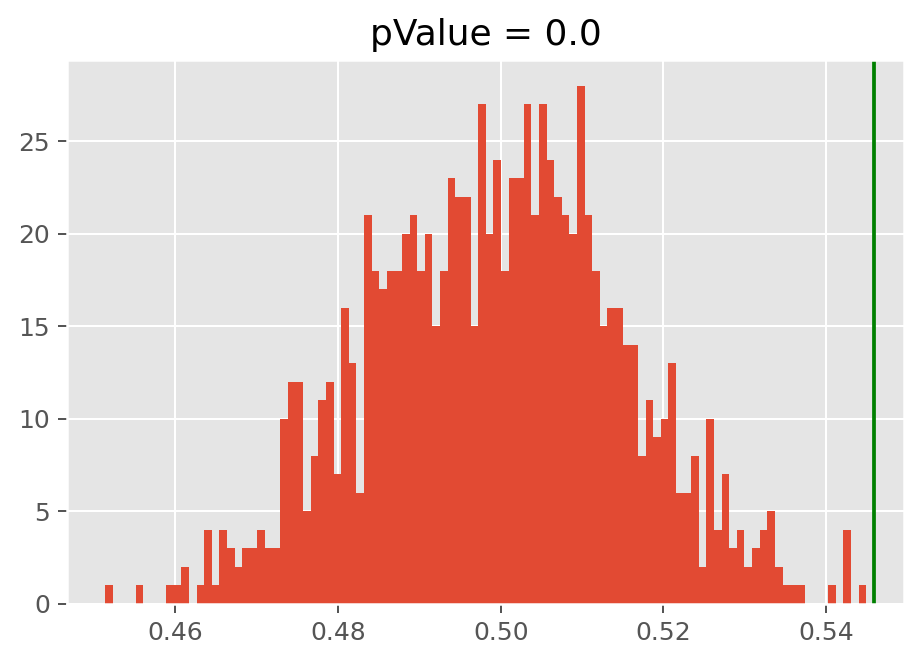

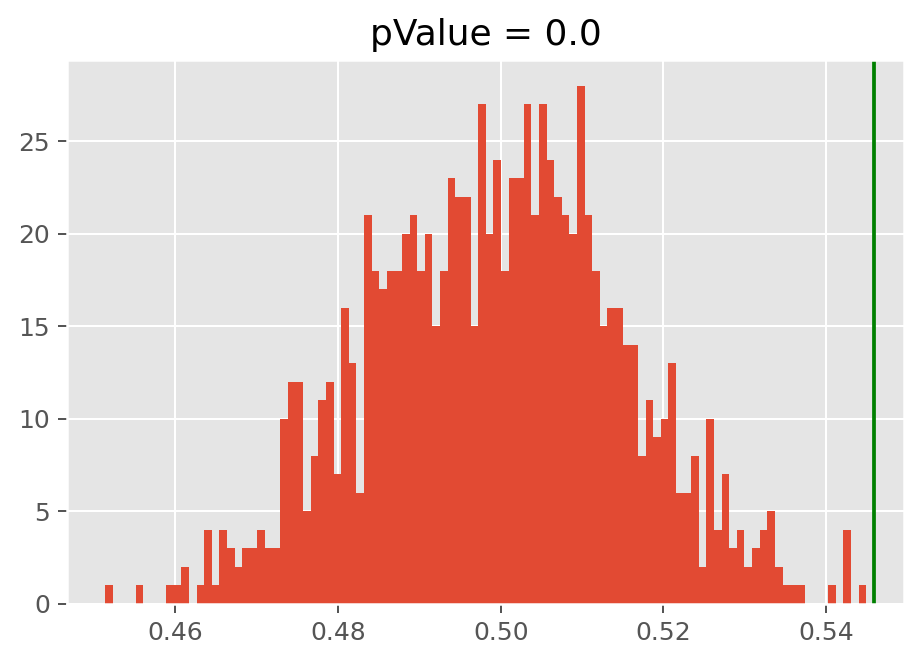

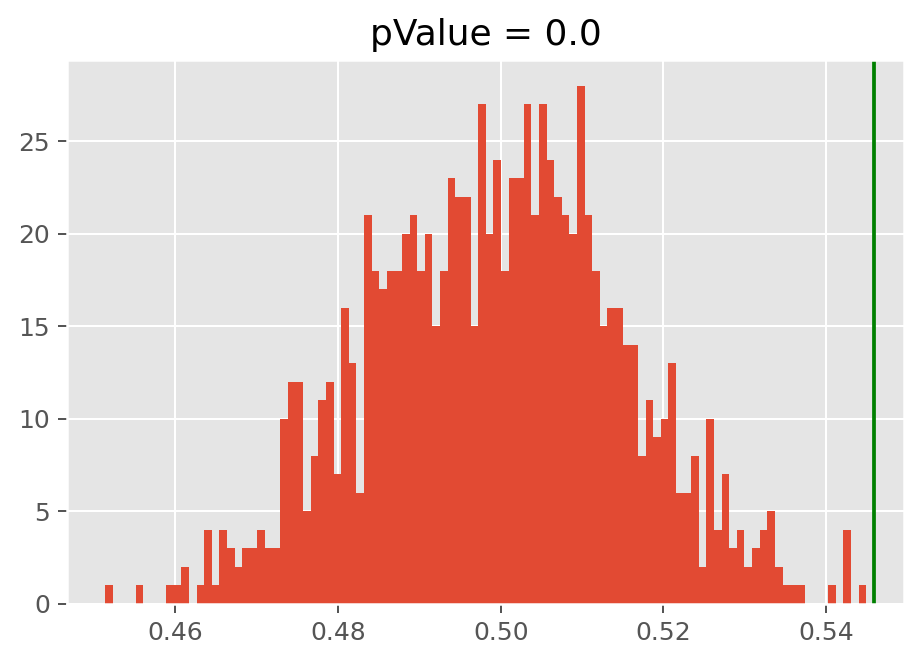

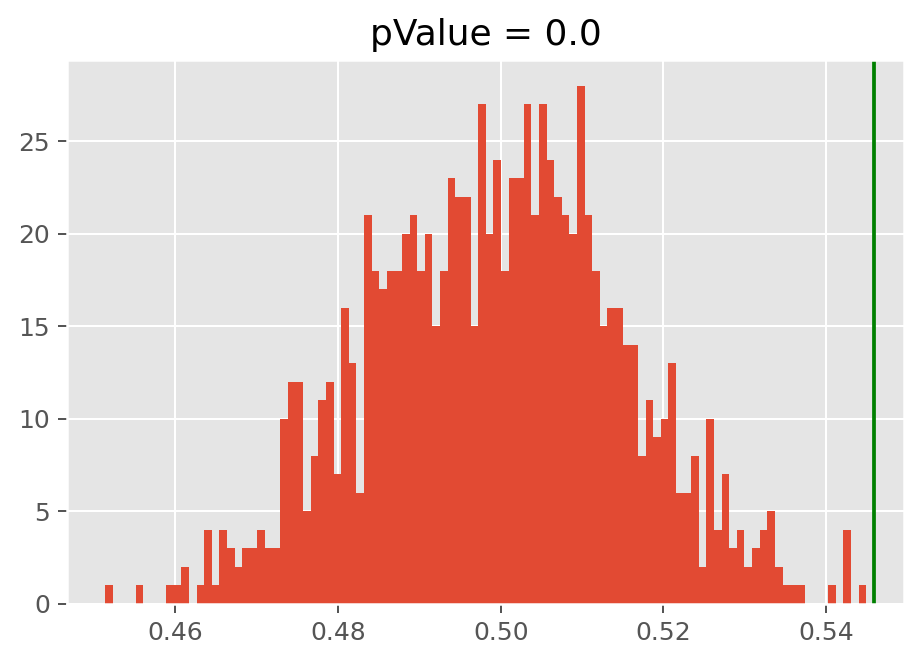

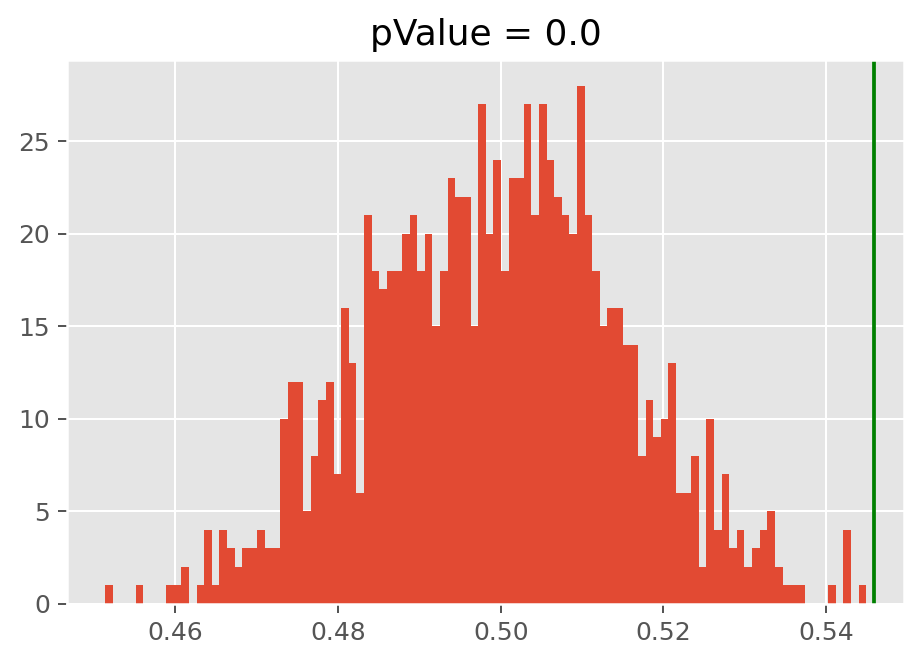

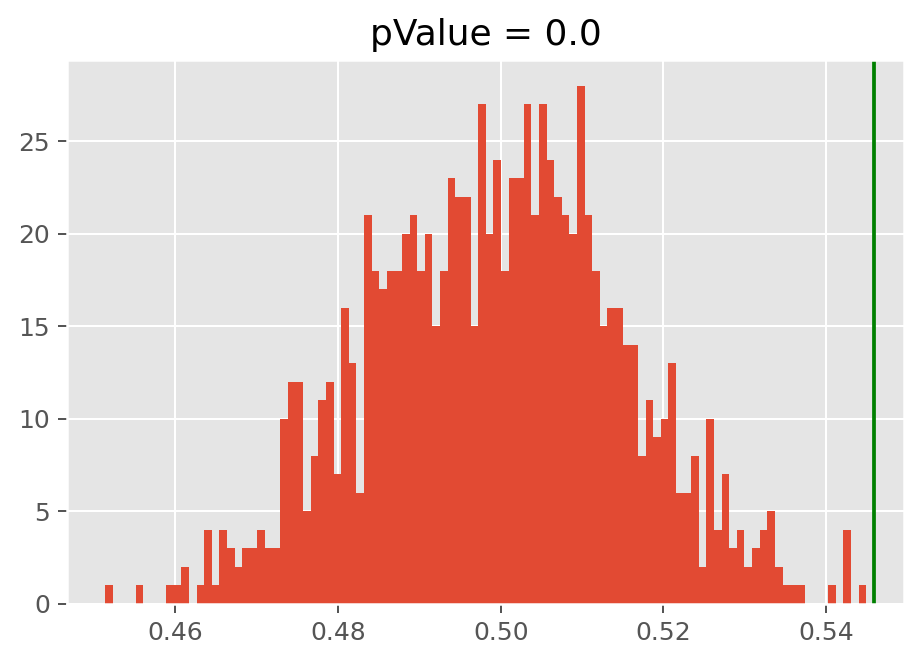

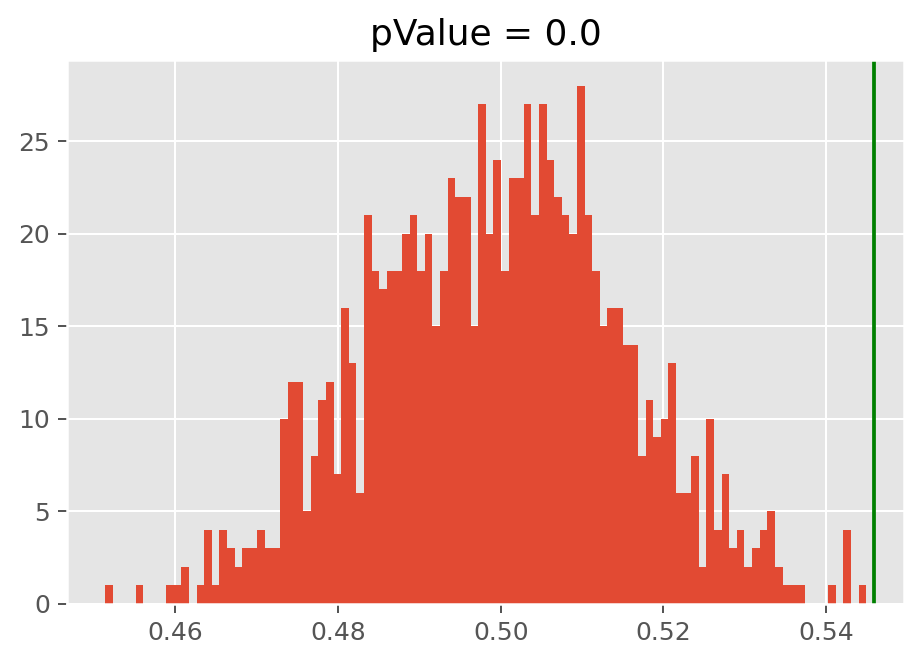

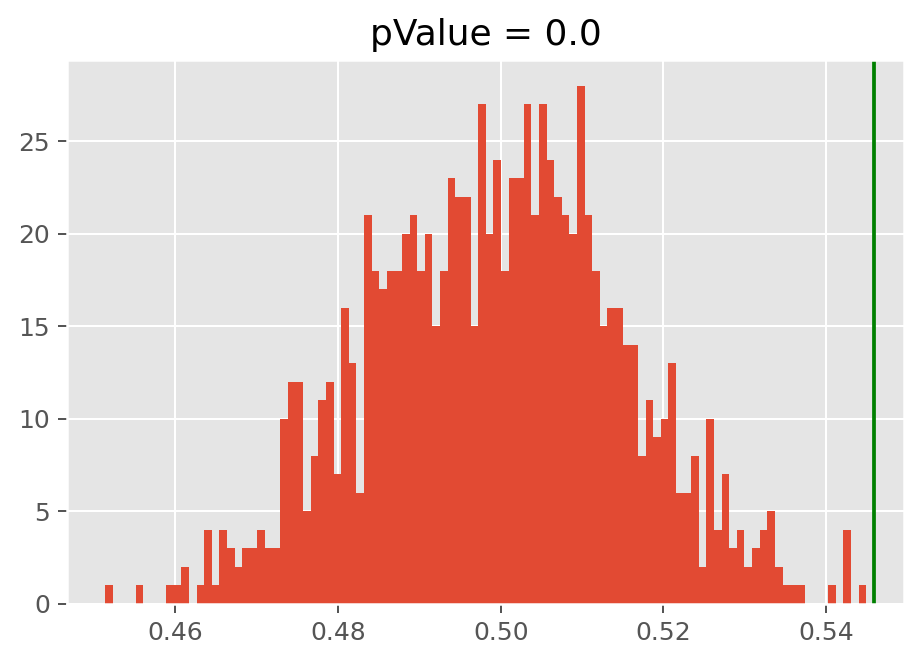

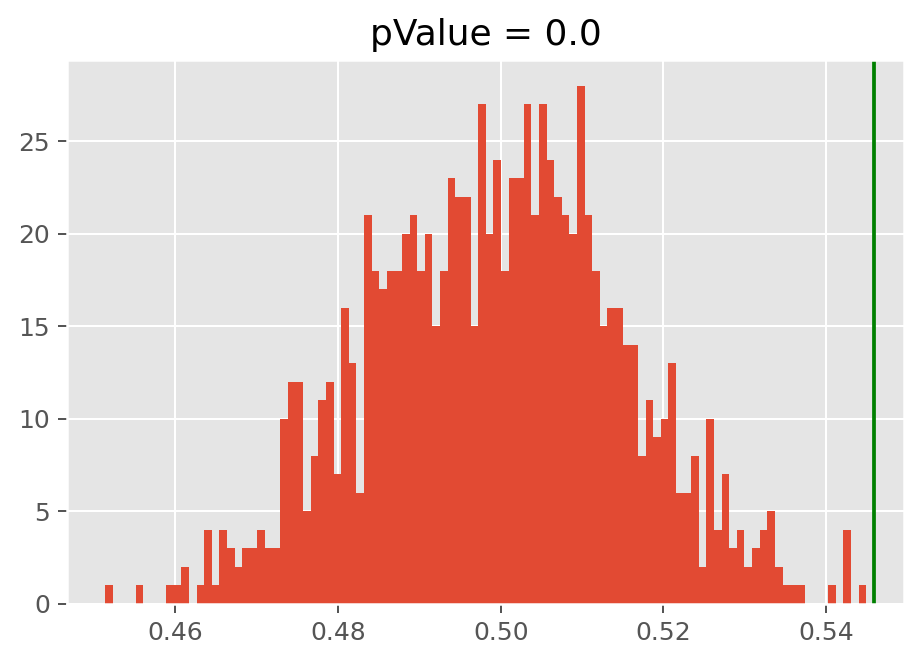

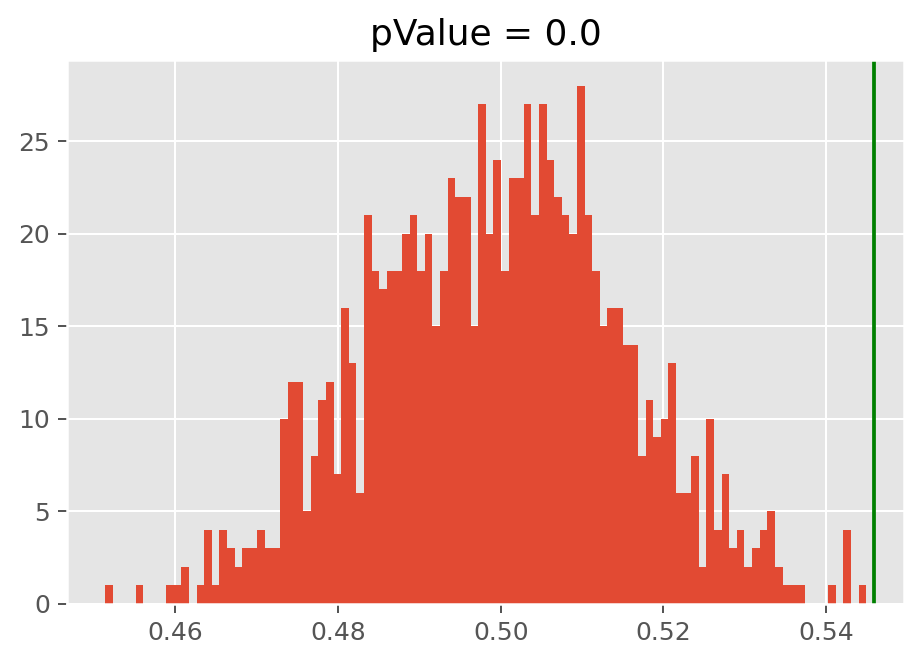

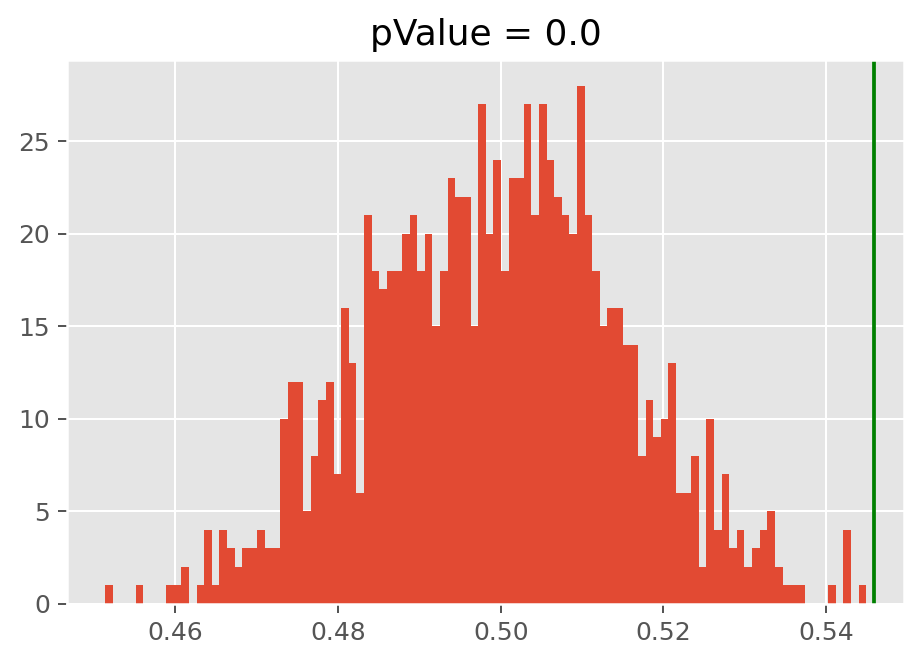

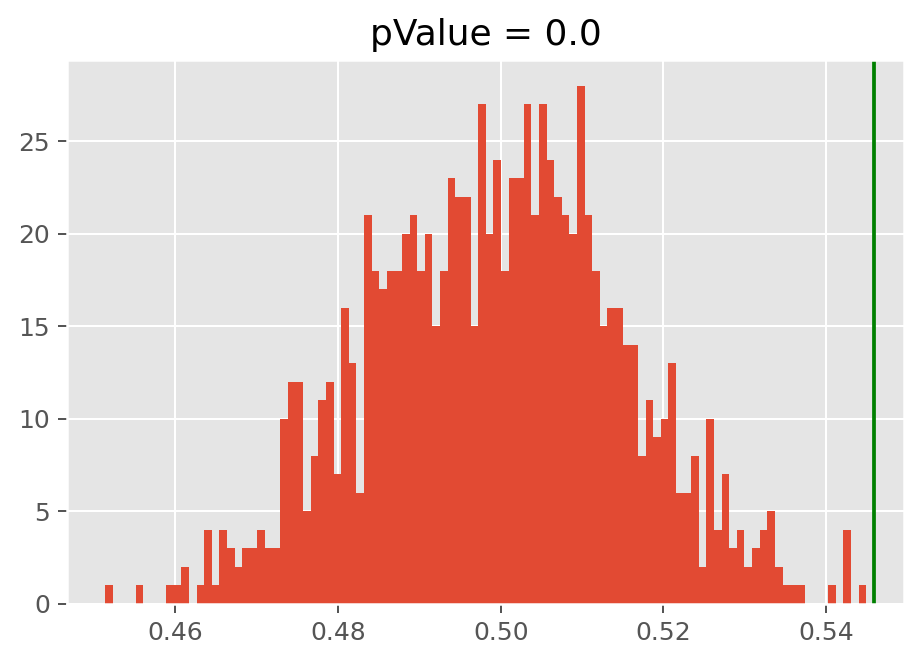

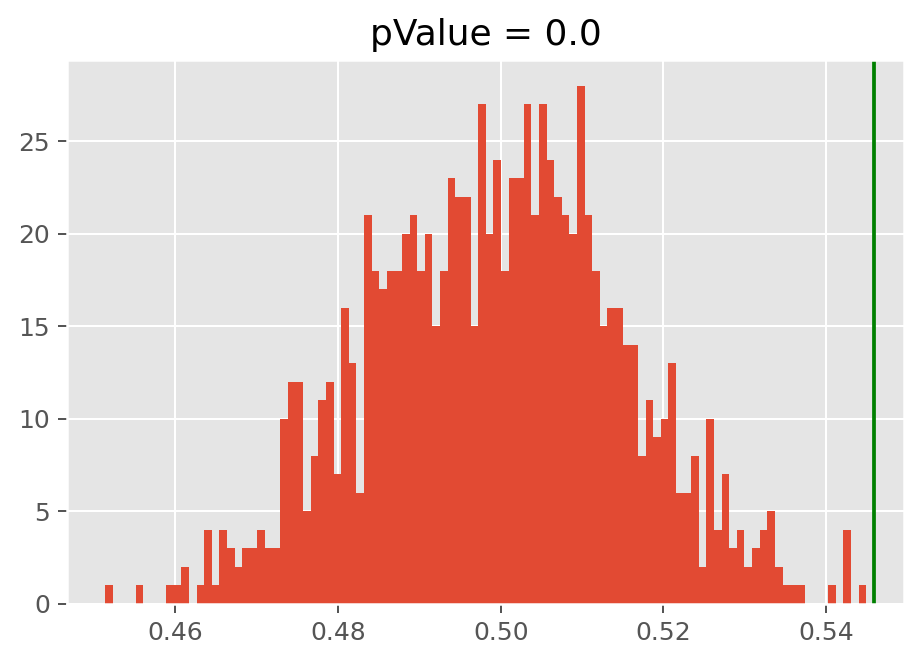

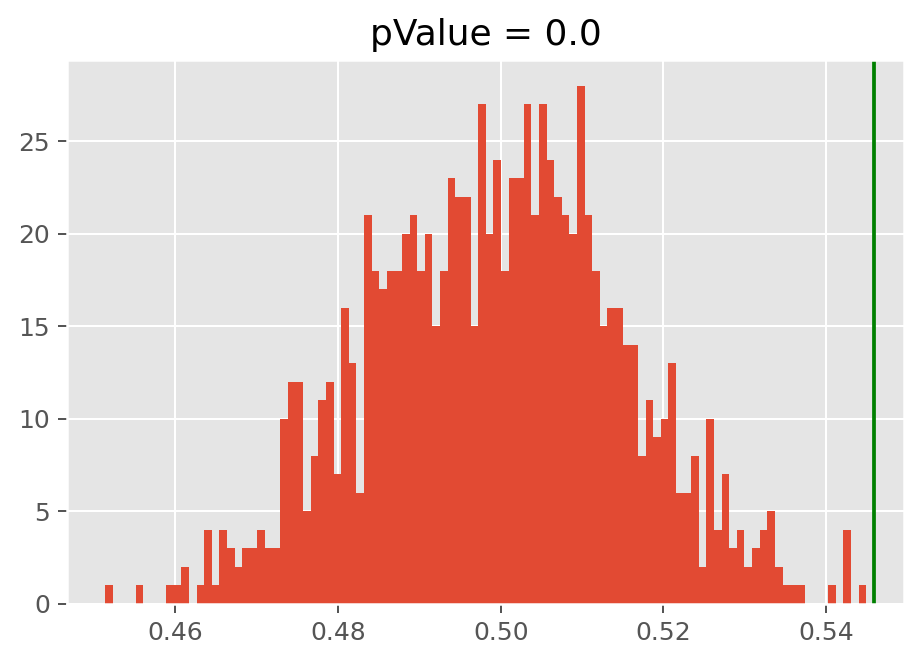

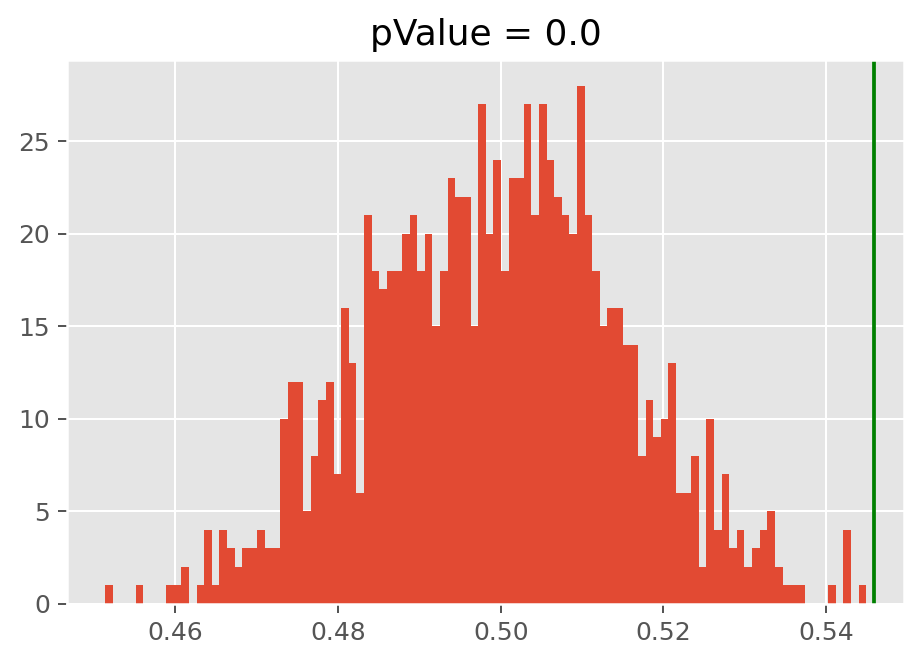

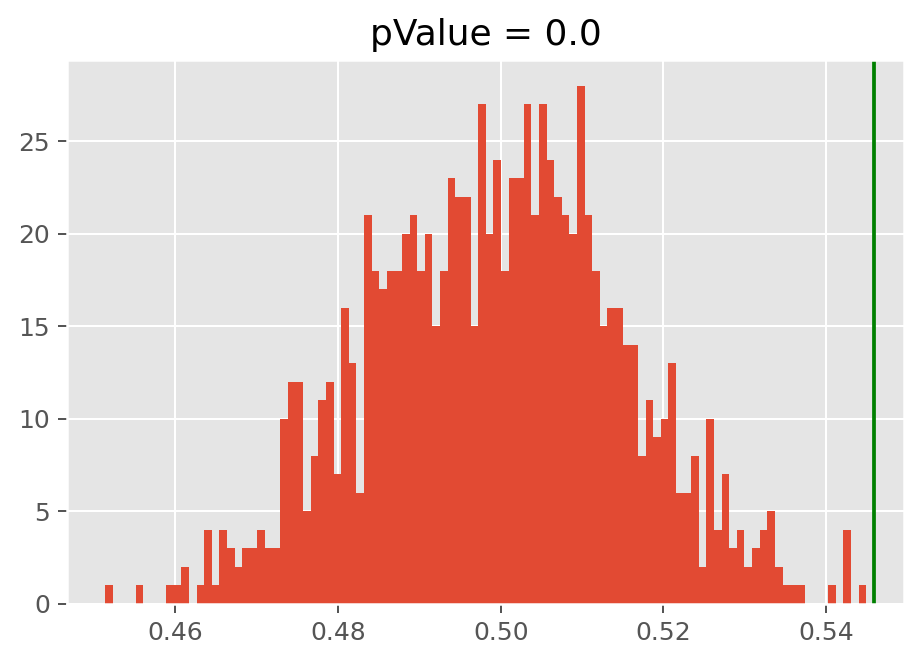

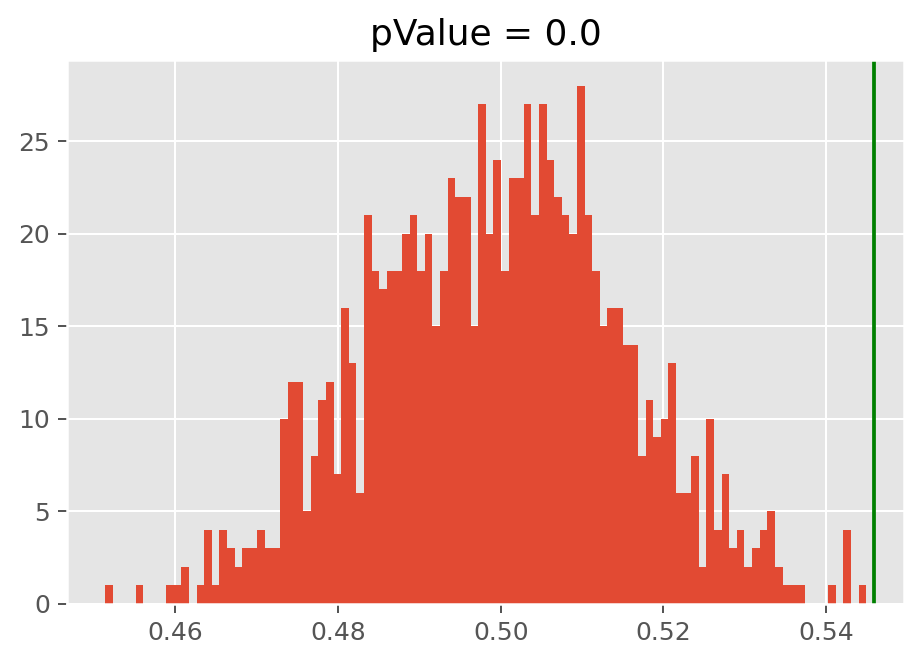

In [17]:
bk.load.current_session_linux()
_, metadata = bk.load.spikes()

metadata

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


Rat Day Shank Id Region Type
0     8   6     1  2    Hpc  Pyr
1     8   6     2  2    Hpc  Pyr
2     8   6     2  3    Hpc  Pyr
3     8   6     2  4    Hpc  Pyr
4     8   6     2  5    Hpc  Pyr
..   ..  ..   ... ..    ...  ...
247   8   6    19  2    BLA  Pyr
248   8   6    19  3    BLA  Pyr
249   8   6    19  4    BLA  Pyr
250   8   6    19  5    BLA  Pyr
251   8   6    19  6    BLA  Pyr

[252 rows x 6 columns]